In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import os
import numpy as np
import scanpy as sc
import PyWGCNA
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import mannwhitneyu, false_discovery_control
import re
from itertools import combinations
from scipy.stats import pearsonr
import ast

In [4]:
def stack_triangle(df, col):
    df = pd.DataFrame(
        df.where(
            np.tri(
                df.shape[0],
                dtype=bool,
                k=-1
            ),
            np.nan
        ).stack(dropna=True), columns=[col] 
    )
    
    return df


In [5]:
# Function that generates and saves the ROC curve
def generate_roc_curve(
    data,
    target_col,
    feature_col,
):
    # ROC curve using all gene pairs
    fpr, tpr, thr = roc_curve(data[target_col], data[feature_col])
    auroc = roc_auc_score(data[target_col], data[feature_col])
    
    return fpr, tpr, thr, auroc

In [6]:
def fig_to_panels(fig, axes, output_dir):
    # Save individual panels of a figure 
    
    for panel_name, ax in axes.items():
        # Extract the panel title
        panel_title = ax.get_title()

        # Sanitize the panel title to use in filenames
        safe_title = panel_title.replace(" ", "_").replace("/", "_").replace("\n", "_").lower()

        # Create the filename for the current panel
        output_file = os.path.join(output_dir,safe_title)

        # Adjust the bounding box to include everything (labels, titles, etc.)
        extent = ax.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())

        # Save the individual panel using the adjusted bounding box
        fig.savefig(output_file + '.pdf', bbox_inches=extent, dpi=300)
        fig.savefig(output_file + '.png', bbox_inches=extent)

        print(f"Saved panel '{panel_title}' to {output_file}")


In [7]:
# Define colors
# Light version is obtained by setting alpha=0.5

ncolor  = '#00728eff' # solid dark
ncolor2 = '#00728e80' # alpha=0.5
lightncolor = '#7fb8c6ff' # solid light

tcolor  = '#ab3502ff'
tcolor2 = '#ab350280'
lighttcolor = '#d49980ff'

graycolor = '#4D4E4FFF'
graycolor2 ='#4d4e4f80'

lightgray = '#C8CAD4'

orangecolor = '#e69426'
orangecolor2 = '#e6942680'
lightorangecolor = '#f2c992ff'

In [8]:
def network_to_adj(network_path):
    network = pd.read_csv(
        network_path,
        usecols=['complex1', 'complex2', 'adj']
    )

    # Add a mirrored version of the network to make it symmetric
    network_mirrored = network.copy()
    network_mirrored.columns = ['complex2', 'complex1', 'adj']
    network = pd.concat([network, network_mirrored], ignore_index=True)

    adj = network.pivot(index='complex1', columns='complex2', values='adj').fillna(0)
    return adj

In [9]:
tumor_cliques = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor/motifs.csv').query('Type in ["3_clique", "4_clique"]')
tumor_cliques['all_genes'] = tumor_cliques['Interaction'].apply(lambda x: re.split(r'[+_&]', x))
all_genes = list(set(tumor_cliques['all_genes'].sum()))

print(sorted(all_genes))

['ACKR1', 'ACKR2', 'ACKR4', 'ACVR1', 'ACVR1B', 'ACVR2A', 'ACVR2B', 'ADA2', 'ADGRA2', 'ADGRE2', 'ADM2', 'ADORA2A', 'ADORA3', 'ANGPTL2', 'ANGPTL4', 'AOC1', 'APOE', 'AXL', 'BMP6', 'C3', 'CALCRL', 'CCL18', 'CCL2', 'CCL22', 'CCL3', 'CCL4', 'CCL5', 'CCL8', 'CCR1', 'CCR2', 'CCR4', 'CCR5', 'CD209', 'CD226', 'CD274', 'CD28', 'CD34', 'CD36', 'CD38', 'CD4', 'CD47', 'CD52', 'CD69', 'CD80', 'CD86', 'CD8A', 'CD8B', 'CD99', 'CLEC2B', 'CLU', 'COL10A1', 'COL11A1', 'COL12A1', 'COL13A1', 'COL14A1', 'COL15A1', 'COL16A1', 'COL1A1', 'COL1A2', 'COL21A1', 'COL22A1', 'COL27A1', 'COL3A1', 'COL4A1', 'COL4A2', 'COL5A1', 'COL5A2', 'COL5A3', 'COL6A1', 'COL6A2', 'COL6A3', 'COL8A1', 'CSF1', 'CSF1R', 'CTLA4', 'CX3CL1', 'CX3CR1', 'CXCL10', 'CXCL11', 'CXCL13', 'CXCL9', 'CXCR3', 'CXCR5', 'CYSLTR1', 'DAG1', 'DLL4', 'DPEP2', 'DPP4', 'EDN1', 'EDNRA', 'EGFR', 'ENTPD1', 'ESR1', 'F2RL2', 'F2RL3', 'FAS', 'FASLG', 'FBN1', 'FLT1', 'FLT4', 'FN1', 'GAS6', 'GPER1', 'GZMA', 'HBEGF', 'HCST', 'HLA-A', 'HLA-B', 'HLA-C', 'HLA-DMA', 'HLA-

In [10]:
genes = {'PDCD1', 'TGFB1'}
mask = tumor_cliques.all_genes.apply(lambda x: genes.issubset(x))
tumor_cliques[mask]

Type                       Interaction   density  \
4553  4_clique  PDCD1+PDCD1LG2&ITGAV_ITGB6+TGFB1  0.741071   

                                   all_genes  
4553  [PDCD1, PDCD1LG2, ITGAV, ITGB6, TGFB1]

In [11]:
tumor_cliques.iloc[::100].Interaction

0                            CCL3+CCR1&CCL5+CCR1
100                     CD4+HLA-DQA2&CD4+HLA-DMB
200     COL1A2+ITGA11_ITGB1&COL12A1+ITGA11_ITGB1
300          ITGA2_ITGB1+LAMB1&ITGA2_ITGB1+LAMA5
400                        CD8A+HLA-F&CD8A+HLA-B
950                       CCL5+CCR1&CD4+HLA-DRB5
1050                  CD4+HLA-DRB5&CD52+SIGLEC10
1150                       CCL3+CCR5&CD4+HLA-DRA
1250              CXCL11+CXCR3&ICAM1+ITGAX_ITGB2
1350                   CXCL10+CXCR3&HLA-F+LILRB1
1450                      ACKR1+CXCL11&CCL4+CCR5
1550                       CCL8+CCR5&ACKR1+CXCL9
1650                       CCL3+CCR1&CD274+PDCD1
1750                        CCL3+CCR5&ACKR1+CCL5
1850                     CD4+HLA-DQA2&ACKR1+CCL8
1950                   CXCL9+CXCR3&CD8A_CD8B+LCK
2050                     CD8B+HLA-E&HLA-F+LILRB2
2150                    CXCL11+CXCR3&CXCL10+DPP4
2250             PDGFB+PDGFRB&COL5A3+ITGA2_ITGB1
2350                       CSF1+CSF1R&CD8A+HLA-A
2450                

# Motifs

In [12]:
import matplotlib.image as mpimg
from matplotlib.lines import Line2D

def read_and_plot_motifs(folder, color=orangecolor, return_fig=False):
    fs = 18
    scaling_factor=1.05
    
    df          = pd.read_csv(os.path.join(folder, 'motifs_permutations.csv'))
    real_counts = pd.read_csv(os.path.join(folder, 'counts.csv'), index_col='motif')
    
    perm_triplets = df[['3_path', '3_clique']].sum(1)
    real_triplets = real_counts.T[['3_path', '3_clique']].loc['number'].sum()

    perm_quadruplets = df.sum(1) - perm_triplets
    real_quadruplets = real_counts.values.sum() - real_triplets
    
    # TRIPLETS AND QUADRUPLETS COUNTS

    data = pd.DataFrame({
        'Triplets': perm_triplets,
        'Quadruplets': perm_quadruplets
    })
    df_long = data.melt(var_name="Feature", value_name="Value")

    real_values = [real_triplets, real_quadruplets]

    # TRIPLETS FRACTIONS

    real_3_fracs = real_counts.loc[['3_path', '3_clique']] / real_triplets
    perm_3_fracs = (df[['3_path', '3_clique']].T / perm_triplets).T

    perm_3_fracs_long = perm_3_fracs.melt(var_name="Feature", value_name="Value")
    real_3_values = real_3_fracs.values.flatten()  # Flatten to align with feature order

    # QUADRUPLETS FRACTIONS

    cols = [col for col in df.columns if col not in ['3_path', '3_clique']]

    real_4_fracs = real_counts.loc[cols] / real_quadruplets
    perm_4_fracs = (df[cols].T / perm_quadruplets).T

    perm_4_fracs_long = perm_4_fracs.melt(var_name="Feature", value_name="Value")
    real_4_values = real_4_fracs.values.flatten()  # Flatten to align with feature order
    

    # ----- PLOT ------
    
    fig, axs = plt.subplot_mosaic(
        '''
        ABCCC
        ''',
        figsize=(18, 6)
    )

    style = dict(marker='s', linestyle=' ', markersize=10,
                 markerfacecolor=color, markeredgecolor='k')

    # Plot 1: Permuted and Real Counts (sorted by median, descending)
    sorted_features_1 = df_long.groupby("Feature")["Value"].median().sort_values(ascending=False).index
    df_long_sorted = df_long[df_long["Feature"].isin(sorted_features_1)]
    df_long_sorted['Value'] = np.log10(df_long_sorted['Value'])

    real_values_series_1 = np.log10(pd.Series(real_values, index=df_long["Feature"].unique()))
    real_values_sorted_1 = real_values_series_1.loc[sorted_features_1]

    # Plot log10 counts on a linear scale
    #real_values_sorted_1 = np.log10(real_values_sorted_1)
    #log_values_sorted_1 = np.log10(df_long_sorted.groupby("Feature")["Value"].median().loc[sorted_features_1])

    #sns.boxplot(x="Feature", y="Value", data=df_long_sorted, color=lightgray, order=sorted_features_1, ax=axs['A'], whis=(2.5, 97.5))
    sns.violinplot(x="Feature", y="Value", data=df_long_sorted, color=lightgray, order=sorted_features_1, ax=axs['A'])

    #axs['A'].plot(range(len(real_values_sorted_1)), real_values_sorted_1, **style)
    axs['A'].plot(range(len(real_values_sorted_1)), real_values_sorted_1, **style, label='log10 Counts')
    axs['A'].set_title("Total Occurrences", fontdict={'fontsize': fs})
    axs['A'].set_ylabel("log$_{10}$(Counts)", fontdict={'fontsize': fs})
    axs['A'].set_xlabel("Feature", fontdict={'fontsize': fs})

    # Plot 2: Fractions of Triplets (sorted by median, descending)
    sorted_features_2 = perm_3_fracs_long.groupby("Feature")["Value"].median().sort_values(ascending=False).index
    perm_3_fracs_sorted = perm_3_fracs_long[perm_3_fracs_long["Feature"].isin(sorted_features_2)]

    real_3_values_series = pd.Series(real_3_values, index=perm_3_fracs_long["Feature"].unique())
    real_3_values_sorted = real_3_values_series.loc[sorted_features_2]

    #sns.boxplot(x="Feature", y="Value", data=perm_3_fracs_sorted, color=lightgray, order=sorted_features_2, ax=axs['B'], whis=(2.5, 97.5))
    sns.violinplot(x="Feature", y="Value", data=perm_3_fracs_sorted, color=lightgray, order=sorted_features_2, ax=axs['B'])
    
    axs['B'].plot(range(len(real_3_values_sorted)), real_3_values_sorted, **style)
    axs['B'].set_title("Distribution of Triplets", fontdict={'fontsize': fs})
    axs['B'].set_ylabel("Proportion", fontdict={'fontsize': fs})
    axs['B'].set_xlabel("Feature", fontdict={'fontsize': fs})
    axs['B'].set_xticks(range(len(real_3_values_sorted)))

    # Plot 3: Fractions of Quadruplets (sorted by median, descending)
    sorted_features_3 = perm_4_fracs_long.groupby("Feature")["Value"].median().sort_values(ascending=False).index
    perm_4_fracs_sorted = perm_4_fracs_long[perm_4_fracs_long["Feature"].isin(sorted_features_3)]

    real_4_values_series = pd.Series(real_4_values, index=perm_4_fracs_long["Feature"].unique())
    real_4_values_sorted = real_4_values_series.loc[sorted_features_3]

    #sns.boxplot(x="Feature", y="Value", data=perm_4_fracs_sorted, color=lightgray, order=sorted_features_3, ax=axs['C'], whis=(2.5, 97.5))
    sns.violinplot(x="Feature", y="Value", data=perm_4_fracs_sorted, color=lightgray, order=sorted_features_3, ax=axs['C'])

    axs['C'].plot(range(len(real_4_values_sorted)), real_4_values_sorted, **style)
    axs['C'].set_title("Distribution of Quadruplets", fontdict={'fontsize': fs})
    axs['C'].set_ylabel("Proportion", fontdict={'fontsize': fs})
    axs['C'].set_xlabel("Feature", fontdict={'fontsize': fs})
    axs['C'].set_xticks(range(len(real_4_values_sorted)))

    # Adjust the label padding dynamically based on the image height
    img_dir = '/home/lnemati/pathway_crosstalk/data/motifs_icons/'
    img_width = 0.15 * scaling_factor# Increased image width for larger icons
    img_height = img_width  # Keep aspect ratio the same

    # Get the position of the main axes for all subplots
    for ax_name in ['A', 'B', 'C']:
        ax = axs[ax_name]
        xl, yl, xh, yh = np.array(ax.get_position()).ravel()
        w = xh - xl
        h = yh - yl

        # Calculate dynamic labelpad based on image height
        figure_height_in_inches = fig.get_size_inches()[1]
        figure_to_axes_ratio = h / figure_height_in_inches
        dynamic_labelpad = img_height / figure_to_axes_ratio * 72  # Convert to points (1 inch = 72 points)
        #ax.set_xlabel("Feature", labelpad=dynamic_labelpad)

        # Loop through x-axis labels and place an image for each feature
        for i, label in enumerate(sorted_features_1 if ax_name == 'A' else (sorted_features_2 if ax_name == 'B' else sorted_features_3)):
            img_path = os.path.join(img_dir, f"{label}.png")

            if os.path.exists(img_path):
                img = mpimg.imread(img_path)

                # Get the x-coordinate of the current feature label (in data coordinates)
                label_display_coords = ax.get_xticklabels()[i].get_position()  # Get the label position directly
                label_x = label_display_coords[0]  # Extract the x-coordinate of the label

                # Transform the label's x-coordinate from data coordinates to figure coordinates
                label_display_coords = ax.transData.transform((label_x, 0))  # Data to figure
                fig_coords = fig.transFigure.inverted().transform(label_display_coords)  # Figure coordinates

                # Center the image over the x-axis label
                xpos = fig_coords[0] - img_width / 2  # Adjust x position to center image
                ypos = yl - img_height - 0.03  # Adjust y position below the x-axis labels

                # Add new axes for the image
                ax_img = fig.add_axes([xpos, ypos, img_width, img_height])
                ax_img.axison = False
                ax_img.imshow(img)

    # Remove grid from all subplots
    for ax_name in ['A', 'B', 'C']:
        axs[ax_name].grid(False)

    # Make axes black
    for ax_name in ['A', 'B', 'C']:
        ax = axs[ax_name]
        ax.spines[['bottom', 'left']].set_color('black')
        ax.spines[['right', 'top']].set_visible(False)

    # Manually adjust subplot spacing (remove tight_layout)
    #plt.subplots_adjust(left=0.07, right=0.93, top=0.93, bottom=0.15)
    lp = 85

    axs['A'].set_xlabel("Group", labelpad=lp)
    axs['A'].set_xticks([])
    axs['B'].set_xlabel("Motif", labelpad=lp)
    axs['B'].set_xticks([])
    axs['C'].set_xlabel("Motif", labelpad=lp)
    axs['C'].set_xticks([])

    handles = [
        Line2D(
            [0], [0], marker='o', color='w', markerfacecolor=color, 
            markeredgecolor='k', markersize=10, label='Observed Value'
        ),
        Line2D(
            [0], [0], marker='s', color='w', markerfacecolor=lightgray, 
            markeredgecolor='lightgray', markersize=10, label='Ensemble (Permutations)'
        ),
    ]


    axs['A'].set_ylim(bottom=0)
    axs['B'].set_ylim(bottom=0)
    axs['C'].legend(handles, ['Observed Value', 'Ensemble (Permutations)'], loc='upper right')

    #plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/crosstalk/motifs_tumor.pdf', bbox_inches='tight')
    #plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/crosstalk/motifs_tumor.png', bbox_inches='tight')

    if return_fig:
        return fig
    else:
        plt.show()


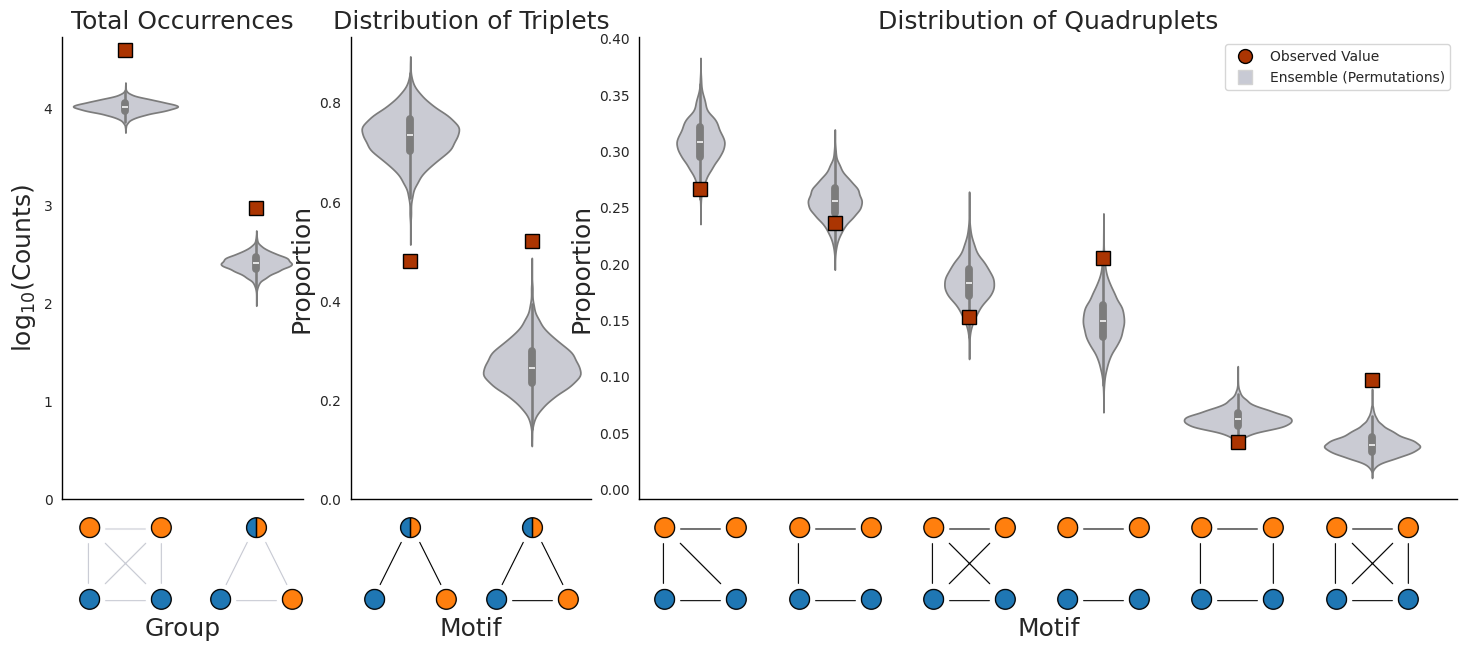

In [13]:
#read_and_plot_motifs('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/both', color='k')
#read_and_plot_motifs('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/normal', color=ncolor)
fig = read_and_plot_motifs('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor', color=tcolor)

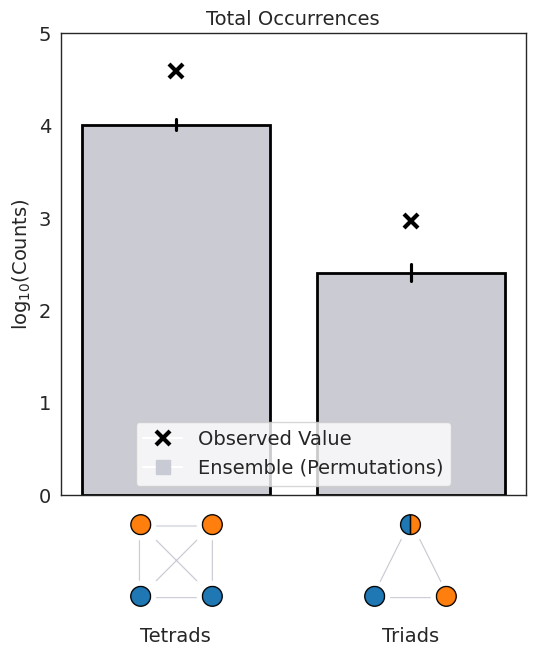

In [14]:
import matplotlib.image as mpimg
from matplotlib.lines import Line2D

def read_and_plot_motifs(folder, color=orangecolor, ax=None, return_fig=False, fs=14):
    scaling_factor = 1.05
    
    df          = pd.read_csv(os.path.join(folder, 'motifs_permutations.csv'))
    real_counts = pd.read_csv(os.path.join(folder, 'counts.csv'), index_col='motif')
    
    perm_triplets = df[['3_path', '3_clique']].sum(1)
    real_triplets = real_counts.T[['3_path', '3_clique']].loc['number'].sum()

    perm_quadruplets = df.sum(1) - perm_triplets
    real_quadruplets = real_counts.values.sum() - real_triplets
    
    data = pd.DataFrame({
        'Triads': perm_triplets,
        'Tetrads': perm_quadruplets
    })
    df_long = data.melt(var_name="Feature", value_name="Value")

    real_values = [real_triplets, real_quadruplets]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    else:
        fig = ax.figure

    style = dict(marker='x', linestyle=' ', markersize=10, markeredgewidth=3,
                 markerfacecolor=color, markeredgecolor='k')

    sorted_features_1 = df_long.groupby("Feature")["Value"].median().sort_values(ascending=False).index
    df_long_sorted = df_long[df_long["Feature"].isin(sorted_features_1)]
    df_long_sorted['Value'] = np.log10(df_long_sorted['Value'])

    real_values_series_1 = np.log10(pd.Series(real_values, index=df_long["Feature"].unique()))
    real_values_sorted_1 = real_values_series_1.loc[sorted_features_1]

    sns.barplot(
        x="Feature",
        y="Value",
        data=df_long_sorted,
        color=lightgray,
        order=sorted_features_1,
        ax=ax,
        estimator='mean',
        errorbar='sd',
        linewidth=2,
        edgecolor='k',
        err_kws={'color': 'black'}
    )

    ax.plot(range(len(real_values_sorted_1)), real_values_sorted_1, **style, label='log10 Counts')
    ax.set_title("Total Occurrences", fontdict={'fontsize': fs})
    ax.set_ylabel("log$_{10}$(Counts)", fontdict={'fontsize': fs})
    ax.set_xlabel("Feature", fontdict={'fontsize': fs}, labelpad=20)

    img_dir = '/home/lnemati/pathway_crosstalk/data/motifs_icons/'
    img_width = 0.15 * scaling_factor
    img_height = img_width  
    
    xl, yl, xh, yh = np.array(ax.get_position()).ravel()
    w = xh - xl
    h = yh - yl
    
    figure_height_in_inches = fig.get_size_inches()[1]
    figure_to_axes_ratio = h / figure_height_in_inches
    dynamic_labelpad = img_height / figure_to_axes_ratio * 72 + 3
    #ax.set_xlabel("Feature", fontdict={'fontsize': fs}, labelpad=dynamic_labelpad)
    ax.set_xlabel('')
    
    for i, label in enumerate(sorted_features_1):
        img_path = os.path.join(img_dir, f"{label}.png")
        if os.path.exists(img_path):
            img = mpimg.imread(img_path)
            label_display_coords = ax.get_xticklabels()[i].get_position()
            label_x = label_display_coords[0]
            label_display_coords = ax.transData.transform((label_x, 0))
            fig_coords = fig.transFigure.inverted().transform(label_display_coords)
            xpos = fig_coords[0] - img_width / 2
            ypos = yl - img_height - 0.03
            ax_img = fig.add_axes([xpos, ypos, img_width, img_height])
            ax_img.axison = False
            ax_img.imshow(img)
    
    handles = [
        Line2D([0], [0], marker='x', color='w', markerfacecolor=color, markeredgewidth=3,
               markeredgecolor='k', markersize=10, label='Observed Value'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor=lightgray, 
               markeredgecolor=lightgray, markersize=10, label='Ensemble (Permutations)'),
    ]
    
    ax.legend(handles=handles, loc='lower center', fontsize=fs)
    ax.set_ylim(0, 5)
    ax.tick_params(labelsize=fs)
    ax.tick_params(axis='x', which='major', pad=dynamic_labelpad)    
    
    if return_fig:
        return fig

        
fig = read_and_plot_motifs('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor', color=tcolor, return_fig=True)
fig.show()

In [15]:
#fig.savefig('/home/lnemati/pathway_crosstalk/results/figures/crosstalk/motifs_both_total.pdf', dpi=300, bbox_inches='tight')
#fig.savefig('/home/lnemati/pathway_crosstalk/results/figures/crosstalk/motifs_both_total.png', dpi=300, bbox_inches='tight')

In [16]:
#df = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor/motifs_permutations.csv')
#motifs = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor/counts.csv', index_col='motif')

df = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor/motifs_permutations.csv')
motifs = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor/counts.csv', index_col='motif')

motifs = motifs['number'] 

df3 = df[[col for col in df.columns if col.startswith('3')]]
df4 = df[[col for col in df.columns if col.startswith('4')]]
motifs3 = motifs.loc[[idx for idx in motifs.index if idx.startswith('3')]]
motifs4 = motifs.loc[[idx for idx in motifs.index if idx.startswith('4')]]

motifs3 = motifs3 / motifs3.sum()
motifs4 = motifs4 / motifs4.sum()
df3 = (df3.T / df3.sum(1)).T
df4 = (df4.T / df4.sum(1)).T

df = df3.join(df4)
motifs = pd.concat([motifs3, motifs4])

means = df.mean()
stds = df.std()

motifs_z = ((motifs - means) / stds).sort_values()
motifs_z.name = 'z'

In [17]:
(motifs3 < df3).sum() / df3.shape[0]

3_path      1.0
3_clique    0.0
dtype: float64

In [18]:
(motifs4 < df4).sum() / df4.shape[0]

4_no_crosstalk      0.0068
4_path              0.8824
4_triangle_extra    0.9908
4_cycle             0.9976
4_one_missing       0.9592
4_clique            0.0000
dtype: float64

In [19]:
(motifs < df).sum() / df.shape[0]

3_path              1.0000
3_clique            0.0000
4_no_crosstalk      0.0068
4_path              0.8824
4_triangle_extra    0.9908
4_cycle             0.9976
4_one_missing       0.9592
4_clique            0.0000
dtype: float64

In [20]:
import numpy as np

# Compute the reference distribution's center (e.g., median or mean)
null_center = np.mean(df, axis=0)

# Compute two-tailed p-values
p_values = ( (np.abs(motifs - null_center) <= np.abs(df - null_center)).sum(axis=0) ) / df.shape[0]
p_values = pd.Series(false_discovery_control(p_values), index=p_values.index)
p_values = p_values.loc[motifs_z.index]
p_values

motif
3_path              0.00000
4_cycle             0.02816
4_triangle_extra    0.03200
4_one_missing       0.10400
4_path              0.23500
4_no_crosstalk      0.01960
3_clique            0.00000
4_clique            0.00000
dtype: float64

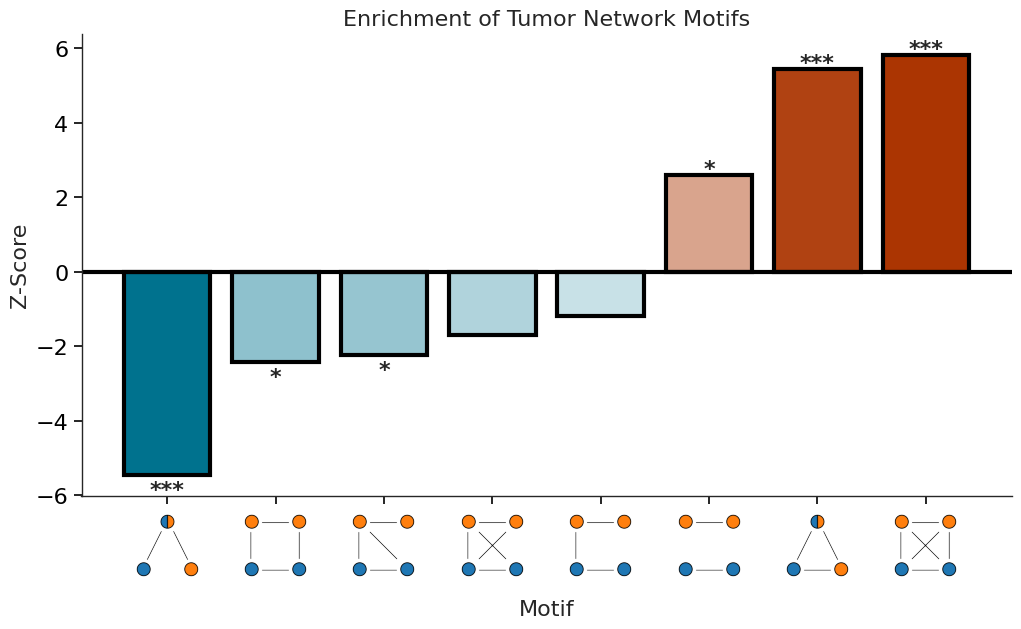

In [21]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.image as mpimg
import os

img_dir = '/home/lnemati/pathway_crosstalk/data/motifs_icons'
fs = 16

# Use your existing data
motifs = motifs_z.index  # Motif names (e.g., a pandas index)
z_scores = motifs_z.values  # Z-score values (e.g., from a pandas series)

# Create the custom colormap and normalize the z-scores
cmap = mcolors.LinearSegmentedColormap.from_list('custom_gradient', [ncolor, 'white', tcolor])
norm = mcolors.TwoSlopeNorm(vmin=z_scores.min(), vcenter=0, vmax=z_scores.max())
colors = cmap(norm(z_scores))

# Create the bar plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

bars = ax.bar(
    motifs,       # x values (motifs)
    z_scores,     # y values (z-scores)
    color=colors, # Assign the calculated colors
    edgecolor='k',
    linewidth=3,
)

# Set the image properties
img_width = 0.105  # Fraction of figure width
img_height = img_width  # Maintain aspect ratio

xl, yl, xh, yh = np.array(ax.get_position()).ravel()
w = xh - xl
h = yh - yl

# Calculate dynamic labelpad based on image height
figure_height_in_inches = fig.get_size_inches()[1]
figure_to_axes_ratio = h / figure_height_in_inches
dynamic_labelpad = img_height / figure_to_axes_ratio * 72  # Convert to points (1 inch = 72 points)

# Loop through each motif and replace its x-axis label with an image
for i, label in enumerate(motifs):
    img_path = os.path.join(img_dir, f"{label}.png")
    if os.path.exists(img_path):
        img = mpimg.imread(img_path)

        # Get the x-coordinate of the current feature label (in data coordinates)
        label_display_coords = ax.get_xticklabels()[i].get_position()  # Get the label position directly
        label_x = label_display_coords[0]  # Extract the x-coordinate of the label

        # Transform the label's x-coordinate from data coordinates to figure coordinates
        label_display_coords = ax.transData.transform((label_x, 0))  # Data to figure
        fig_coords = fig.transFigure.inverted().transform(label_display_coords)  # Figure coordinates

        # Center the image over the x-axis label
        xpos = fig_coords[0] - img_width / 2  # Adjust x position to center image
        ypos = yl - img_height - 0.03  # Adjust y position below the x-axis labels

        # Add new axes for the image
        ax_img = fig.add_axes([xpos, ypos, img_width, img_height])
        ax_img.axison = False
        ax_img.imshow(img)

# Add a horizontal line at y=0
xlim = ax.get_xlim()
ax.hlines(0, xlim[0], xlim[1], color='k', linestyle='-', linewidth=3)
ax.set_xlim(xlim[0], xlim[1])

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=fs)

# Customize the plot
ax.set_title("Enrichment of Tumor Network Motifs", fontsize=16)
ax.set_xlabel("Motif", fontsize=fs)
ax.set_ylabel("Z-Score", fontsize=fs)
ax.set_xticklabels([])
ax.set_xlabel('Motif', labelpad=65)

# Define significance thresholds
sig_levels = {0.001: '***', 0.01: '**', 0.05: '*'}

# Loop through bars to annotate significance
for bar, z_score, p_val in zip(bars, z_scores, p_values):
    height = bar.get_height()
    sig_symbol = next((symbol for threshold, symbol in sig_levels.items() if p_val <= threshold), None)
    
    if sig_symbol:
        text_y = height + 0.15 if z_score > 0 else height - 0.15  # Adjust position based on sign
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # X position (center of bar)
            text_y,  # Y position
            sig_symbol,
            ha='center',
            va='center' if z_score > 0 else 'top',  # Adjust vertical alignment
            fontsize=fs,
            fontweight='bold'
        )

# Add a legend for significance symbols with monospaced font
legend_labels = [
    "*   (p ≤ 0.05)",
    "**  (p ≤ 0.01)",
    "*** (p ≤ 0.001)",
]
legend_patches = [
    plt.Line2D([0], [0], color='black', lw=0, marker='', markersize=10, label=label) for label in legend_labels
]
#ax.legend(handles=legend_patches, loc='upper left', fontsize=fs-3, title='Permutation Test', frameon=False)

#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/crosstalk/tumor_motifs_enrichment.pdf', bbox_inches='tight', dpi=300)
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/crosstalk/tumor_motifs_enrichment.png', bbox_inches='tight')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)

ax.tick_params(
    axis='both',
    which='both',
    labelsize=fs,
    direction='out',
    length=6,
    width=1.2,
    colors='black'
)

plt.show()

In [22]:
tumor_cliques = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor/motifs.csv').query('Type in ["3_clique", "4_clique"]')
tumor_cliques['all_genes'] = tumor_cliques['Interaction'].apply(lambda x: re.split(r'[+_&]', x))

all_genes = list(set(tumor_cliques['all_genes'].sum()))

gene_occurrences = {}
for gene in all_genes:
    gene_occurrences[gene] = tumor_cliques['all_genes'].apply(lambda x: gene in x).sum()
gene_occurrences = pd.Series(gene_occurrences).sort_values(ascending=False)
gene_occurrences.sort_values(ascending=False, inplace=True)
gene_occurrences.head(20)

ITGB1     960
CD4       925
CXCR3     684
ITGA11    434
CCR5      431
CCL8      406
ITGB2     320
CD8A      319
CD8B      317
CD80      293
CXCL13    266
CCR1      244
CCL5      241
ACKR1     240
CTLA4     239
CD28      237
CD86      237
CCR4      236
CXCL11    235
CXCL10    232
dtype: int64

# Cliques Hallmarks

In [23]:
import pandas as pd
import re

# Load hallmark gene sets
def read_gmt(file_path):
    gene_sets = {}
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 3:
                gene_sets[parts[0]] = set(parts[2:])
    return gene_sets

# Load hallmark data
hallmarks_path = '/home/lnemati/resources/msigdb_hallmarks/h.all.v2024.1.Hs.symbols.gmt'
hallmarks = read_gmt(hallmarks_path)

# Generate readable labels
labels = [label.replace('HALLMARK_', '').replace('_', ' ').title() for label in hallmarks.keys()]

# Mapping for special formatting
replace = {
    'Myc': 'MYC',
    'Kras': 'KRAS',
    'Il2': 'IL2',
    'Stat5': 'STAT5',
    'Il6': 'IL6',
    'Jak': 'JAK',
    'Stat3': 'STAT3',
    'P53': 'P53',
    'Tnfa': 'TNFα',
    'Nfkb': 'NF-κB',
    'Mtorc1': 'MTORC1',
    ' Dn': ' Down',
    'Epithelial Mesenchymal Transition': 'E-M Transition'
}

# Apply replacements to labels
for str1, str2 in replace.items():
    labels = [label.replace(str1, str2) for label in labels]

# Map original hallmark names to cleaned labels
hallmark_name_map = dict(zip(hallmarks.keys(), labels))

# Load cliques
tumor_cliques = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor/motifs.csv')
tumor_cliques = tumor_cliques.query('Type in ["3_clique", "4_clique"]')

# Parse gene lists from interactions
tumor_cliques['all_genes'] = tumor_cliques.Interaction.apply(lambda x: re.split(r'[+_&]', x))

# Identify overlapping hallmark names (original form)
def find_matching_hallmarks(gene_list, hallmark_sets):
    return [name for name, genes in hallmark_sets.items() if set(gene_list) & genes]

# Assign original hallmark names per row
tumor_cliques['hallmarks'] = tumor_cliques['all_genes'].apply(lambda genes: find_matching_hallmarks(genes, hallmarks))

# Convert to readable labels
tumor_cliques['hallmarks'] = tumor_cliques['hallmarks'].apply(
    lambda hlist: [hallmark_name_map[h] for h in hlist]
)

# Extract all hallmark
all_hallmarks = sorted(set(sum(tumor_cliques['hallmarks'], [])))

# Add True/False column for each readable hallmark label
for label in all_hallmarks:
    tumor_cliques[label] = tumor_cliques['hallmarks'].apply(lambda x: label in x)

# Optional: drop raw 'hallmarks' and 'all_genes' columns
# tumor_cliques.drop(columns=['hallmarks', 'all_genes'], inplace=True)


In [24]:
tumor_cliques.to_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor/cliques_with_hallmarks.csv')

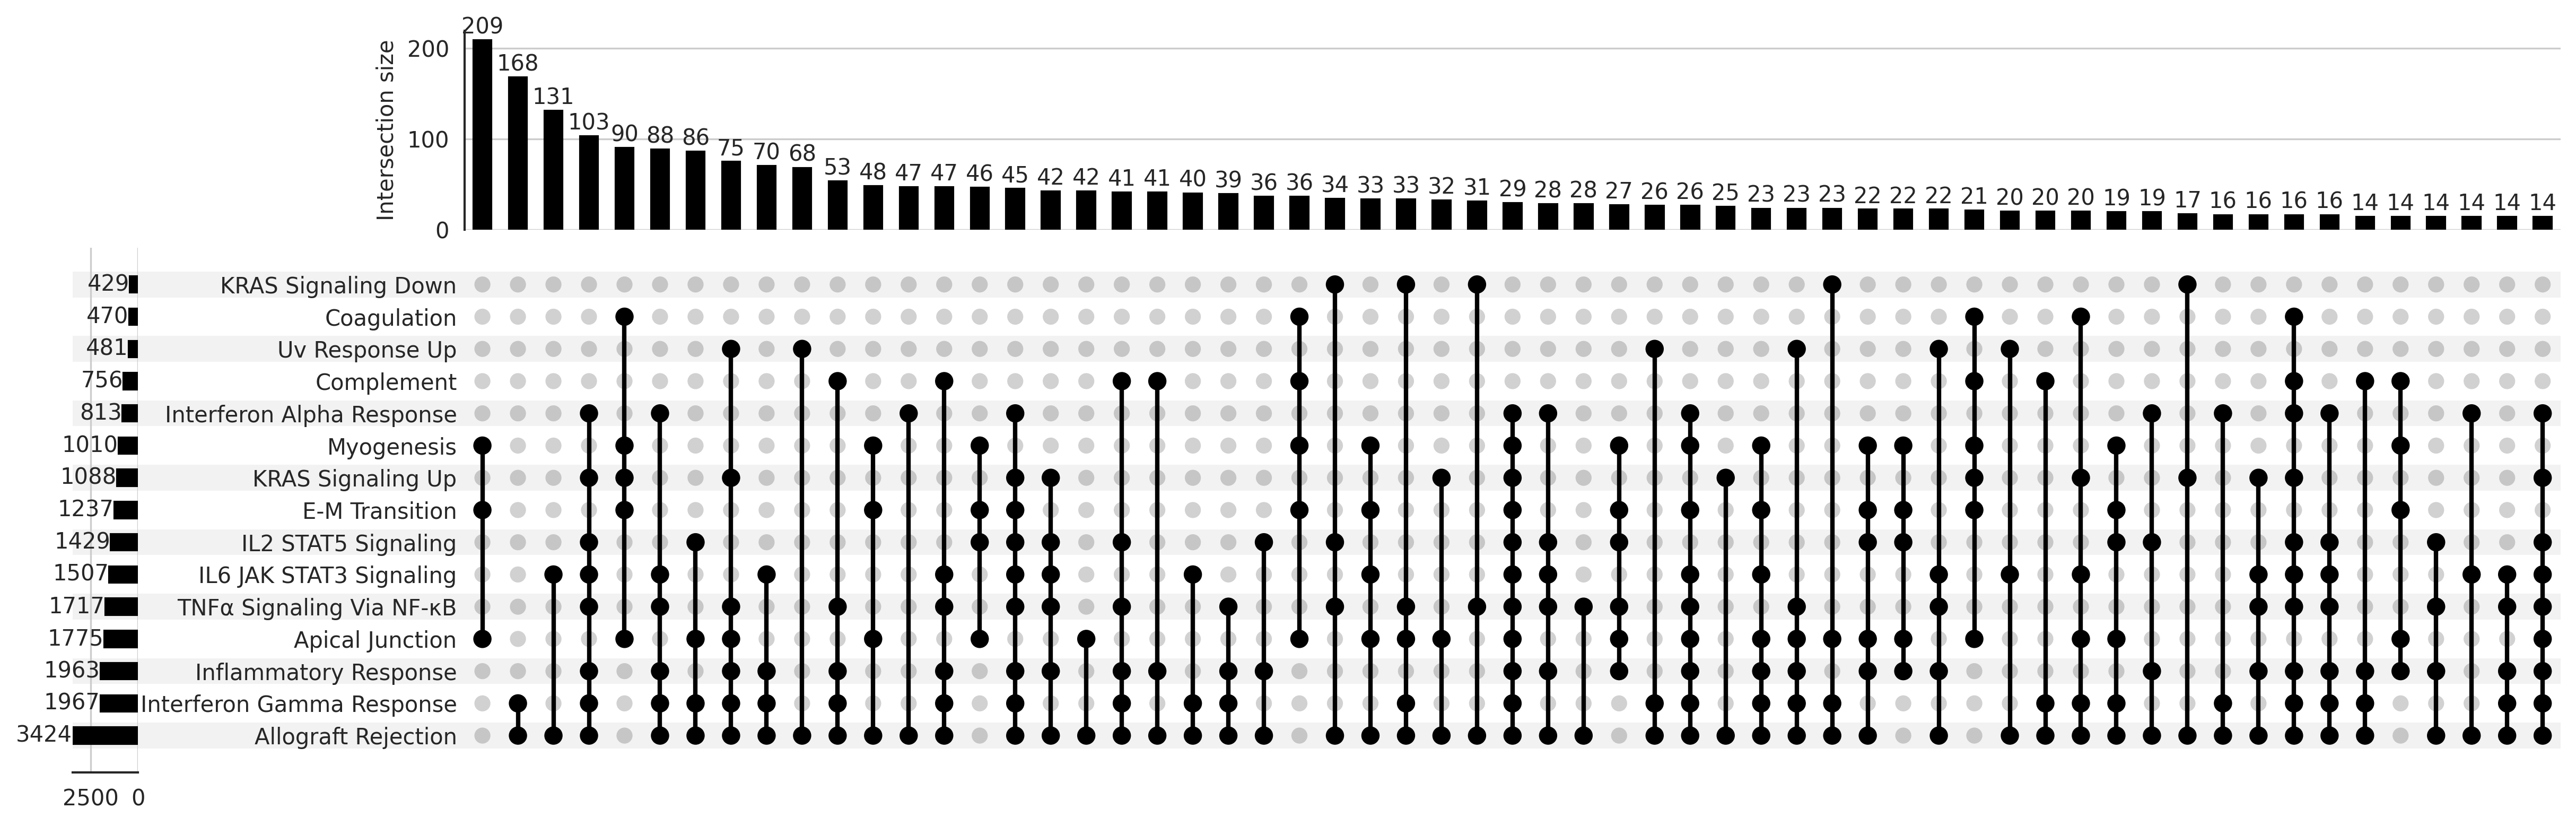

In [25]:
from upsetplot import UpSet, from_memberships, from_indicators, plot

fig, ax = plt.subplots(1,1, figsize=(20, 20), dpi=300)


top_N = 15
#max_n_bars = 51

top_hallmarks = tumor_cliques[all_hallmarks].sum().sort_values().tail(top_N)[::-1].index

upset_data = from_indicators(
    #all_hallmarks,
    top_hallmarks,
    data=tumor_cliques
)

#upset = UpSet(
#
#)

plot(
    data=upset_data,
    sort_by='cardinality',
    #min_subset_size=25,
    max_subset_rank=60,
    min_degree=2,
    #facecolor=tcolor,
    show_counts=True,
    fig=fig,
    element_size=20.75,
)

for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_xticks([])
ax.set_yticks([])
 
plt.suptitle(f"", y=1.05, fontsize=15)
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/crosstalk/hallmarks/hallmarks_upset.pdf', dpi=300, bbox_inches='tight')
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/crosstalk/hallmarks/hallmarks_upset.png', dpi=300, bbox_inches='tight')

plt.show()


In [26]:
all_motifs = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/both/motifs.csv')
motifs_to_plot = all_motifs.query('Type in ["3_clique", "4_clique"]')['Interaction']
#motifs_to_plot = all_motifs['Interaction']

In [27]:
net = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/network_filtered.csv')
net['sign'] = np.where(net['auroc'] > 0.5, +1, -1)
net = net[['complex1', 'complex2', 'sign']]

In [28]:
net_mirror = net.copy()
net_mirror.columns = ['complex2', 'complex1', 'sign']
net_mirror = net_mirror[['complex1', 'complex2', 'sign']]
net = pd.concat([net, net_mirror]).set_index(['complex1', 'complex2'])
net = net['sign']

In [29]:
motifs_to_plot = motifs_to_plot.str.split('&', expand=True)
motifs_to_plot.columns = ['int1', 'int2']

In [30]:
motifs_to_plot['sign1'] = motifs_to_plot['int1'].apply(lambda x: net.loc[(x.split('+')[0],x.split('+')[1])])
motifs_to_plot['sign2'] = motifs_to_plot['int2'].apply(lambda x: net.loc[(x.split('+')[0],x.split('+')[1])])
motifs_to_plot = motifs_to_plot.set_index(['int1', 'int2'])

In [31]:
motifs_to_plot['result'] = 'Discordant'
motifs_to_plot['result'] = np.where((motifs_to_plot.sign1 == 1 ) & (motifs_to_plot.sign2 == 1 ), 'Tumor', motifs_to_plot['result'])
motifs_to_plot['result'] = np.where((motifs_to_plot.sign1 == -1) & (motifs_to_plot.sign2 == -1), 'Normal', motifs_to_plot['result'])

In [32]:
counts = motifs_to_plot['result'].value_counts()

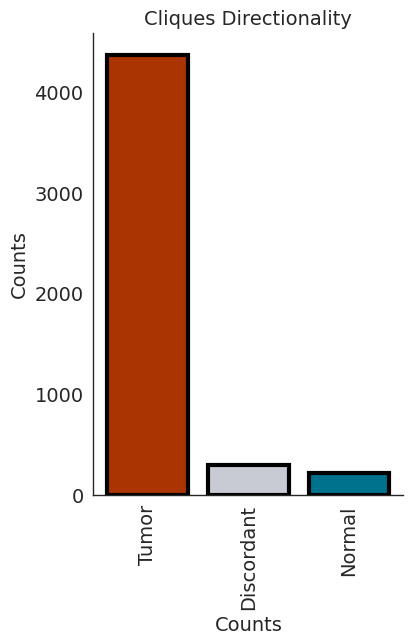

In [33]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.image as mpimg
import os

fs = 14

# Create the custom colormap and normalize the z-scores
cmap = mcolors.LinearSegmentedColormap.from_list('custom_gradient', ['white', tcolor])
colors = cmap(norm(counts))

# Create the bar plot
fig, ax = plt.subplots(1, 1, figsize=(4, 6))

bars = ax.bar(
    x=counts.index,
    height=counts.values,
    color=[tcolor, lightgray, ncolor],
    edgecolor='k',
    linewidth=3,
)

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=fs)

# Customize the plot
ax.set_title("Cliques Directionality", fontsize=fs)
ax.set_xlabel("Condition", fontsize=fs)
ax.set_ylabel("Counts", fontsize=fs)
plt.xticks(rotation=90)
ax.set_xlabel('Counts')


#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/crosstalk/cliques_directionality.pdf', bbox_inches='tight', dpi=300)
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/crosstalk/cliques_directionality.png', bbox_inches='tight')

plt.show()


In [34]:
tdens = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor/motifs_densities.csv' , index_col='interaction').query('motif == "4_clique"')
ndens = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/normal/motifs_densities.csv', index_col='interaction').query('motif == "4_clique"')
bdens = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/both/motifs_densities.csv'  , index_col='interaction').query('motif == "4_clique"')

In [35]:
# Get more co-expressed in normal cliques
ndf = ndens[[col for col in ndens.columns if col not in ['motif', 'avg_all', 'avg_normal', 'avg_tumor']]].melt(var_name='tissue', ignore_index=False).reset_index()
ndf['condition'] = np.where(ndf['tissue'].str.startswith('normal_'), 'normal', 'tumor')
ndf['tissue'] = ndf['tissue'].str.replace('normal_', '').str.replace('tumor_', '').str.replace('.csv', '')

# Get more co-expressed in tumor cliques
tdf = tdens[[col for col in tdens.columns if col not in ['motif', 'avg_all', 'avg_normal', 'avg_tumor']]].melt(var_name='tissue', ignore_index=False).reset_index()
tdf['condition'] = np.where(tdf['tissue'].str.startswith('tumor_'), 'tumor', 'normal')
tdf['tissue'] = tdf['tissue'].str.replace('tumor_', '').str.replace('normal_', '').str.replace('.csv', '')

# Merge
mergedf = pd.concat([ndf, tdf])

# Only keep tissues with both tumor and normal
counts2 = mergedf.groupby(['interaction', 'tissue'])['condition'].nunique()
tissues = counts2[counts2 == 2].reset_index().tissue.unique()
mergedf = mergedf.query('tissue in @tissues')

# Pivot the data
pivot_df = mergedf.pivot_table(
    index=["interaction", "tissue"],  # Use interaction and tissue as indices
    columns="condition",             # Pivot on condition (tumor/normal)
    values="value"                   # Use value column to calculate differences
).reset_index()

# Compute the difference (tumor - normal)
pivot_df['difference'] = pivot_df['tumor'] - pivot_df['normal']
pivot_df = pivot_df.query('normal !=0  and tumor !=0')

pivot_df = pivot_df.sort_values(by='difference')

In [36]:
import networkx as nx
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt

def plot_gene_network(genes, tissue, savepath=None, edge_scaling=20, node_size=3500, linewidths=3, fs=16, min_width=0.1):
    """
    Plots two network graphs: one based on ncorr and one based on tcorr.

    Parameters:
        genes (list): List of gene names to consider for the graph.
        edge_scaling (int, optional): Multiplier for edge thickness.
        min_width (float, optional): Minimum edge width to ensure all edges are visible.
        node_size (int, optional): Size of the nodes. 
        linewidths (int, optional): Line width for node borders.
        fs (int, optional): Font size for labels.
    """
    global ncorr, tcorr  # Access the global variables ncorr and tcorr
    
    tissue = tissue.title().replace(' And ', ' & ')
    edgecolor = 'k'

    G_nc = nx.Graph()
    G_tc = nx.Graph()

    G_nc.add_nodes_from(genes)
    G_tc.add_nodes_from(genes)

    # Add edges with all correlations (even negative)
    for i in range(len(genes)):
        for j in range(i + 1, len(genes)):
            G_nc.add_edge(genes[i], genes[j], weight=ncorr.loc[genes[i], genes[j]])
            G_tc.add_edge(genes[i], genes[j], weight=tcorr.loc[genes[i], genes[j]])

    fig, axes = plt.subplots(2, 1, figsize=(5, 10))
    
    for ax, G, corr_matrix, title in zip(axes, [G_tc, G_nc], [tcorr, ncorr], ['Tumor', 'Normal']):
        ax.axis("off")

        # Get raw weights and apply edge scaling, clipping to min_width
        weights = [G[u][v]['weight'] for u, v in G.edges()]
        scaled_weights = [max(abs(w) * edge_scaling, min_width) for w in weights]

        pos = {
            genes[0]: (0.8, 0.8), genes[1]: (0.2, 0.8),
            genes[2]: (0.8, 0.2), genes[3]: (0.2, 0.2)
        }

        # Highlight specific edges (CCI edges) only if strong enough
        if genes[1] in G[genes[0]]:
            weight = abs(G[genes[0]][genes[1]]['weight'])
            if weight * edge_scaling > min_width:
                nx.draw_networkx_edges(
                    G, pos,
                    edgelist=[(genes[0], genes[1])],
                    width=weight * edge_scaling,
                    alpha=1,
                    edge_color='C1',
                    ax=ax
                )

        if genes[3] in G[genes[2]]:
            weight = abs(G[genes[2]][genes[3]]['weight'])
            if weight * edge_scaling > min_width:
                nx.draw_networkx_edges(
                    G, pos,
                    edgelist=[(genes[2], genes[3])],
                    width=weight * edge_scaling,
                    alpha=1,
                    edge_color='C0',
                    ax=ax
                )

        # Draw full graph
        nx.draw(
            G,
            pos,
            with_labels=False,
            node_color=2 * ['C1'] + 2 * ['C0'],
            edge_color=edgecolor,
            width=scaled_weights,
            node_size=node_size,
            font_size=fs,
            edgecolors=edgecolor,
            linewidths=linewidths,
            ax=ax
        )

        # Add custom text labels with outline
        for node, (x, y) in pos.items():
            label = node.replace("_", "\n")
            text = ax.text(
                x, y, label,
                fontsize=fs,
                ha='center', va='center',
                color='black'
            )
            text.set_path_effects([
                path_effects.Stroke(linewidth=8, foreground='white'),
                path_effects.Normal()
            ])

        # Edge label formatting: show ≤0 if abs(weight) < 0.01
        labels = nx.get_edge_attributes(G, "weight")
        formatted_labels = {
            edge: ("≤0" if abs(weight) <= 0 else f"{weight:.2f}")
            for edge, weight in labels.items()
        }

        diagonal_labels = {}
        other_labels = {}

        for k, v in formatted_labels.items():
            if (genes[0] in k and genes[3] in k) or (genes[1] in k and genes[2] in k):
                diagonal_labels[k] = v
            else:
                other_labels[k] = v

        nx.draw_networkx_edge_labels(G, pos, edge_labels=diagonal_labels, label_pos=0.25, ax=ax)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=other_labels, label_pos=0.5, ax=ax)

        ax.set_title(f'{tissue}, {title}', fontsize=fs, y=0.96)

    plt.subplots_adjust(left=-0.05, right=1.05, top=1.05, bottom=-0.05)
    
    if savepath is not None:
        plt.savefig(savepath + '.pdf', bbox_inches='tight', dpi=300)
        plt.savefig(savepath + '.png', bbox_inches='tight', dpi=300)
    else:
        plt.show()


In [ ]:
import os
import re

# === MANUAL INPUT ===
interaction = 'CD86+CTLA4&CD274+PDCD1'  # <-- your chosen interaction
tissue = 'skin'                        # <-- your chosen tissue

genes = re.split('[+&]', interaction)

# === PATHS ===
corr_path = '/home/lnemati/pathway_crosstalk/data/networks'

# === LOAD CORRELATION MATRICES FOR SELECTED TISSUE ===
ncorr = network_to_adj(os.path.join(corr_path, 'normal', tissue + '.csv.gz'))
tcorr = network_to_adj(os.path.join(corr_path, 'tumor',  tissue + '.csv.gz'))

# === PLOT NETWORK ===
try:
    plot_gene_network(genes, tissue, savepath=None)
except Exception as e:
    print(f"Failed to plot {interaction} in {tissue}: {e}")


In [39]:
import os
import re
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import networkx as nx

def plot_multiple_gene_networks(interactions_and_tissues, corr_path, savepath=None, edge_scaling=20, node_size=5000, linewidths=3, fs=21, min_width=0.1):
    """
    Plots multiple gene interaction networks as columns with tumor (top) and normal (bottom) rows.

    Parameters:
        interactions_and_tissues (list): List of (interaction_string, tissue) tuples.
        corr_path (str): Path to correlation matrices.
        savepath (str): If provided, saves the figure.
    """
    num_cols = len(interactions_and_tissues)
    fig, axes = plt.subplots(2, num_cols, figsize=(5 * num_cols, 10))
    if num_cols == 1:
        axes = axes.reshape(2, 1)  # Make 2x1 if only one column

    for col, (interaction, tissue) in enumerate(interactions_and_tissues):
        genes = re.split(r'[+&]', interaction)
        
        # Manually reorder:
        if genes == ['CCL2', 'CCR2', 'PDCD1', 'PDCD1LG2']:
            genes = ['CCL2', 'CCR2' , 'PDCD1LG2', 'PDCD1']
            
        tissue_clean = tissue.title().replace(' And ', ' & ')

        # Load correlation matrices
        ncorr = network_to_adj(os.path.join(corr_path, 'normal', tissue + '.csv.gz'))
        tcorr = network_to_adj(os.path.join(corr_path, 'tumor',  tissue + '.csv.gz'))

        for row, (corr_matrix, title) in enumerate([(tcorr, 'Tumor'), (ncorr, 'Normal')]):
            G = nx.Graph()
            G.add_nodes_from(genes)
            for i in range(len(genes)):
                for j in range(i + 1, len(genes)):
                    G.add_edge(genes[i], genes[j], weight=corr_matrix.loc[genes[i], genes[j]])

            ax = axes[row, col]
            ax.axis("off")

            weights = [G[u][v]['weight'] for u, v in G.edges()]
            scaled_weights = [max(abs(w) * edge_scaling, min_width) for w in weights]

            pos = {
                genes[0]: (0.66, 0.66), genes[1]: (0.33, 0.66),
                genes[2]: (0.66, 0.33), genes[3]: (0.33, 0.33)
            }

            # Highlight key edges
            if genes[1] in G[genes[0]]:
                weight = abs(G[genes[0]][genes[1]]['weight'])
                if weight * edge_scaling > min_width:
                    nx.draw_networkx_edges(
                        G, pos, edgelist=[(genes[0], genes[1])],
                        width=weight * edge_scaling, alpha=1,
                        edge_color='C1', ax=ax
                    )

            if genes[3] in G[genes[2]]:
                weight = abs(G[genes[2]][genes[3]]['weight'])
                if weight * edge_scaling > min_width:
                    nx.draw_networkx_edges(
                        G, pos, edgelist=[(genes[2], genes[3])],
                        width=weight * edge_scaling, alpha=1,
                        edge_color='C0', ax=ax
                    )

            nx.draw(
                G, pos, with_labels=False,
                node_color=2 * ['C1'] + 2 * ['C0'],
                edge_color='k', width=scaled_weights,
                node_size=node_size, font_size=fs,
                edgecolors='k', linewidths=linewidths, ax=ax
            )

            for node, (x, y) in pos.items():
                label = node.replace("_", "\n")
                text = ax.text(x, y, label, fontsize=fs, ha='center', va='center', color='black')
                text.set_path_effects([
                    path_effects.Stroke(linewidth=8, foreground='white'),
                    path_effects.Normal()
                ])

            # Edge labels (≤0 if very small)
            labels = nx.get_edge_attributes(G, "weight")
            formatted_labels = {
                edge: ("≤0" if abs(weight) < 0.01 else f"{weight:.2f}")
                for edge, weight in labels.items()
            }

            diag_labels = {}
            other_labels = {}
            for k, v in formatted_labels.items():
                if (genes[0] in k and genes[3] in k) or (genes[1] in k and genes[2] in k):
                    diag_labels[k] = v
                else:
                    other_labels[k] = v

            nx.draw_networkx_edge_labels(G, pos, edge_labels=diag_labels, label_pos=0.25, ax=ax, font_size=fs)
            nx.draw_networkx_edge_labels(G, pos, edge_labels=other_labels, label_pos=0.5, ax=ax, font_size=fs)

            ax.set_title(f'{tissue_clean}, {title}', fontsize=fs, y=0.96)

    plt.subplots_adjust(left=-0.11, right=1.11, top=1.1, bottom=-0.1, wspace=0.06, hspace=0.015)

    if savepath:
        plt.savefig(savepath + '.pdf', bbox_inches='tight', dpi=300)
        plt.savefig(savepath + '.png', bbox_inches='tight', dpi=300)
    else:
        plt.show()


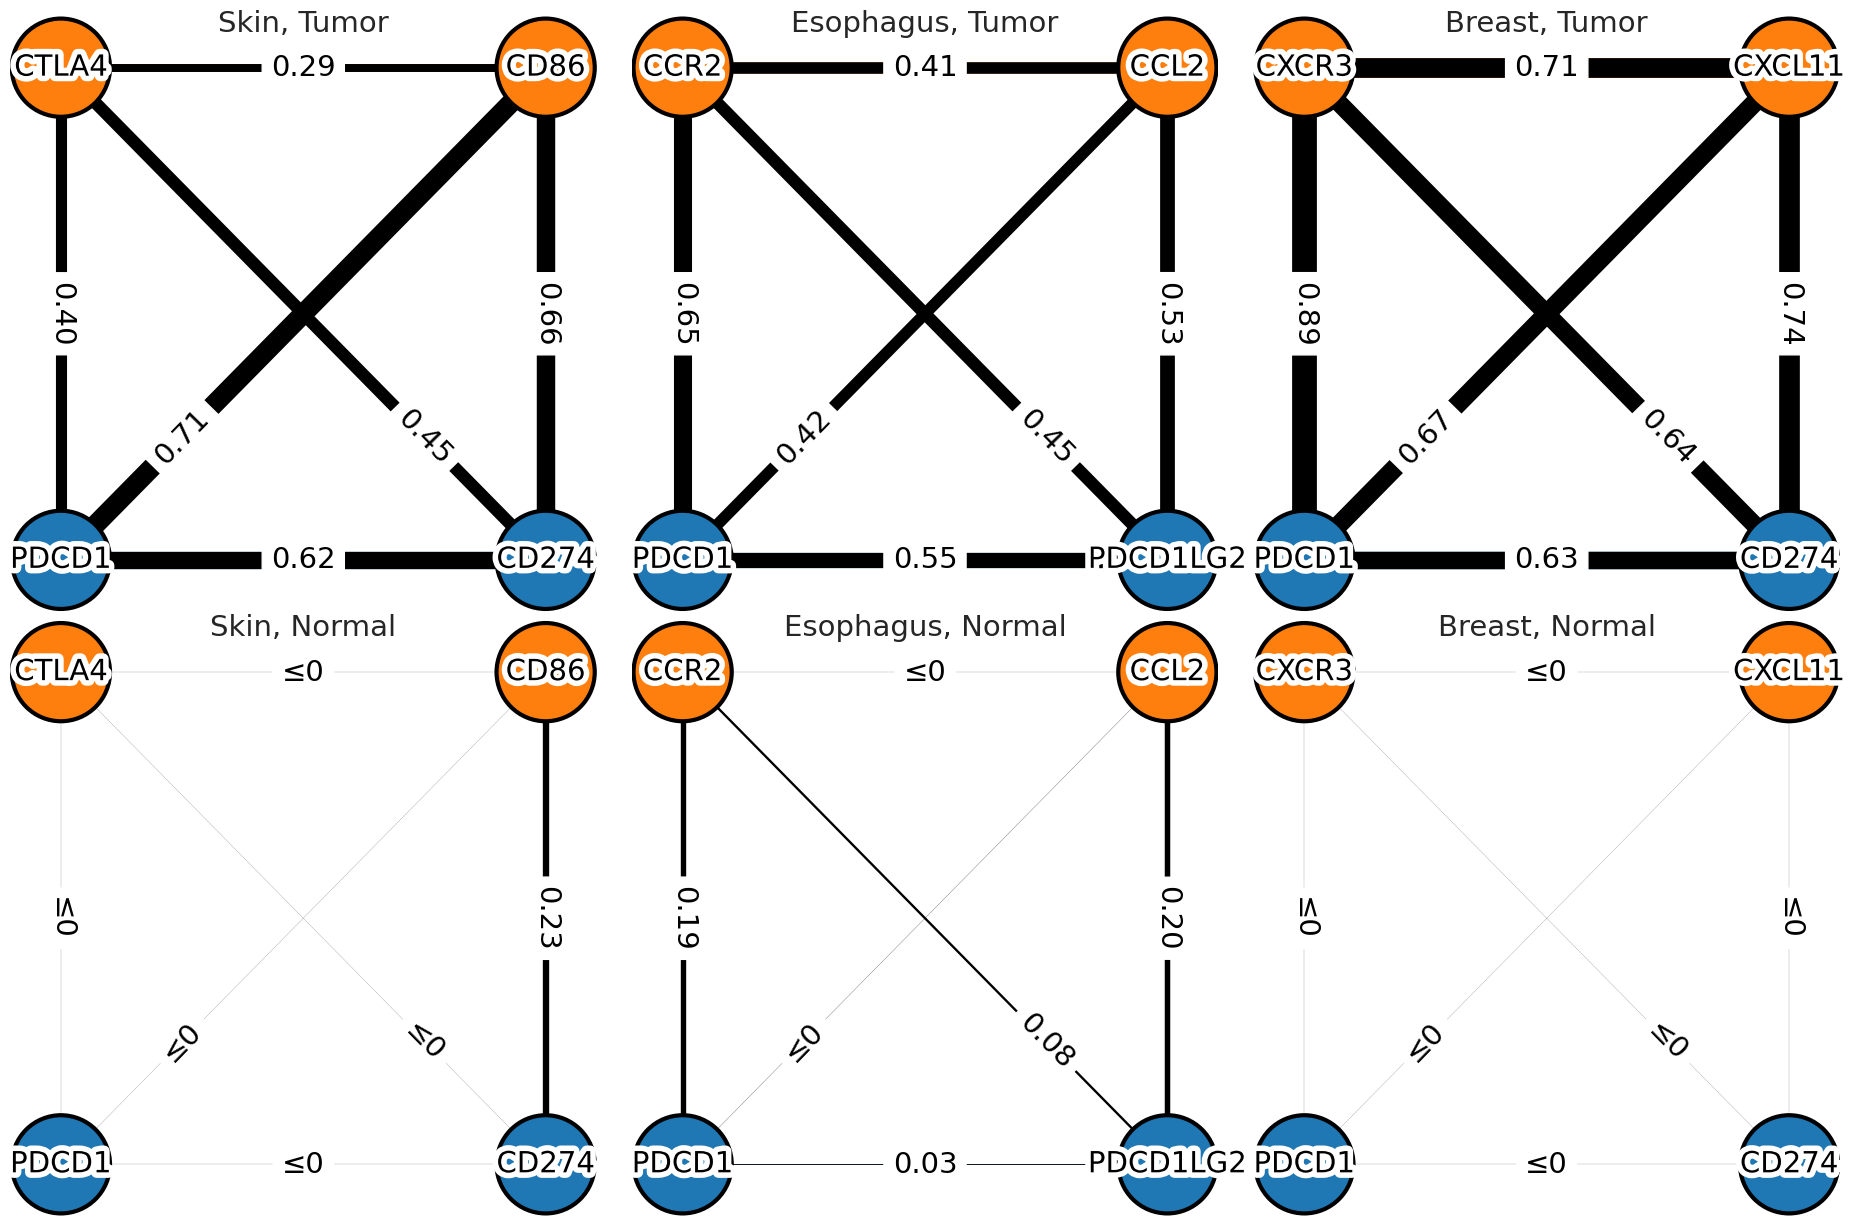

In [40]:
corr_path = '/home/lnemati/pathway_crosstalk/data/networks'

interactions_and_tissues = [
    ('CD86+CTLA4&CD274+PDCD1', 'skin'),
    ('CCL2+CCR2&PDCD1+PDCD1LG2', 'esophagus'), #suppl
    #('CXCL11+CXCR3&CD274+PDCD1', 'stomach'),
    ('CXCL11+CXCR3&CD274+PDCD1', 'breast'),
]

plot_multiple_gene_networks(
    interactions_and_tissues,
    corr_path,
    savepath="/home/lnemati/pathway_crosstalk/results/figures/crosstalk/immune_checkpoints_cliques_rectangle"
)


In [41]:
# (CD86+CTLA4&CD274+PDCD1, skin)
# (CCL2+CCR2&PDCD1+PDCD1LG2) esophagus # supple, diff ligand
# (CXCL11+CXCR3&CD274+PDCD1, stomach)
# (CXCL11+CXCR3&CD274+PDCD1, breast)
# (CXCL11+CXCR3&CD274+PDCD1, lung) #supplementary
# (CXCL11+CXCR3&CD274+PDCD1, skin)
# (TNF+TNFRSF1B&CD69+KLRB1, breast) #supplementary
# (COL10A1+ITGA2_ITGB1&ACVR1_TGFBR1_TGFBR2+TGFB3, stomach) # supplementary
# (COL10A1+ITGA11_ITGB1&SFRP4+WNT2, stomach) #supplementary
# (COL10A1+ITGA11_ITGB1&FN1+ITGAV_ITGB5, pancreas) #supplementary


# Drugs

In [42]:
import xml.etree.ElementTree as ET
#tree = ET.parse('/home/carora/full database.xml')

tree = ET.parse('/projects/bioinformatics/DB/DRUGBANK/v5.1.13/full database.xml')

In [43]:
# Load cliques
tumor_cliques = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor/motifs.csv')
tumor_cliques = tumor_cliques.query('Type in ["3_clique", "4_clique"]')
tumor_cliques['all_genes'] = tumor_cliques['Interaction'].apply(lambda x: re.split(r'[+_^&]', x))
tumor_cliques['int1'] = tumor_cliques['Interaction'].apply(lambda x: re.split(r'[+_^]', x.split('&')[0]))
tumor_cliques['int2'] = tumor_cliques['Interaction'].apply(lambda x: re.split(r'[+_^]', x.split('&')[1]))


In [44]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET

# tree = ET.parse('/home/carora/full database.xml')  # Ensure tree is defined

def get_drug_dbank(genes, tree=tree):
    root = tree.getroot()
    ns = {'db': 'http://www.drugbank.ca'}
    drugbank = root

    results = []
    genes_set = set(genes)  # Faster lookup than list

    for drug in drugbank.findall('.//db:drug', ns):
        drug_name_el = drug.find('.//db:name', ns)
        drug_name = drug_name_el.text if drug_name_el is not None else None
        groups = [g.text for g in drug.findall('.//db:groups/db:group', ns)]
        valid_approvals = [g for g in groups if g in {'approved', 'investigational'}]

        if not valid_approvals:
            continue

        for target in drug.findall('.//db:targets/db:target', ns):
            actions = [a.text if a is not None else np.nan for a in target.findall('.//db:actions/db:action', ns)]
            proteins = target.findall('.//db:polypeptide', ns)

            for protein in proteins:
                gene_symbol_el = protein.find('.//db:gene-name', ns)
                if gene_symbol_el is None:
                    continue

                gene_symbol = gene_symbol_el.text
                if gene_symbol not in genes_set:
                    continue

                for approval in valid_approvals:
                    for action in actions:
                        results.append({
                            'gene': gene_symbol,
                            'drug': drug_name,
                            'action': action,
                            'approval': approval
                        })

    return pd.DataFrame(results).drop_duplicates().reset_index(drop=True)

    # Load hallmark gene sets
def read_gmt(file_path):
    gene_sets = {}
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 3:
                gene_sets[parts[0]] = set(parts[2:])
    return gene_sets
all_clique_genes = list(set(tumor_cliques.all_genes.sum()))
drugs_df = get_drug_dbank(all_clique_genes)

# Load hallmark data
hallmarks_path = '/home/lnemati/resources/msigdb_hallmarks/h.all.v2024.1.Hs.symbols.gmt'
hallmarks = read_gmt(hallmarks_path)

drugs_df['hallmarks'] = drugs_df['gene'].apply(
    lambda gene: [h for h, genes in hallmarks.items() if gene in genes]
)

# Explode the hallmarks column to create a new row for each hallmark
drugs_exploded = drugs_df.explode('hallmarks').reset_index(drop=True)

In [45]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from collections import defaultdict

#tree = ET.parse('/home/carora/full database.xml')

def get_drug_dbank(genes, tree=tree):
    root = tree.getroot()
    ns = {'db': 'http://www.drugbank.ca'}
    drugbank = root

    genes_set = set(genes)
    grouped_results = defaultdict(lambda: {'actions': set(), 'approvals': set()})

    for drug in drugbank.findall('.//db:drug', ns):
        drug_name_el = drug.find('.//db:name', ns)
        drug_name = drug_name_el.text if drug_name_el is not None else None
        groups = [g.text for g in drug.findall('.//db:groups/db:group', ns)]
        valid_approvals = [g for g in groups if g in {'approved', 'investigational'}]

        if not valid_approvals:
            continue

        for target in drug.findall('.//db:targets/db:target', ns):
            actions = [a.text if a is not None else np.nan for a in target.findall('.//db:actions/db:action', ns)]
            proteins = target.findall('.//db:polypeptide', ns)

            for protein in proteins:
                gene_symbol_el = protein.find('.//db:gene-name', ns)
                if gene_symbol_el is None:
                    continue

                gene_symbol = gene_symbol_el.text
                if gene_symbol not in genes_set:
                    continue

                key = (gene_symbol, drug_name)
                grouped_results[key]['actions'].update(actions)
                grouped_results[key]['approvals'].update(valid_approvals)

    # Format final results
    formatted_results = [
        {
            'gene': gene,
            'drug': drug,
            'action': sorted(list(data['actions'])),
            'approval': sorted(list(data['approvals']))
        }
        for (gene, drug), data in grouped_results.items()
    ]

    return pd.DataFrame(formatted_results).reset_index(drop=True)

def read_gmt(file_path):
    gene_sets = {}
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 3:
                gene_sets[parts[0]] = set(parts[2:])
    return gene_sets

hallmarks_path = '/home/lnemati/resources/msigdb_hallmarks/h.all.v2024.1.Hs.symbols.gmt'
hallmarks = read_gmt(hallmarks_path)

all_clique_genes = list(set(tumor_cliques.all_genes.sum()))

drugs_df = get_drug_dbank(all_clique_genes)

drugs_df['hallmarks'] = drugs_df['gene'].apply(
    lambda gene: [h for h, genes in hallmarks.items() if gene in genes]
)

drugs_exploded = drugs_df.explode('approval').explode('action').explode('hallmarks').reset_index(drop=True)

drugs_df.to_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor/drugs.csv', index=False)
drugs_exploded.to_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor/drugs_exploded.csv', index=False)

In [46]:
from itertools import product
import pandas as pd

# Clean the drug dataset: keep only drugs with action and approved status
clean_df = drugs_df.copy()
clean_df = clean_df[clean_df.action.apply(lambda x: len(x) > 0)]
clean_df = clean_df[clean_df.approval.apply(lambda x: 'approved' in x)]

# Create lookup dictionaries
drug_to_action = clean_df.groupby('drug')['action'].first().to_dict()
drug_to_targets = clean_df.groupby('drug')['gene'].apply(list).to_dict()

all_drug_pairs = []

for idx, row in tumor_cliques.iterrows():
    clique = row.Interaction
    genes1 = row.int1
    genes2 = row.int2

    # Ensure genes1 and genes2 are lists (e.g., if stored as strings)
    if isinstance(genes1, str):
        genes1 = eval(genes1)
    if isinstance(genes2, str):
        genes2 = eval(genes2)

    # Filter drugs by genes in each group
    drugs1 = clean_df.query('gene in @genes1')
    drugs2 = clean_df.query('gene in @genes2')

    # Create unique drug pairs
    combinations = product(drugs1['drug'], drugs2['drug'])

    for drug1, drug2 in combinations:
        if drug1 != drug2:
            action1 = drug_to_action.get(drug1, [])
            action2 = drug_to_action.get(drug2, [])
            targets1 = drug_to_targets.get(drug1, [])
            targets2 = drug_to_targets.get(drug2, [])
            
            # Also make sure they are not targetting the same gene
            if not set(targets1).intersection(genes1).issubset(set(targets2).intersection(genes2)):

                all_drug_pairs.append({
                    'clique': clique,
                    'drug1': drug1,
                    'targets1': targets1,
                    'action1': action1,
                    'drug2': drug2,
                    'targets2': targets2,
                    'action2': action2,
                    'actions_combined': sorted(set(action1 + action2))
                })

# Create the final DataFrame
drug_pairs_df = pd.DataFrame(all_drug_pairs)

In [47]:
antibodies = pd.read_csv('/home/lnemati/pathway_crosstalk/data/antibodies.tsv', sep='\t', index_col=0, header=None)
antibodies = antibodies.index

In [48]:
drug_pairs_df['type1'] = 'Small Molecule'
drug_pairs_df['type2'] = 'Small Molecule'
drug_pairs_df.loc[drug_pairs_df.drug1.isin(antibodies), 'type1'] = 'Antibody'
drug_pairs_df.loc[drug_pairs_df.drug2.isin(antibodies), 'type2'] = 'Antibody'

In [49]:
drug_pairs_df['unique_id'] = drug_pairs_df[['clique', 'drug1', 'drug2']].apply(lambda x: tuple(sorted(x)), axis=1)
drug_pairs_df = drug_pairs_df[~drug_pairs_df.unique_id.duplicated()]
drug_pairs_df = drug_pairs_df[['clique', 'drug1', 'targets1', 'type1', 'drug2', 'targets2', 'type2']]

In [50]:
drug_pairs_df.to_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor/approved_drug_pairs.csv', index=False)

In [51]:
# Sort the type pairs alphabetically so ('Antibody', 'Small Molecule') and ('Small Molecule', 'Antibody') are treated the same
sorted_pairs = drug_pairs_df[['type1', 'type2']].apply(lambda x: tuple(sorted(x)), axis=1)

# Count the value occurrences of these sorted tuples
drug_type_counts = sorted_pairs.value_counts()

In [52]:
tumor_cliques

Type                             Interaction   density  \
0     3_clique                     CCL3+CCR1&CCL5+CCR1  0.788580   
1     3_clique                   CD4+HLA-DQA2&CD4+IL16  0.769731   
2     3_clique                     CCL3+CCR1&CCL3+CCR5  0.765212   
3     3_clique                     CCL5+CCR1&CCL5+CCR5  0.763448   
4     3_clique               CD4+HLA-DQA2&CD4+HLA-DRB5  0.762346   
...        ...                                     ...       ...   
4750  4_clique          COL5A3+ITGA11_ITGB1&CD80+CTLA4  0.700838   
4751  4_clique             CD80+CTLA4&FN1+ITGA11_ITGB1  0.697751   
4752  4_clique         COL12A1+ITGA11_ITGB1&CD80+CTLA4  0.697090   
4753  4_clique  COL10A1+ITGA10_ITGB1&TNFRSF11B+TNFSF11  0.696649   
4754  4_clique            CCL22+CCR4&TNFRSF11B+TNFSF11  0.694224   

                                         all_genes                      int1  \
0                         [CCL3, CCR1, CCL5, CCR1]              [CCL3, CCR1]   
1                       [CD4, HLA-DQA2, CD4, IL16]           [CD4, HLA-DQA2]   
2                         [CCL3, CCR1, CCL3, CCR5]              [CCL3, CCR1]   
3                         [CCL5, CCR1, CCL5, CCR5]              [CCL5, CCR1]   
4                   [CD4, HLA-DQA2, CD4, HLA-DRB5]           [CD4, HLA-DQA2]   
...                                            ...                       ...   
4750          [COL5A3, ITGA11, ITGB1, CD80, CTLA4]   [COL5A3, ITGA11, ITGB1]   
4751             [CD80, CTLA4, FN1, ITGA11, ITGB1]             [CD80, CTLA4]   
4752         [COL12A1, ITGA11, ITGB1, CD80, CTLA4]  [COL12A1, ITGA11, ITGB1]   
4753  [COL10A1, ITGA10, ITGB1, TNFRSF11B, TNFSF11]  [COL10A1, ITGA10, ITGB1]   
4754             [CCL22, CCR4, TNFRSF11B, TNFSF11]             [CCL22, CCR4]   

                      int2  
0             [CCL5, CCR1]  
1              [CD4, IL16]  
2             [CCL3, CCR5]  
3             [CCL5, CCR5]  
4          [CD4, HLA-DRB5]  
...                    ...  
4750         [CD80, CTLA4]  
4751  [FN1, ITGA11, ITGB1]  
4752         [CD80, CTLA4]  
4753  [TNFRSF11B, TNFSF11]  
4754  [TNFRSF11B, TNFSF11]  

[4305 rows x 6 columns]

In [53]:
print(drug_pairs_df.clique.nunique())
drug_pairs_df.clique.value_counts().head(10)

1567


clique
FLT1_KDR+VEGFB&TNF+TNFRSF1A              417
FLT1_KDR+PGF&PDGFB+PDGFRA_PDGFRB         357
TNF+TNFRSF1B&CD274+PDCD1                 228
AOC1+HRH1&HNMT+HRH1                      201
PDGFB+PDGFRA_PDGFRB&ITGAV_ITGB6+TGFB1    186
PDGFB+PDGFRB&PDGFB+PDGFRA                185
TNF+TNFRSF1B&CD274+CD80                  171
PDCD1+PDCD1LG2&TNF+TNFRSF1B              171
ITGA4_ITGB1+PLAUR&PDGFB+PDGFRA_PDGFRB    147
ITGA4_ITGB1+VCAM1&TNF+TNFRSF1B           133
Name: count, dtype: int64

In [54]:
sorted_pairs = drug_pairs_df[['drug1', 'drug2']].apply(lambda x: tuple(sorted(x)), axis=1)
print(sorted_pairs.nunique())
sorted_pairs.value_counts().head(10)

5415


(Antithymocyte immunoglobulin (rabbit), Fostamatinib)                        162
(Antithymocyte immunoglobulin (rabbit), Ibalizumab)                          153
(Abatacept, Antithymocyte immunoglobulin (rabbit))                           138
(Antithymocyte immunoglobulin (rabbit), Belatacept)                          138
(Antithymocyte immunoglobulin (rabbit), Nintedanib)                          111
(Antithymocyte immunoglobulin (rabbit), Maraviroc)                           110
(Antithymocyte immunoglobulin (rabbit), Sunitinib)                           103
(Antithymocyte immunoglobulin (rabbit), Erdafitinib)                         103
(Chloroquine, Ibalizumab)                                                    101
(Antithymocyte immunoglobulin (rabbit), Foreskin keratinocyte (neonatal))    100
Name: count, dtype: int64

In [55]:
drug_type_counts.index = drug_type_counts.index.astype(str).str.replace('\'', '').str.replace('(', '').str.replace(')', '').str.replace(', ', '\n&\n')

In [56]:
drug_pairs_df.clique.nunique() / tumor_cliques.shape[0]

0.36399535423925666

In [57]:
targetable_cliques_counts = {}
targetable_cliques_counts['Antibody\n&\nAntibody'] = drug_pairs_df.query('type1 == "Antibody" and type2 == "Antibody"').clique.nunique()
targetable_cliques_counts['Small Molecule\n&\nSmall Molecule'] = drug_pairs_df.query('type1 == "Small Molecule" and type2 == "Small Molecule"').clique.nunique()
targetable_cliques_counts['Antibody\n&\nSmall Molecule'] = drug_pairs_df.query('type1 != type2').clique.nunique()
targetable_cliques_counts = pd.Series(targetable_cliques_counts).sort_values()

targetable_cliques_fracs = targetable_cliques_counts / tumor_cliques.shape[0]

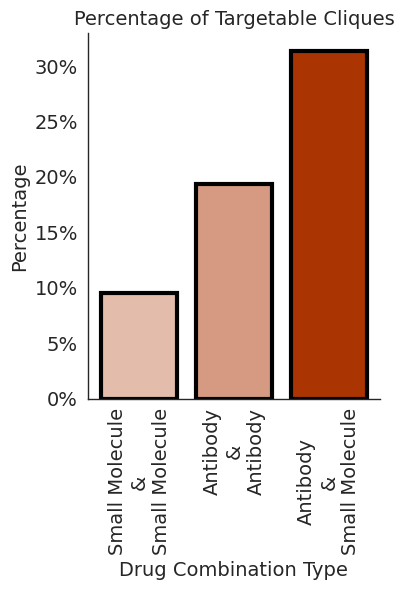

In [58]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mtick  # <-- Add this import
import numpy as np
import pandas as pd

fs = 14
drug_type_counts = drug_type_counts.sort_values()

# Normalize counts for coloring
norm = mcolors.Normalize(vmin=0, vmax=drug_type_counts.max())
cmap = mcolors.LinearSegmentedColormap.from_list('custom_gradient', ['white', tcolor])
colors = cmap(norm(drug_type_counts))

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(4, 6))
bars = ax.bar(
    x=targetable_cliques_fracs.index,
    height=targetable_cliques_fracs.values,
    color=colors,
    edgecolor='k',
    linewidth=3,
)

# Beautify plot
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=fs)
ax.set_title("Percentage of Targetable Cliques", fontsize=fs)
ax.set_xlabel("Drug Combination Type", fontsize=fs)
ax.set_ylabel("Percentage", fontsize=fs)  # Updated label

# Format y-axis as percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

plt.xticks(rotation=90)
plt.tight_layout()

# Show or save
plt.show()


# FULL FIGURE

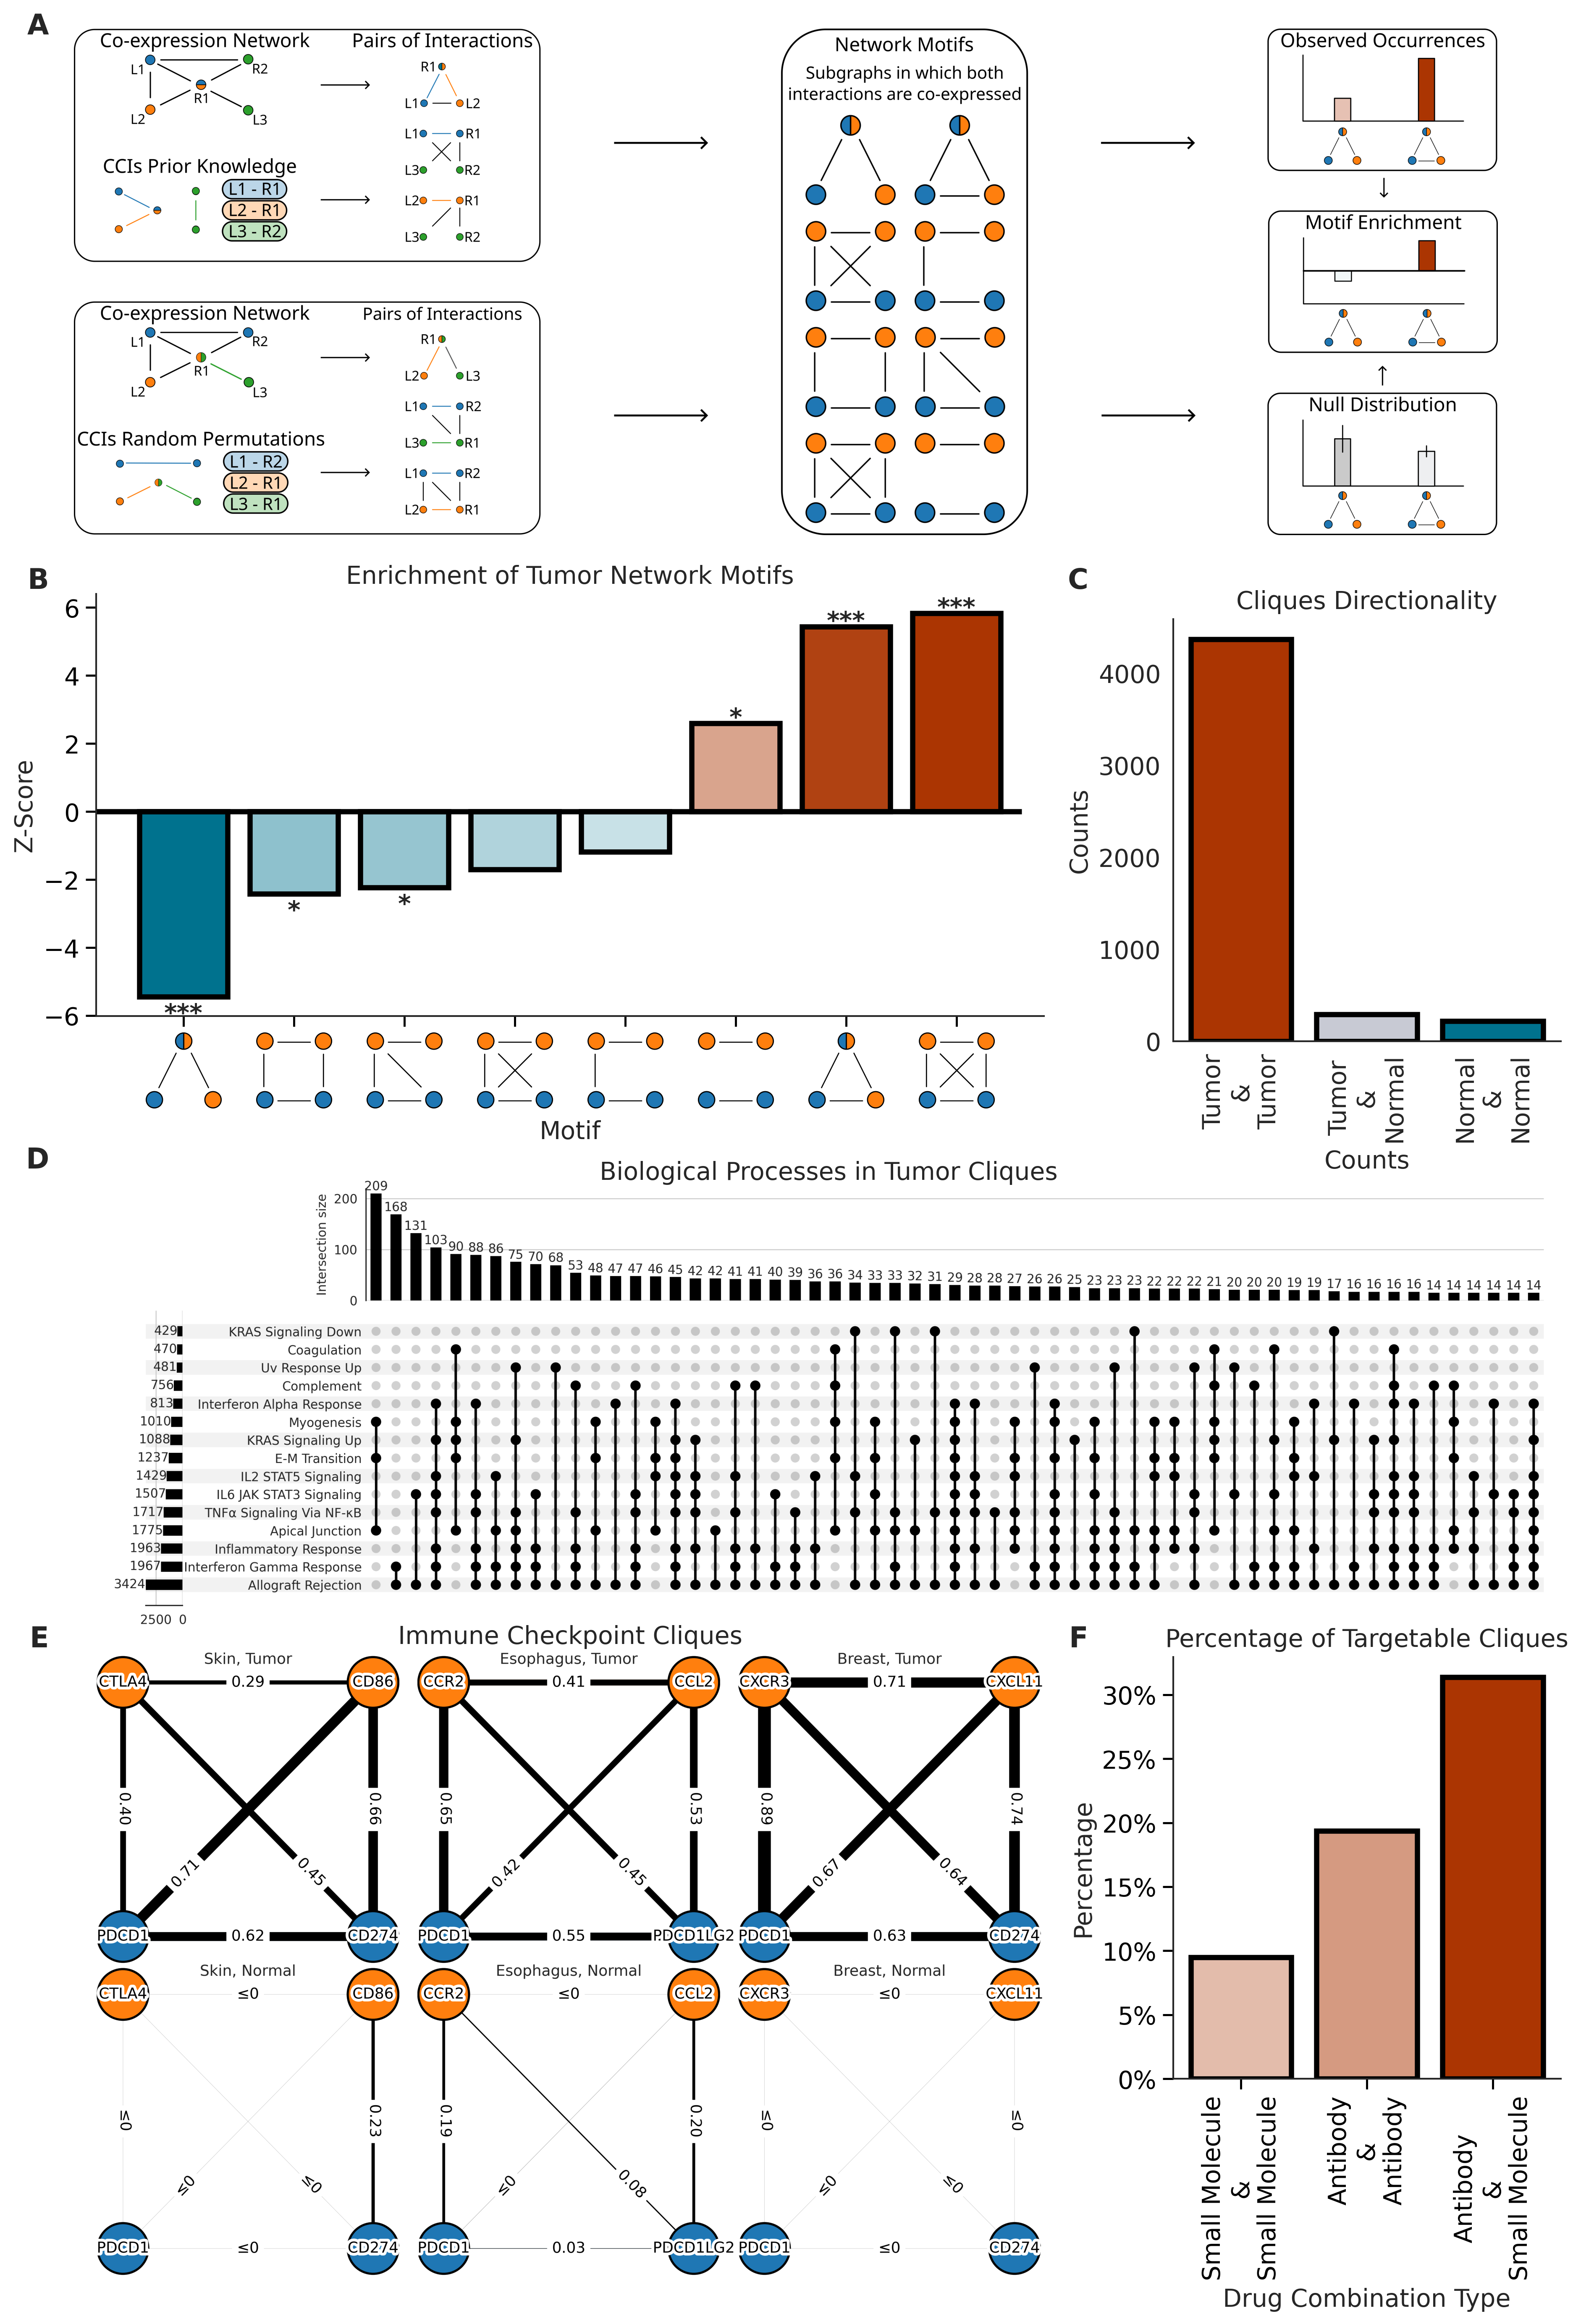

In [69]:
from PIL import Image, ImageChops
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
import matplotlib.ticker as mtick

import os
fs = 14

# Create the figure and the layout
fig, axs = plt.subplot_mosaic(
    """
    AAA
    BBC
    DDD
    EEF
    """,
    dpi=300,
    figsize=(15, 20),
)

#axs['X'].axis('off')

#fig.subplots_adjust(wspace=0.05, hspace=0.3)

## Manually adjust the spacing between B and D
## Shift D down and reduce its height a little to make room for icons under B
pos = {ax: axs[ax].get_position() for ax in axs}

# Create a small vertical gap between B and D
move_up = 0.07

# Move B and C up
for ax in axs:
    if ax in ['B', 'C']:
        axs[ax].set_position([
            pos[ax].x0,
            pos[ax].y0 + 0.01,
            pos[ax].width,
            pos[ax].height
        ])

axs['A'].set_position([
    pos['A'].x0-0.1,
    pos['A'].y0,
    pos['A'].width*1.2,
    pos['A'].height*1.2
])

axs['C'].set_position([
    pos['C'].x0 + pos['F'].width*0.1,
    pos['C'].y0,
    pos['C'].width*0.9,
    pos['C'].height
])
        
axs['D'].set_position([
    pos['D'].x0 - pos['D'].width*0.05,
    pos['D'].y0 - 0.035,
    pos['D'].width*1.1,
    pos['D'].height*1.1
])

axs['E'].set_position([
    pos['E'].x0 - pos['E'].width*0.25,
    pos['E'].y0 - 0.09,
    pos['E'].width*1.5,
    pos['E'].height*1.5
])

axs['F'].set_position([
    pos['F'].x0 + pos['F'].width*0.1,
    pos['F'].y0-0.01,
    pos['F'].width*0.9,
    pos['F'].height
])


############# AXIS A: Workflow ##############

ax = axs['A']
img_path = "/home/lnemati/pathway_crosstalk/data/motifs_icons/motifs_workflow_large.png"

img = Image.open(img_path).convert("RGB")

ax.imshow(img)
ax.axis('off')

############# AXIS B: Motif Enrichment Bar Plot with Icons ##############

ax = axs['B']
fig = ax.figure
img_dir = '/home/lnemati/pathway_crosstalk/data/motifs_icons'

# Get motifs and z-scores
motifs = motifs_z.index
z_scores = motifs_z.values

# Color mapping
cmap = mcolors.LinearSegmentedColormap.from_list('custom_gradient', [ncolor, 'white', tcolor])
norm = mcolors.TwoSlopeNorm(vmin=z_scores.min(), vcenter=0, vmax=z_scores.max())
colors = cmap(norm(z_scores))

# Create bars
bars = ax.bar(motifs, z_scores, color=colors, edgecolor='k', linewidth=3)

# Add zero line
xlim = ax.get_xlim()
#ax.hlines(0, *xlim, color='k', linestyle='-', linewidth=3)
ax.hlines(0, xlim[0], xlim[1]-0.2, color='k', linestyle='-', linewidth=3)
ax.set_xlim(xlim)

# Clean up axes
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=fs)
ax.set_title("Enrichment of Tumor Network Motifs", fontsize=fs)
ax.set_ylabel("Z-Score", fontsize=fs)
ax.set_xticklabels([])
#ax.set_xlabel("Motif", fontsize=fs)
ax.set_xlabel("Motif", fontsize=fs, labelpad=50)

img_width = 0.7
img_height = img_width
y_icons_offset = 0.48

for tick_x, label in zip(ax.get_xticks(), motifs):
    img_path = os.path.join(img_dir, f"{label}.png")
    if os.path.exists(img_path):
        img = mpimg.imread(img_path)
        
        # Create an inset axis centered at the tick
        inset_ax = ax.inset_axes(
            [tick_x - img_width/2, -y_icons_offset, img_width, img_height],  # [x0, y0, width, height]
            transform=ax.get_xaxis_transform(),  # Align with x-axis ticks
            zorder=10
        )
        inset_ax.imshow(img)
        inset_ax.axis('off')

# === Add significance stars ===
sig_levels = {0.001: '***', 0.01: '**', 0.05: '*'}
for bar, z_score, p_val in zip(bars, z_scores, p_values):
    height = bar.get_height()
    sig_symbol = next((s for t, s in sig_levels.items() if p_val <= t), None)
    if sig_symbol:
        text_y = height + 0.15 if z_score > 0 else height - 0.15
        va = 'center' if z_score > 0 else 'top'
        ax.text(bar.get_x() + bar.get_width() / 2, text_y, sig_symbol,
                ha='center', va=va, fontsize=fs, fontweight='bold')

# Final axis cleanup
ax.tick_params(axis='both', which='both', labelsize=fs, direction='out', length=6, width=1.2, colors='black')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Create the custom colormap and normalize the z-scores
cmap = mcolors.LinearSegmentedColormap.from_list('custom_gradient', ['white', tcolor])
colors = cmap(norm(counts))

################ AXIS C: Cliques directionality
ax = axs['C']

counts.index = pd.Series(counts.index).replace({
    'Tumor': 'Tumor\n&\nTumor',
    'Discordant': 'Tumor\n&\nNormal',
    'Normal': 'Normal\n&\nNormal'
}).values

bars = ax.bar(
    x=counts.index,
    height=counts.values,
    color=[tcolor, lightgray, ncolor],
    edgecolor='k',
    linewidth=3,
)

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=fs)

# Customize the plot
ax.set_title("Cliques Directionality", fontsize=fs)
ax.set_xlabel("Condition", fontsize=fs)
ax.set_ylabel("Counts", fontsize=fs)
ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel('Counts')

############# AXIS D: UpSet Plot ##############

# Path to your saved UpSet PNG
upset_img_path = '/home/lnemati/pathway_crosstalk/results/figures/crosstalk/hallmarks/hallmarks_upset.png'

# Load the image
img = mpimg.imread(upset_img_path)

ax = axs['D']
ax.set_title('Biological Processes in Tumor Cliques', fontsize=fs, y=0.96)
ax.imshow(img)
ax.axis('off')  # Hide axes if desired

############# AXIS E: CLiques ##############

ax = axs['E']

# Path to image
#img_path = '/home/lnemati/pathway_crosstalk/results/results/figures/crosstalk/cliques_rectangle.png'
img_path = '/home/lnemati/pathway_crosstalk/results/figures/crosstalk/immune_checkpoints_cliques_rectangle.png'
img = mpimg.imread(img_path)
ax.set_title('Immune Checkpoint Cliques', fontsize=fs, y=0.99)
ax.imshow(img)
ax.axis('off')


################ AXIS F: Drugs ####################

ax = axs['F']

# Normalize counts for coloring
norm = mcolors.Normalize(vmin=0, vmax=drug_type_counts.max())
cmap = mcolors.LinearSegmentedColormap.from_list('custom_gradient', ['white', tcolor])
colors = cmap(norm(drug_type_counts))

# Create the plot
bars = ax.bar(
    x=targetable_cliques_fracs.index,
    height=targetable_cliques_fracs.values,
    color=colors,
    edgecolor='k',
    linewidth=3,
)

# Beautify plot
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=fs)
ax.set_title("Percentage of Targetable Cliques", fontsize=fs)
ax.set_xlabel("Drug Combination Type", fontsize=fs)
ax.set_ylabel("Percentage", fontsize=fs)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

plt.xticks(rotation=90)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)

ax.tick_params(
    axis='both',
    which='both',
    labelsize=fs,
    direction='out',
    length=6,
    width=1.2,
    colors='black'
)

axs['A'].text(0.1, 0.92, 'A', fontsize=16, fontweight='bold', transform=fig.transFigure, va='top', ha='right')
axs['B'].text(0.1, 0.7, 'B', fontsize=16, fontweight='bold', transform=fig.transFigure, va='top', ha='right')
axs['C'].text(0.65, 0.7, 'C', fontsize=16, fontweight='bold', transform=fig.transFigure, va='top', ha='right')
axs['D'].text(0.1, 0.47, 'D', fontsize=16, fontweight='bold', transform=fig.transFigure, va='top', ha='right')
axs['E'].text(0.1, 0.28, 'E', fontsize=16, fontweight='bold', transform=fig.transFigure, va='top', ha='right')
axs['F'].text(0.65, 0.28, 'F', fontsize=16, fontweight='bold', transform=fig.transFigure, va='top', ha='right')

plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig5/fig5.svg', bbox_inches='tight', dpi=300)
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig5/fig5.pdf', bbox_inches='tight', dpi=300)
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig5/fig5.png', bbox_inches='tight', dpi=300)

plt.show()

In [70]:
fig_to_panels(fig, axs, output_dir='/home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig5/panels')

Saved panel '' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig5/panels/
Saved panel 'Enrichment of Tumor Network Motifs' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig5/panels/enrichment_of_tumor_network_motifs
Saved panel 'Cliques Directionality' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig5/panels/cliques_directionality
Saved panel 'Biological Processes in Tumor Cliques' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig5/panels/biological_processes_in_tumor_cliques
Saved panel 'Immune Checkpoint Cliques' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig5/panels/immune_checkpoint_cliques
Saved panel 'Percentage of Targetable Cliques' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig5/panels/percentage_of_targetable_cliques


In [73]:
all_genes = set(tumor_cliques.all_genes.sum())

cliques_per_gene = {}

for gene in all_genes:
    cliques_per_gene[gene] = tumor_cliques.all_genes.apply(lambda x: gene in x).sum()
    
cliques_per_gene = pd.Series(cliques_per_gene).sort_values()[::-1]

In [76]:
cliques_per_gene.head(40)

ITGB1      960
CD4        925
CXCR3      684
ITGA11     434
CCR5       431
CCL8       406
ITGB2      320
CD8A       319
CD8B       317
CD80       293
CXCL13     266
CCR1       244
CCL5       241
ACKR1      240
CTLA4      239
CD86       237
CD28       237
CCR4       236
CXCL11     235
CXCL10     232
HLA-F      231
CCL3       216
HLA-E      208
CXCL9      194
ICAM1      192
CCR2       185
ITGA2      177
CCL22      176
COL10A1    173
SPN        134
PDCD1      128
HLA-C      124
KLRK1      124
ITGA10     123
TNFRSF9    120
TNFSF9     120
ITGAV      119
ENTPD1     117
SELL       111
VSIR       110
dtype: int64

In [42]:
import pandas as pd
import re
from itertools import product

# Load hallmark gene sets
def read_gmt(file_path):
    gene_sets = {}
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 3:
                gene_sets[parts[0]] = set(parts[2:])
    return gene_sets

hallmarks_path = '/home/lnemati/resources/msigdb_hallmarks/h.all.v2024.1.Hs.symbols.gmt'
hallmarks = read_gmt(hallmarks_path)

# Load hallmark data
hallmarks_path = '/home/lnemati/resources/msigdb_hallmarks/h.all.v2024.1.Hs.symbols.gmt'
hallmarks = read_gmt(hallmarks_path)

# Generate readable labels
labels = [label.replace('HALLMARK_', '').replace('_', ' ').title() for label in hallmarks.keys()]

# Mapping for special formatting
replace = {
    'Myc': 'MYC',
    'Kras': 'KRAS',
    'Il2': 'IL2',
    'Stat5': 'STAT5',
    'Il6': 'IL6',
    'Jak': 'JAK',
    'Stat3': 'STAT3',
    'P53': 'P53',
    'Tnfa': 'TNFα',
    'Nfkb': 'NF-κB',
    'Mtorc1': 'MTORC1',
    ' Dn': ' Down',
    'Epithelial Mesenchymal Transition': 'E-M Transition'
}

# Apply replacements to labels
for str1, str2 in replace.items():
    labels = [label.replace(str1, str2) for label in labels]

# Map original hallmark names to cleaned labels
hallmark_name_map = dict(zip(hallmarks.keys(), labels))

# Load cliques
tumor_cliques = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor/motifs.csv')
tumor_cliques = tumor_cliques.query('Type in ["3_clique", "4_clique"]')

# Get interaction string
tumor_cliques['int1'] = tumor_cliques['Interaction'].apply(lambda x: x.split('&')[0])
tumor_cliques['int2'] = tumor_cliques['Interaction'].apply(lambda x: x.split('&')[1])

# Get interaction genes
tumor_cliques['int1_genes'] = tumor_cliques['Interaction'].apply(lambda x: tuple(re.split(r'[+_&]', x.split('&')[0])))
tumor_cliques['int2_genes'] = tumor_cliques['Interaction'].apply(lambda x: tuple(re.split(r'[+_&]', x.split('&')[1])))

all_interactions = list(set(tumor_cliques.int1) & set(tumor_cliques.int2))

interactions_hmks = pd.DataFrame(False, index=all_interactions, columns=hallmarks.keys())

# For each interaction (tuple of genes)
for interaction in interactions_hmks.index:
    genes = set(re.split(r'[+_&]', interaction))
    
    # For each hallmark, check if any gene in the interaction is in the hallmark gene set
    for hallmark, hallmark_genes in hallmarks.items():
        if genes & hallmark_genes:  # if intersection is not empty
            interactions_hmks.at[interaction, hallmark] = True

# Get the hallmark sets for a given interaction string
def get_true_hallmarks(interaction):
    if interaction in interactions_hmks.index:
        return set(interactions_hmks.columns[interactions_hmks.loc[interaction]])
    return set()

# Correct the application to the DataFrame with string-based interaction indices
tumor_cliques['hallmarks1'] = tumor_cliques['int1'].apply(get_true_hallmarks)
tumor_cliques['hallmarks2'] = tumor_cliques['int2'].apply(get_true_hallmarks)

# Generate all combinations of hallmarks from hallmarks1 and hallmarks2
def get_hallmark_combinations(hallmarks1, hallmarks2):
    # If both sets are non-empty, generate the combinations
    if hallmarks1 and hallmarks2:
        return list(product(hallmarks1, hallmarks2))
    return []

# Apply the combination function to each row
tumor_cliques['hallmark_combinations'] = tumor_cliques.apply(
    lambda row: get_hallmark_combinations(row['hallmarks1'], row['hallmarks2']),
    axis=1
)

# Occurrences of cliques connecting a pair of hallmarks
all_combinations = set(tumor_cliques.hallmark_combinations.sum())

# For each hallmark pair get set of cliques that have that pair in hallmark_combinations
hallmark_pairs = {}
for combination in all_combinations:
    matching_cliques = tumor_cliques[
        tumor_cliques['hallmark_combinations'].apply(lambda comb_list: combination in comb_list)
    ].Interaction
    hallmark_pairs[combination] = set(matching_cliques)
    
# Create a new dictionary with sorted keys to ensure symmetry
hallmark_pairs_symmetric = {}

for pair, cliques in hallmark_pairs.items():
    sorted_pair = tuple(sorted(pair))
    if sorted_pair not in hallmark_pairs_symmetric:
        hallmark_pairs_symmetric[sorted_pair] = set()
    hallmark_pairs_symmetric[sorted_pair].update(cliques)

hallmark_pairs = hallmark_pairs_symmetric

In [43]:
import pandas as pd

# Get a sorted list of all unique hallmarks
all_hallmarks = sorted(set(h for pair in hallmark_pairs for h in pair))

# Function to convert a hallmark pair into a tuple of True/False per hallmark
def pair_to_boolean_vector(pair, all_hallmarks):
    return tuple(h in pair for h in all_hallmarks)

# Create the series
data = {}
for pair, cliques in hallmark_pairs.items():
    key = pair_to_boolean_vector(pair, all_hallmarks)
    data[key] = len(cliques)

# Convert dictionary to multi-index Series
index = pd.MultiIndex.from_tuples(data.keys(), names=all_hallmarks)
hallmark_series = pd.Series(data, index=index).sort_index()

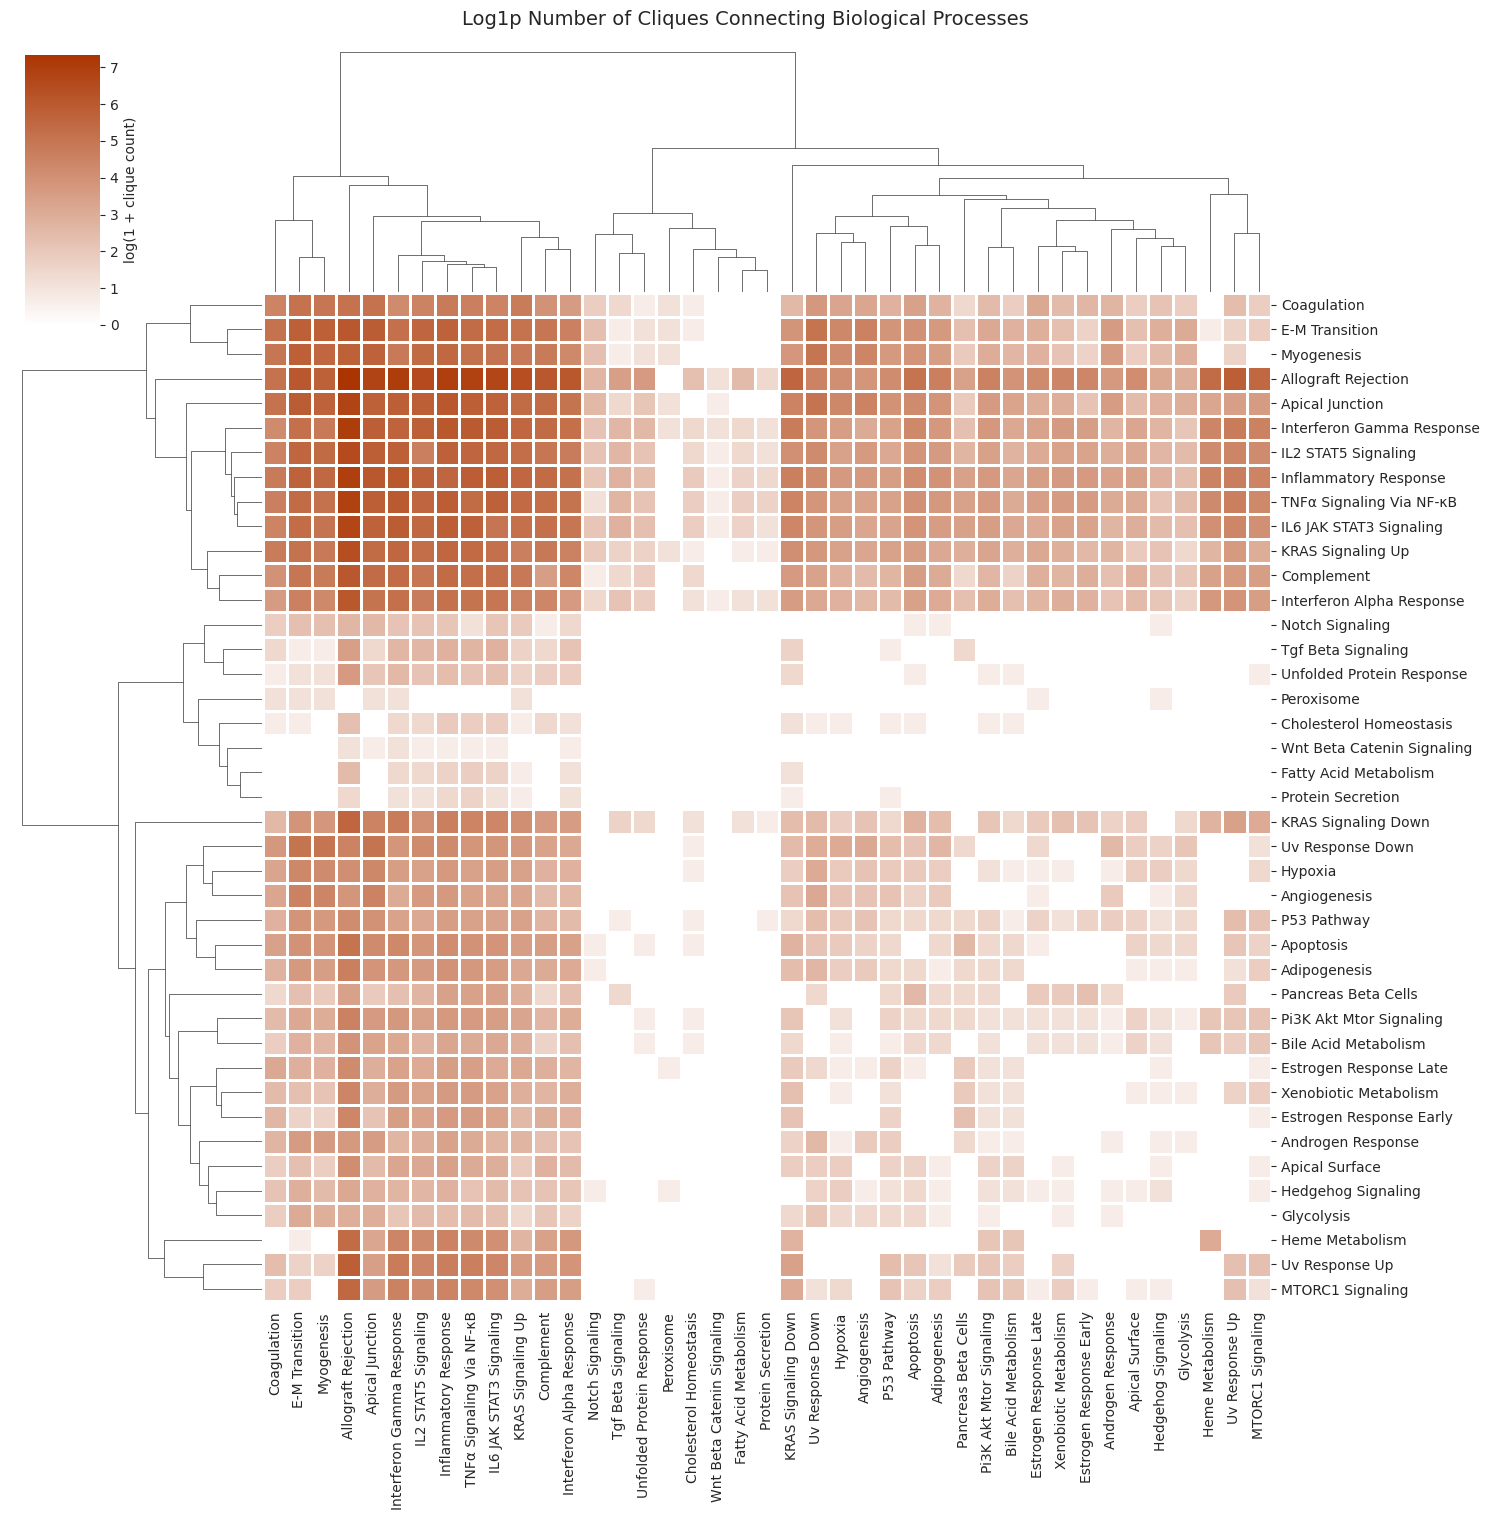

In [47]:
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

top_N = 60
fs = 14

# Create a DataFrame to store pairwise counts
heatmap_df = pd.DataFrame(0, index=all_hallmarks, columns=all_hallmarks)

# Fill in the counts
for (h1, h2), cliques in hallmark_pairs.items():
    count = len(cliques)
    heatmap_df.loc[h1, h2] += count
    heatmap_df.loc[h2, h1] += count  # Symmetric
    if h1 == h2:
        heatmap_df.loc[h1, h2] /= 2

# Compute total interactions per hallmark
total_counts = heatmap_df.sum(axis=1)

# Get top N hallmarks
top_hallmarks = total_counts.nlargest(top_N).index

# Subset the heatmap DataFrame
heatmap_top = heatmap_df.loc[top_hallmarks, top_hallmarks]

# Create custom colormap from white to tcolor
custom_cmap = LinearSegmentedColormap.from_list("white_to_tcolor", ["white", tcolor])

# Apply log1p transform to data
heatmap_log = np.log1p(heatmap_top)
heatmap_log.index = heatmap_log.index.map(hallmark_name_map)
heatmap_log.columns = heatmap_log.columns.map(hallmark_name_map)

# Plot clustermap with the custom colormap
sns.clustermap(
    heatmap_log,
    cmap=custom_cmap,
    annot=False,
    square=True,
    linewidths=1,
    figsize=(15, 15),
    linecolor='white',
    cbar_kws={"label": "log(1 + clique count)"}
)

plt.suptitle(f"Log1p Number of Cliques Connecting Biological Processes", y=1.01, fontsize=fs)

plt.savefig('/home/lnemati/pathway_crosstalk/results/supplementary/hallmarks_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.savefig('/home/lnemati/pathway_crosstalk/results/supplementary/hallmarks_heatmap.png', dpi=300, bbox_inches='tight')

plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/crosstalk/hallmarks/hallmarks_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/crosstalk/hallmarks/hallmarks_heatmap.png', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
all_motifs = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/both/motifs.csv')
motifs_to_plot = all_motifs.query('Type in ["3_clique", "4_clique"]')['Interaction']
#motifs_to_plot = all_motifs['Interaction']

In [ ]:
net = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/network_filtered.csv')
net['sign'] = np.where(net['auroc'] > 0.5, +1, -1)
net = net[['complex1', 'complex2', 'sign']]

In [ ]:
net_mirror = net.copy()
net_mirror.columns = ['complex2', 'complex1', 'sign']
net_mirror = net_mirror[['complex1', 'complex2', 'sign']]
net = pd.concat([net, net_mirror]).set_index(['complex1', 'complex2'])
net = net['sign']

In [ ]:
motifs_to_plot = motifs_to_plot.str.split('&', expand=True)
motifs_to_plot.columns = ['int1', 'int2']

In [ ]:
motifs_to_plot['sign1'] = motifs_to_plot['int1'].apply(lambda x: net.loc[(x.split('+')[0],x.split('+')[1])])
motifs_to_plot['sign2'] = motifs_to_plot['int2'].apply(lambda x: net.loc[(x.split('+')[0],x.split('+')[1])])
motifs_to_plot = motifs_to_plot.set_index(['int1', 'int2'])

In [ ]:
motifs_to_plot['result'] = 'Discordant'
motifs_to_plot['result'] = np.where((motifs_to_plot.sign1 == 1 ) & (motifs_to_plot.sign2 == 1 ), 'Tumor', motifs_to_plot['result'])
motifs_to_plot['result'] = np.where((motifs_to_plot.sign1 == -1) & (motifs_to_plot.sign2 == -1), 'Normal', motifs_to_plot['result'])

In [ ]:
counts = motifs_to_plot['result'].value_counts()

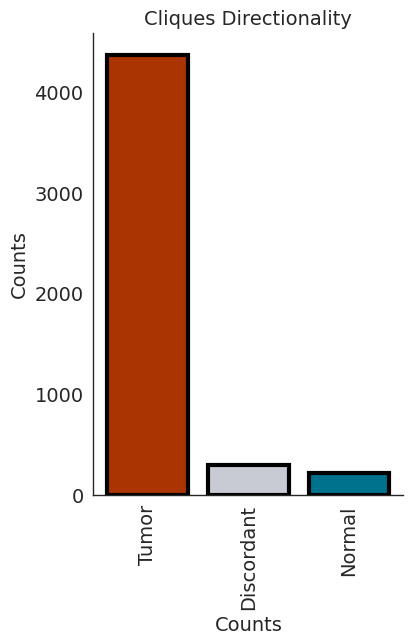

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.image as mpimg
import os

fs = 14

# Create the custom colormap and normalize the z-scores
cmap = mcolors.LinearSegmentedColormap.from_list('custom_gradient', ['white', tcolor])
colors = cmap(norm(counts))

# Create the bar plot
fig, ax = plt.subplots(1, 1, figsize=(4, 6))

bars = ax.bar(
    x=counts.index,
    height=counts.values,
    color=[tcolor, lightgray, ncolor],
    edgecolor='k',
    linewidth=3,
)

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=fs)

# Customize the plot
ax.set_title("Cliques Directionality", fontsize=fs)
ax.set_xlabel("Condition", fontsize=fs)
ax.set_ylabel("Counts", fontsize=fs)
plt.xticks(rotation=90)
ax.set_xlabel('Counts')


#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/crosstalk/cliques_directionality.pdf', bbox_inches='tight', dpi=300)
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/crosstalk/cliques_directionality.png', bbox_inches='tight')

plt.show()


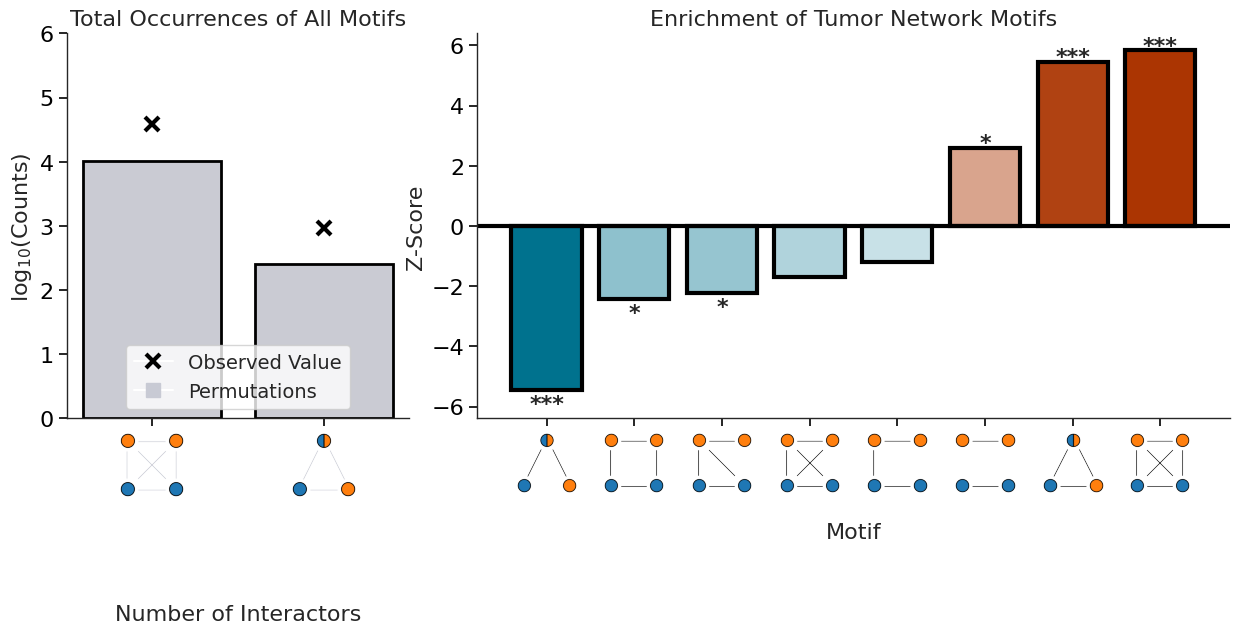

In [ ]:
fs = 14

def read_and_plot_motifs(folder, color=orangecolor, ax=None, return_fig=False, fs=14, scaling_factor=0.85):
    
    df          = pd.read_csv(os.path.join(folder, 'motifs_permutations.csv'))
    real_counts = pd.read_csv(os.path.join(folder, 'counts.csv'), index_col='motif')
    
    perm_triplets = df[['3_path', '3_clique']].sum(1)
    real_triplets = real_counts.T[['3_path', '3_clique']].loc['number'].sum()

    perm_quadruplets = df.sum(1) - perm_triplets
    real_quadruplets = real_counts.values.sum() - real_triplets
    
    data = pd.DataFrame({
        'Triads': perm_triplets,
        'Tetrads': perm_quadruplets
    })
    df_long = data.melt(var_name="Feature", value_name="Value")

    real_values = [real_triplets, real_quadruplets]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    else:
        fig = ax.figure

    style = dict(marker='x', linestyle=' ', markersize=10, markeredgewidth=3,
                 markerfacecolor=color, markeredgecolor='k')

    sorted_features_1 = df_long.groupby("Feature")["Value"].median().sort_values(ascending=False).index
    df_long_sorted = df_long[df_long["Feature"].isin(sorted_features_1)]
    df_long_sorted['Value'] = np.log10(df_long_sorted['Value'])

    real_values_series_1 = np.log10(pd.Series(real_values, index=df_long["Feature"].unique()))
    real_values_sorted_1 = real_values_series_1.loc[sorted_features_1]

    sns.barplot(
        x="Feature",
        y="Value",
        data=df_long_sorted,
        color=lightgray,
        order=sorted_features_1,
        ax=ax,
        estimator='mean',
        #errorbar='sd',
        errorbar=None,
        linewidth=2,
        edgecolor='k',
        err_kws={'color': 'black'}
    )

    ax.plot(range(len(real_values_sorted_1)), real_values_sorted_1, **style, label='log10 Counts')
    ax.set_title("Total Occurrences\nof All Motifs", fontdict={'fontsize': fs})
    ax.set_ylabel("log$_{10}$(Counts)", fontdict={'fontsize': fs})
    ax.set_xlabel("Feature", fontdict={'fontsize': fs}, labelpad=20)

    img_dir = '/home/lnemati/pathway_crosstalk/data/motifs_icons/'
    img_width = 0.15 * scaling_factor
    img_height = img_width  
    
    xl, yl, xh, yh = np.array(ax.get_position()).ravel()
    w = xh - xl
    h = yh - yl
    
    figure_height_in_inches = fig.get_size_inches()[1]
    figure_to_axes_ratio = h / figure_height_in_inches
    dynamic_labelpad = img_height / figure_to_axes_ratio * 72 + 3
    #ax.set_xlabel("Feature", fontdict={'fontsize': fs}, labelpad=dynamic_labelpad)
    ax.set_xlabel('')
    
    for i, label in enumerate(sorted_features_1):
        img_path = os.path.join(img_dir, f"{label}.png")
        if os.path.exists(img_path):
            img = mpimg.imread(img_path)
            label_display_coords = ax.get_xticklabels()[i].get_position()
            label_x = label_display_coords[0]
            label_display_coords = ax.transData.transform((label_x, 0))
            fig_coords = fig.transFigure.inverted().transform(label_display_coords)
            xpos = fig_coords[0] - img_width / 2
            ypos = yl - img_height - 0.03
            ax_img = fig.add_axes([xpos, ypos, img_width, img_height])
            ax_img.axison = False
            ax_img.imshow(img)
    
    handles = [
        Line2D([0], [0], marker='x', color='w', markerfacecolor=color, markeredgewidth=3,
               markeredgecolor='k', markersize=10, label='Observed Value'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor=lightgray, 
               markeredgecolor=lightgray, markersize=10, label='Permutations'),
    ]
    
    ax.legend(handles=handles, loc='lower center', fontsize=fs)
    ax.set_ylim(0, 5)
    ax.tick_params(labelsize=fs)
    ax.tick_params(axis='x', which='major', pad=dynamic_labelpad)    
    
    if return_fig:
        return fig


fig, axes = plt.subplot_mosaic(
    mosaic="""
    ACC
    """,
    figsize=(15, 5),
    #gridspec_kw={'wspace': 0.3}
)

# Call your motif function, passing the proper Axes for panel A
read_and_plot_motifs(
    '/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor',
    color=tcolor,
    ax=axes['A']
)

import numpy as np

fs = 16

# Log10 transform the counts
log_counts = np.log10(counts)

# Create the custom colormap and normalize the z-scores
cmap = mcolors.LinearSegmentedColormap.from_list('custom_gradient', ['white', tcolor])
colors = cmap(norm(counts))

################### PANEL B: Cliques Directionality ###################
## Plot into panel B
#ax = axes['B']
#bars = ax.bar(
#    x=counts.index,
#    height=log_counts.values,
#    color=[tcolor, lightgray, ncolor],
#    edgecolor='k',
#    linewidth=3,
#)
#
#ax.spines[['right', 'top']].set_visible(False)
#ax.tick_params(labelsize=fs)
#ax.set_title("Cliques Directionality", fontsize=fs)
#ax.set_xlabel("Condition", fontsize=fs)
#ax.set_ylabel("log$_{10}$(Counts)", fontsize=fs)
#ax.set_xticklabels(counts.index, rotation=90)

################## PANEL C: Motifs Z-Score ###################

ax = axes['C']
fig = ax.figure

# Create the custom colormap and normalize the z-scores
cmap = mcolors.LinearSegmentedColormap.from_list('custom_gradient', [ncolor, 'white', tcolor])
norm = mcolors.TwoSlopeNorm(vmin=z_scores.min(), vcenter=0, vmax=z_scores.max())
colors = cmap(norm(z_scores))

bars = ax.bar(
    motifs,
    z_scores,
    color=colors,
    edgecolor='k',
    linewidth=3,
)

# Same layout/image handling
img_width = 0.12
img_height = img_width

xl, yl, xh, yh = np.array(ax.get_position()).ravel()
w = xh - xl
h = yh - yl
figure_height_in_inches = fig.get_size_inches()[1]
figure_to_axes_ratio = h / figure_height_in_inches
dynamic_labelpad = img_height / figure_to_axes_ratio * 72

for i, label in enumerate(motifs):
    img_path = os.path.join(img_dir, f"{label}.png")
    if os.path.exists(img_path):
        img = mpimg.imread(img_path)
        label_display_coords = ax.get_xticklabels()[i].get_position()
        label_x = label_display_coords[0]
        label_display_coords = ax.transData.transform((label_x, 0))
        fig_coords = fig.transFigure.inverted().transform(label_display_coords)
        xpos = fig_coords[0] - img_width / 2
        ypos = yl - img_height - 0.03
        ax_img = fig.add_axes([xpos, ypos, img_width, img_height])
        ax_img.axison = False
        ax_img.imshow(img)

xlim = ax.get_xlim()
ax.hlines(0, xlim[0], xlim[1], color='k', linestyle='-', linewidth=3)
ax.set_xlim(xlim)

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=fs)

# Significance stars
sig_levels = {0.001: '***', 0.01: '**', 0.05: '*'}
for bar, z_score, p_val in zip(bars, z_scores, p_values):
    height = bar.get_height()
    sig_symbol = next((symbol for threshold, symbol in sig_levels.items() if p_val <= threshold), None)
    if sig_symbol:
        text_y = height + 0.15 if z_score > 0 else height - 0.15
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            text_y,
            sig_symbol,
            ha='center',
            va='center' if z_score > 0 else 'top',
            fontsize=fs,
            fontweight='bold'
        )

# Titles and labels
axes['A'].set_title("Total Occurrences of All Motifs", fontsize=fs)
axes['A'].set_xlabel("Number of Interactors", fontsize=fs, labelpad=65)
axes['A'].set_ylabel("log$_{10}$(Counts)", fontsize=fs)
axes['A'].set_xticklabels([])    
axes['A'].set_ylim(0,6)        

# Titles and labels
axes['C'].set_title("Enrichment of Tumor Network Motifs", fontsize=fs)
axes['C'].set_xlabel("Motif", fontsize=fs, labelpad=65)
axes['C'].set_ylabel("Z-Score", fontsize=fs)
axes['C'].set_xticklabels([])

ylim = max(np.abs(axes['C'].get_ylim()))
axes['C'].set_ylim(-ylim, +ylim)

for spine in ['top', 'right']:
    axes['A'].spines[spine].set_visible(False)
    axes['C'].spines[spine].set_visible(False)

for ax in axes.values():
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    
    ax.tick_params(
        axis='both',
        which='both',
        labelsize=fs,
        direction='out',
        length=6,
        width=1.2,
        colors='black'
    )
    
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/crosstalk/motifs_occurrences_and_enrichment.png', dpi=300, bbox_inches='tight')
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/crosstalk/motifs_occurrences_and_enrichment.pdf', dpi=300, bbox_inches='tight')


In [ ]:
tdens = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor/motifs_densities.csv' , index_col='interaction').query('motif == "4_clique"')
ndens = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/normal/motifs_densities.csv', index_col='interaction').query('motif == "4_clique"')
bdens = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/both/motifs_densities.csv'  , index_col='interaction').query('motif == "4_clique"')

In [ ]:
# Get more co-expressed in normal cliques
ndf = ndens[[col for col in ndens.columns if col not in ['motif', 'avg_all', 'avg_normal', 'avg_tumor']]].melt(var_name='tissue', ignore_index=False).reset_index()
ndf['condition'] = np.where(ndf['tissue'].str.startswith('normal_'), 'normal', 'tumor')
ndf['tissue'] = ndf['tissue'].str.replace('normal_', '').str.replace('tumor_', '').str.replace('.csv', '')

# Get more co-expressed in tumor cliques
tdf = tdens[[col for col in tdens.columns if col not in ['motif', 'avg_all', 'avg_normal', 'avg_tumor']]].melt(var_name='tissue', ignore_index=False).reset_index()
tdf['condition'] = np.where(tdf['tissue'].str.startswith('tumor_'), 'tumor', 'normal')
tdf['tissue'] = tdf['tissue'].str.replace('tumor_', '').str.replace('normal_', '').str.replace('.csv', '')

# Merge
df = pd.concat([ndf, tdf])

# Only keep tissues with both tumor and normal
counts = df.groupby(['interaction', 'tissue'])['condition'].nunique()
tissues = counts[counts == 2].reset_index().tissue.unique()
df = df.query('tissue in @tissues')

# Pivot the data
pivot_df = df.pivot_table(
    index=["interaction", "tissue"],  # Use interaction and tissue as indices
    columns="condition",             # Pivot on condition (tumor/normal)
    values="value"                   # Use value column to calculate differences
).reset_index()

# Compute the difference (tumor - normal)
pivot_df['difference'] = pivot_df['tumor'] - pivot_df['normal']
pivot_df = pivot_df.query('normal !=0  and tumor !=0')

pivot_df = pivot_df.sort_values(by='difference')

In [ ]:
def network_to_adj(network_path):
    network = pd.read_csv(
        network_path,
        usecols=['complex1', 'complex2', 'adj']
    )

    # Add a mirrored version of the network to make it symmetric
    network_mirrored = network.copy()
    network_mirrored.columns = ['complex2', 'complex1', 'adj']
    network = pd.concat([network, network_mirrored], ignore_index=True)

    adj = network.pivot(index='complex1', columns='complex2', values='adj').fillna(0)
    return adj

In [ ]:
import networkx as nx

def plot_gene_network(genes, savepath=None, edge_scaling=15, node_size=2000, linewidths=3, fs=13):
    """
    Plots two network graphs: one based on ncorr and one based on tcorr.

    Parameters:
        genes (list): List of gene names to consider for the graph.
        edge_scaling (int, optional): Multiplier for edge thickness. Defaults to 20.
        node_size (int, optional): Size of the nodes. Defaults to 10000.
        linewidths (int, optional): Line width for node borders. Defaults to 5.
        fs (int, optional): Font size for labels. Defaults to 15.
    """
    global ncorr, tcorr  # Access the global variables ncorr and tcorr

    edgecolor = 'k'

    # Create a NetworkX graph for each correlation matrix, ensuring all genes are included
    G_nc = nx.Graph()
    G_tc = nx.Graph()

    # Add nodes to the graphs even if they have no edges
    G_nc.add_nodes_from(genes)
    G_tc.add_nodes_from(genes)

    # Add edges based on correlation values
    for i in range(len(genes)):
        for j in range(i + 1, len(genes)):  # Only add edges for the upper triangle
            if ncorr.loc[genes[i], genes[j]] > 0:
                G_nc.add_edge(genes[i], genes[j], weight=ncorr.loc[genes[i], genes[j]])
            if tcorr.loc[genes[i], genes[j]] > 0:
                G_tc.add_edge(genes[i], genes[j], weight=tcorr.loc[genes[i], genes[j]])

    # Set up subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    for ax, G, corr_matrix, title in zip(axes, [G_nc, G_tc], [ncorr, tcorr], ['Normal', 'Tumor']):
        
        # Set margins for the axes so that nodes aren't clipped
        #ax.margins(0.05)
        ax.axis("off")
        
        # Extract edge weights for the current graph
        weights = [G[u][v]['weight'] for u, v in G.edges()]

        # Scale weights for visualization
        scaled_weights = [w * edge_scaling for w in weights]  # Scale edge thickness

        # Use a square layout
        pos = {genes[0]: (0.8, 0.8), genes[1]: (0.2, 0.8), genes[2]: (0.8, 0.2), genes[3]: (0.2, 0.2)}

        title = title
        ax.set_title(title, fontsize=fs)

        if genes[1] in G[genes[0]]:
            # Add colored edges for interactions
            nx.draw_networkx_edges(
                G,
                pos,
                edgelist=[(genes[0], genes[1])],
                width=2 * edge_scaling * G[genes[0]][genes[1]]['weight'],
                alpha=1,
                edge_color='C0',
                ax=ax
            )
            
        if genes[3] in G[genes[2]]:
            nx.draw_networkx_edges(
                G,
                pos,
                edgelist=[(genes[2], genes[3])],
                width=2 * edge_scaling * G[genes[2]][genes[3]]['weight'],
                alpha=1,
                edge_color='C1',
                ax=ax
            )

        nx.draw(
            G,
            pos,
            with_labels=False,  # Disable default labels
            node_color=2 * ['C0'] + 2 * ['C1'],  # Node colors
            edge_color=edgecolor,
            width=scaled_weights,  # Scaled edge thickness
            node_size=node_size,
            font_size=fs,
            edgecolors=edgecolor,
            linewidths=linewidths,
            ax=ax
        )

        # Add custom labels with underscores replaced by newlines
        for node, (x, y) in pos.items():
            label = node.replace("_", "\n")  # Replace underscores with newlines
            ax.text(
                x,
                y,
                label,
                fontsize=fs,
                ha='center',
                va='center',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.25')
            )

        # Format edge labels to 2 decimal places (optional)
        labels = nx.get_edge_attributes(G, "weight")
        formatted_labels = {edge: f"{weight:.2f}" for edge, weight in labels.items()}

        diagonal_labels = {}
        other_labels = {}

        for k,v in formatted_labels.items():
            if (genes[0] in k and genes[3] in k) or (genes[1] in k and genes[2] in k):
                diagonal_labels[k] = v
            else:
                other_labels[k] = v

        # Draw edge labels
        nx.draw_networkx_edge_labels(
            G,
            pos,
            edge_labels=diagonal_labels,
            label_pos=0.25,
            ax=ax
        )
        nx.draw_networkx_edge_labels(
            G,
            pos,
            edge_labels=other_labels,
            label_pos=0.5,
            ax=ax
        )
    if savepath is not None:
        plt.savefig(savepath+'.pdf', bbox_inches='tight', dpi=300)
        plt.savefig(savepath+'.png', bbox_inches='tight')
    else:
        plt.show()

stomach
Normal
IL1B+IL1R2_IL1RAP&CD8B+HLA-B
IL1B+IL1R2_IL1RAP&CD8B+HLA-F
Tumor

colon
Normal
CD209+ICAM3&CD8B+HLA-B
CD209+ICAM3&CD8B+HLA-F
CD209+ICAM3&CD8B+HLA-C
CD4+IL16&CD8B+HLA-A
LAIR1+LILRB4&CD8B+HLA-A
LAIR1+LILRB4&CD8B+HLA-B
CD4+IL16&CD8B+HLA-B
CD4+IL16&CD8B+HLA-F
LAIR1+LILRB4&CD8B+HLA-F
CD4+HLA-DOB&CD8B+HLA-A
PLA2G7+PTAFR&CD8B+HLA-A
Tumor
FLT4_KDR+VEGFC&CD28+CD86


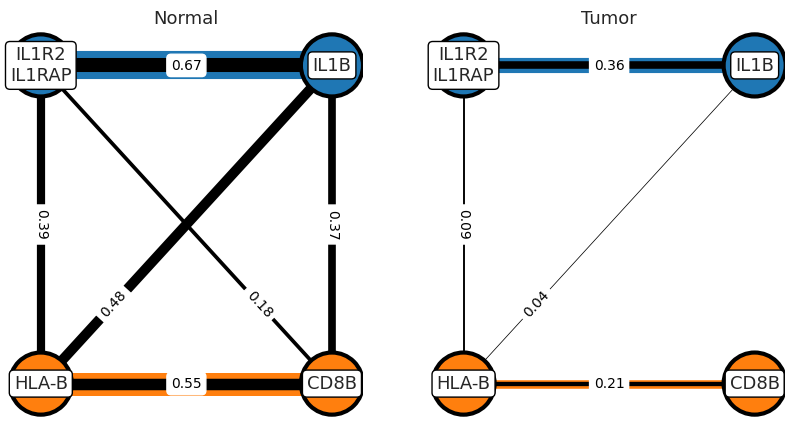

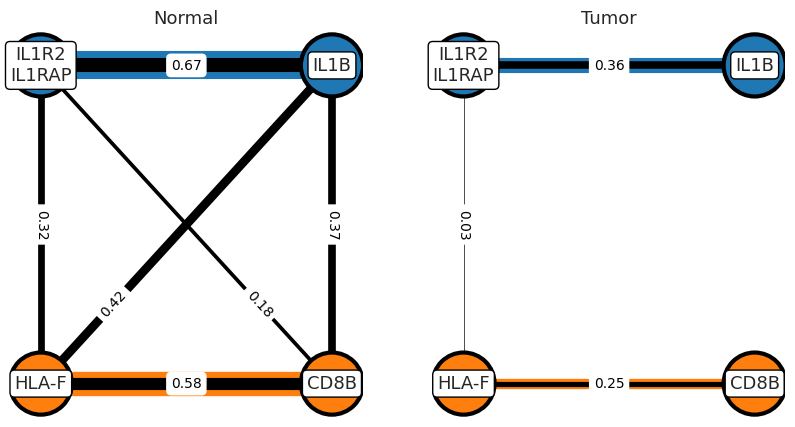

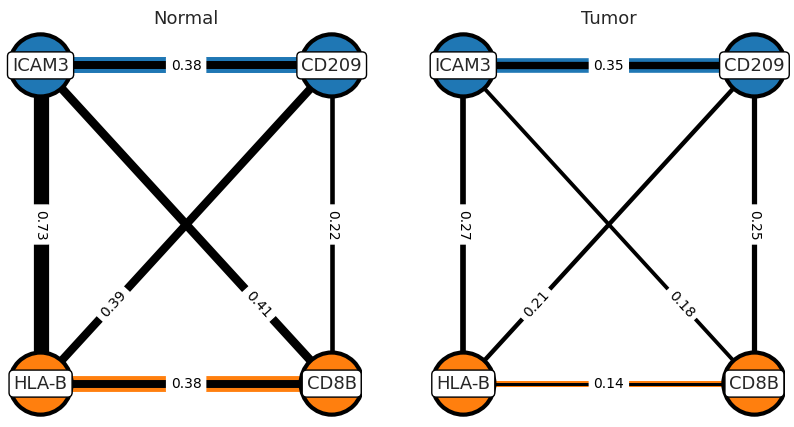

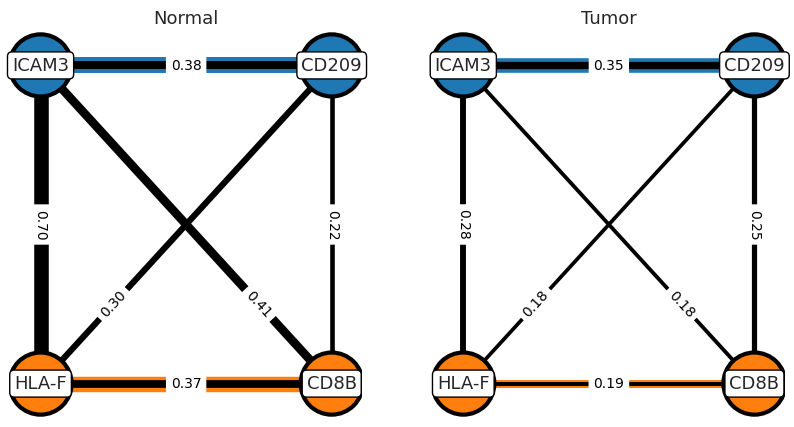

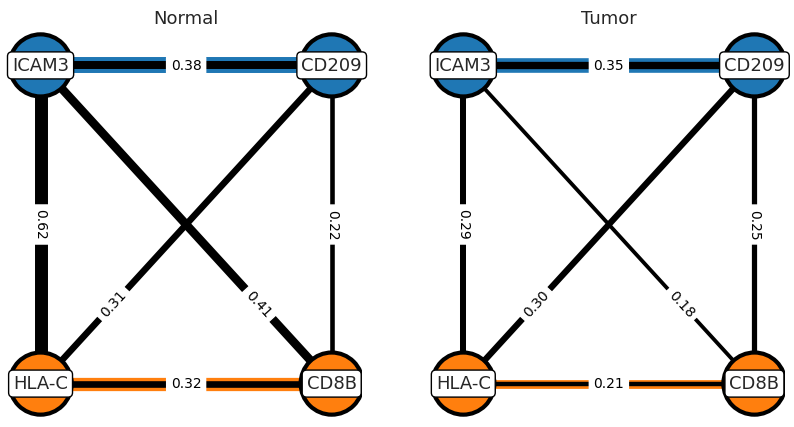

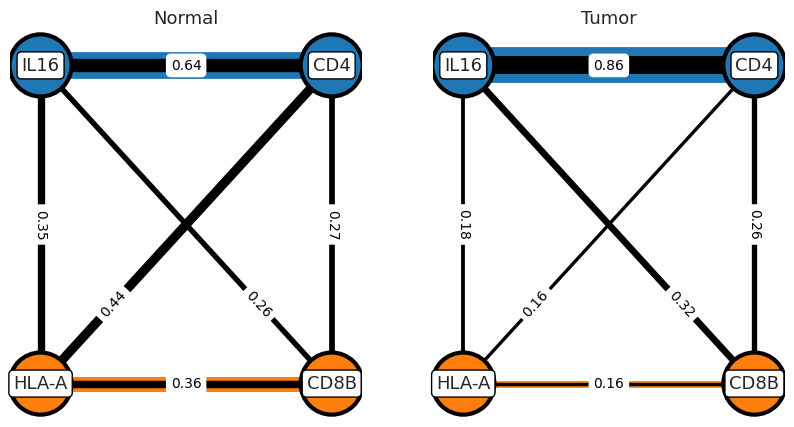

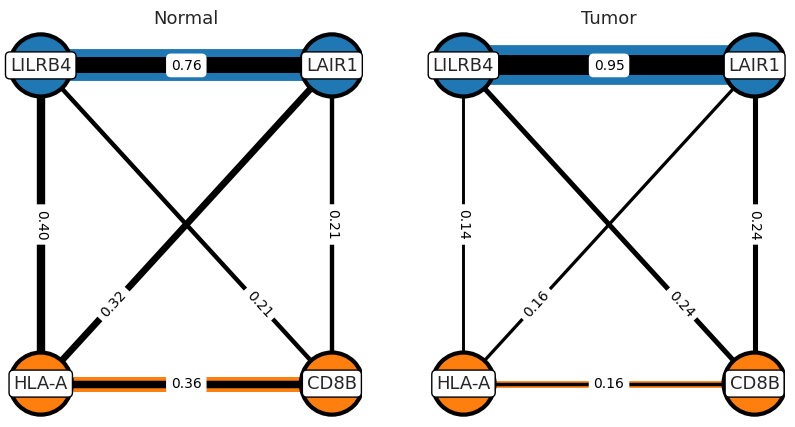

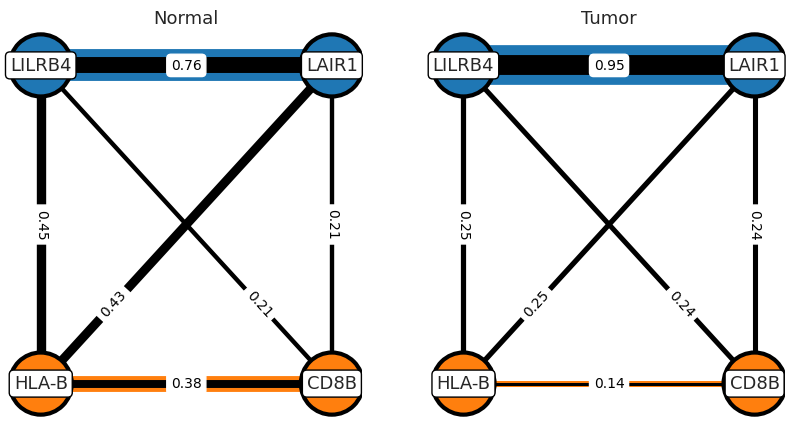

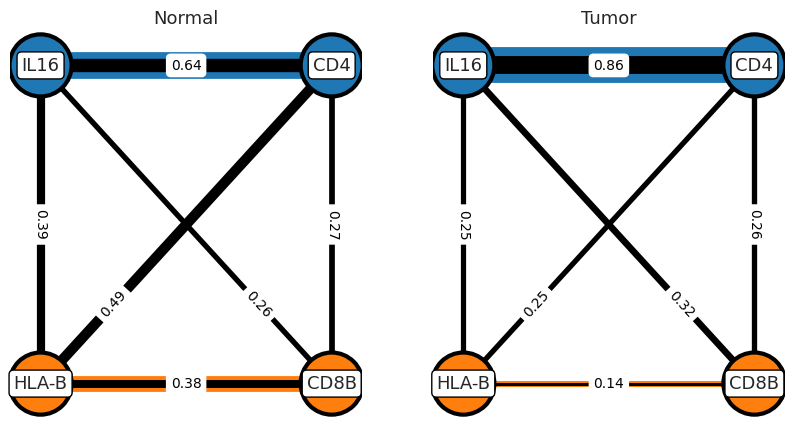

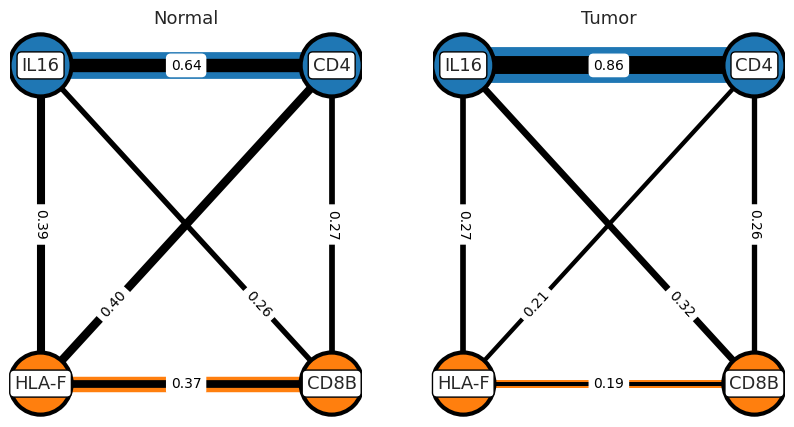

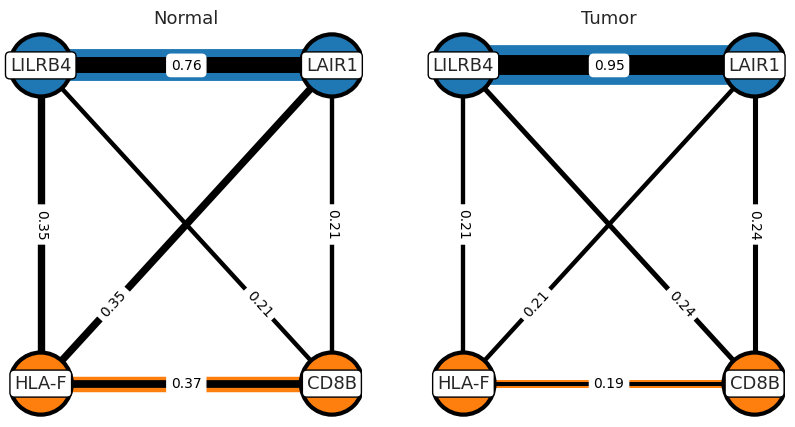

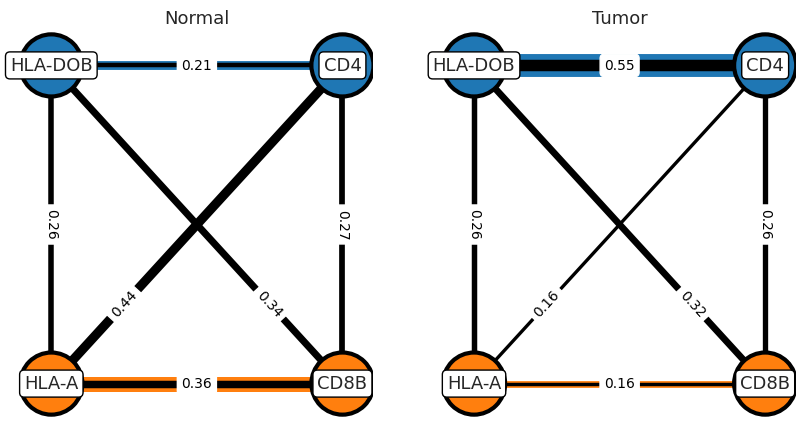

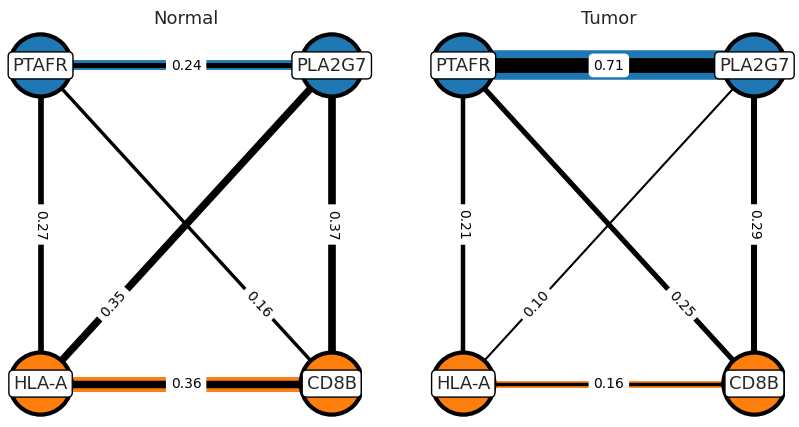

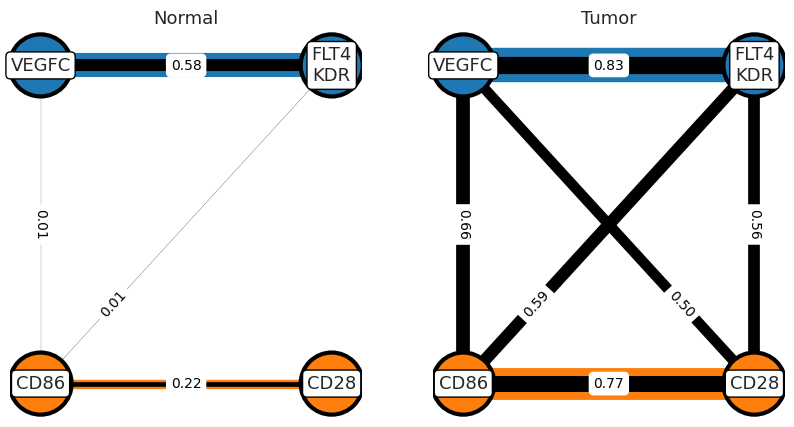


ovary
Normal
PDGFB+PDGFRB&ITGA2_ITGB1+LAMC2
Tumor

uterus
Normal
Tumor

esophagus
Normal
Tumor

breast
Normal
Tumor
IL15+IL15RA_IL2RB_IL2RG&CD226+ITGB2


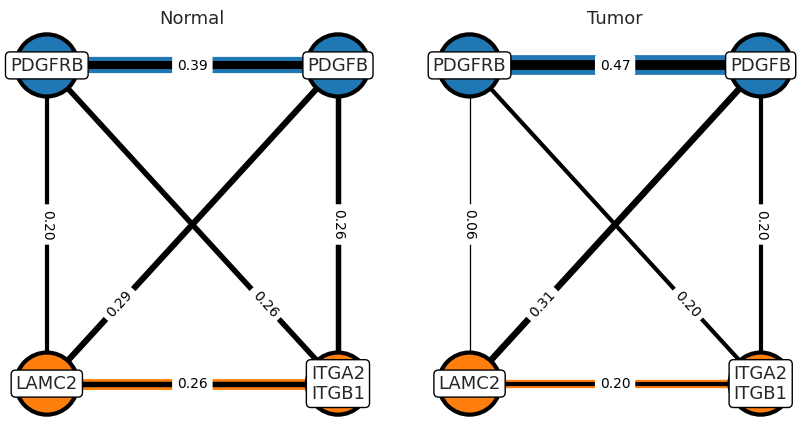

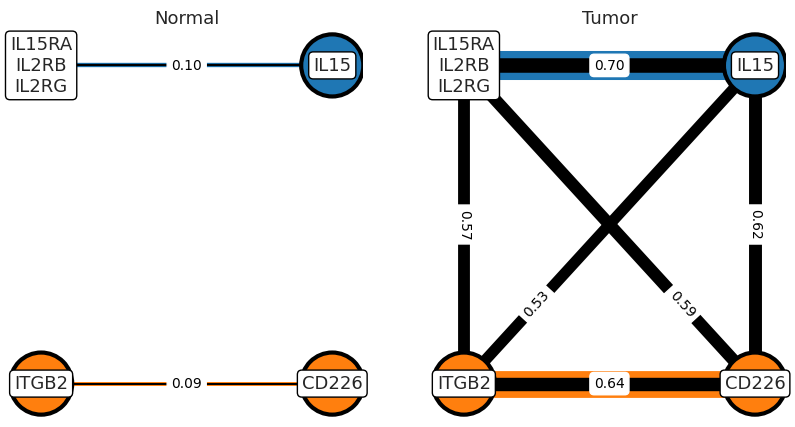

IL15+IL15RA_IL2RB_IL2RG&LAIR1+LILRB4


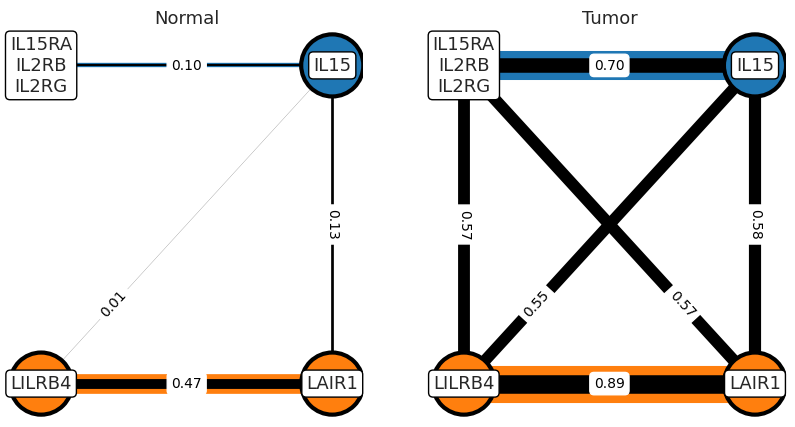

LAIR1+LILRB4&CD8A+HLA-F


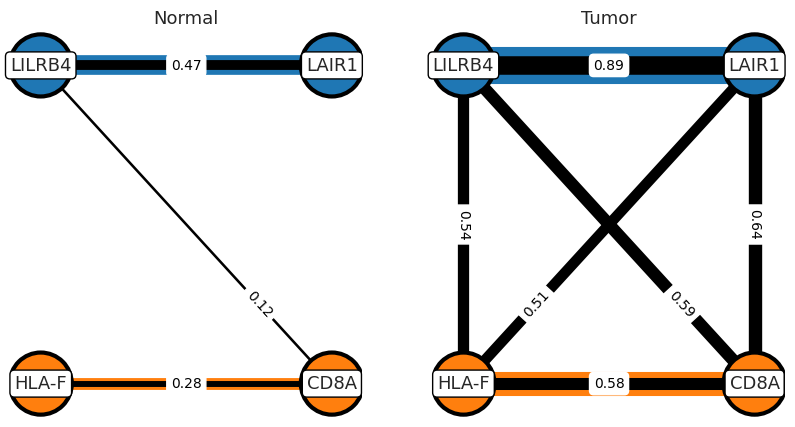

LAIR1+LILRB4&CD8A+HLA-B


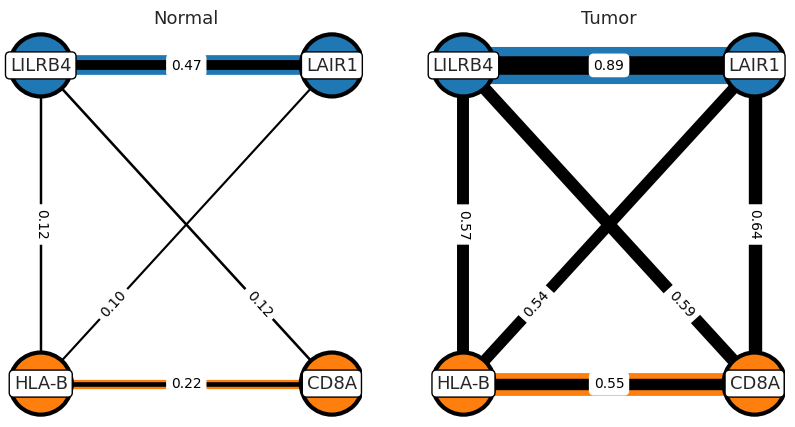


kidney
Normal
MCAM+WNT5A&ITGA6_ITGB1+LAMB1
TNF+TNFRSF1B&CD47+SIRPB1_TYROBP
CCL3+CCR1&ACVR1B_ACVR2B+INHBA_INHBB
NTF3+NTRK3&PTPRS+SLITRK4
CCL3+CCR1&IL15+IL15RA_IL2RB_IL2RG
SELL+SELPLG&ITGAV_ITGB6+TNXB
Tumor

liver
Normal
Tumor
CD4+IL16&LAIR1+LILRB4


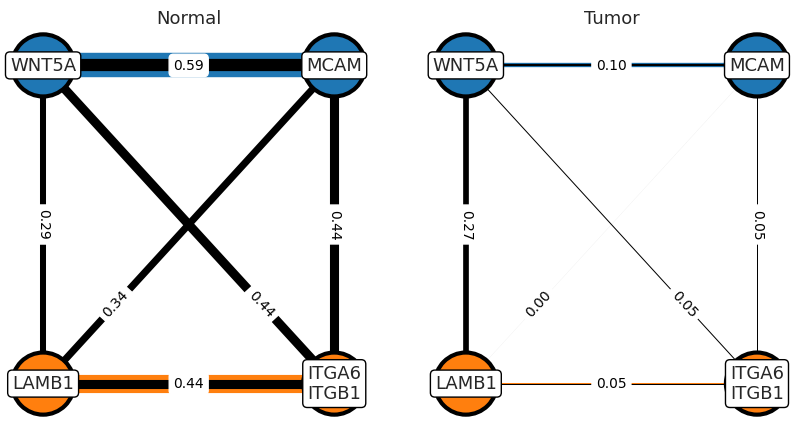

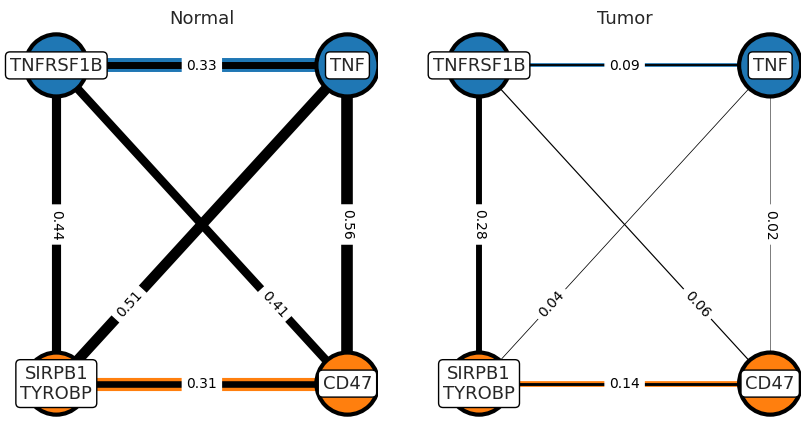

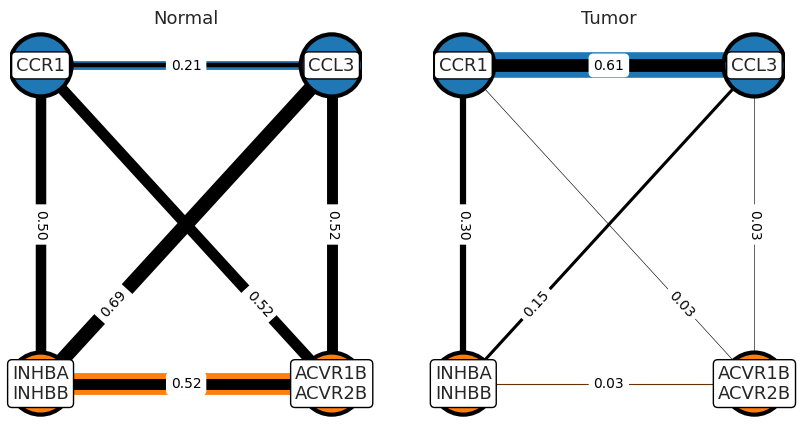

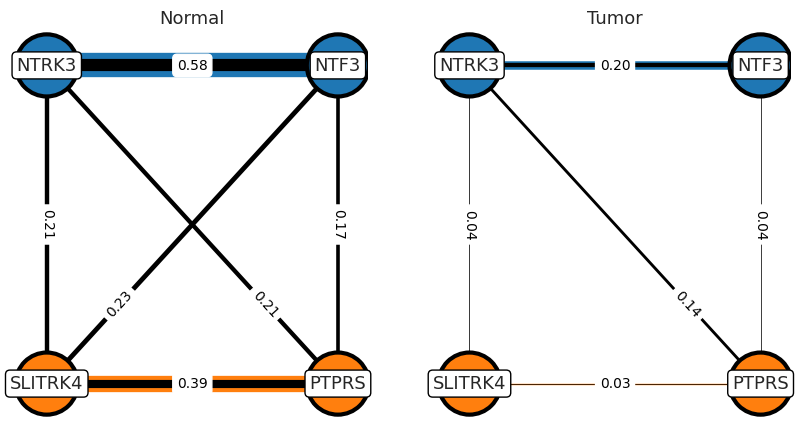

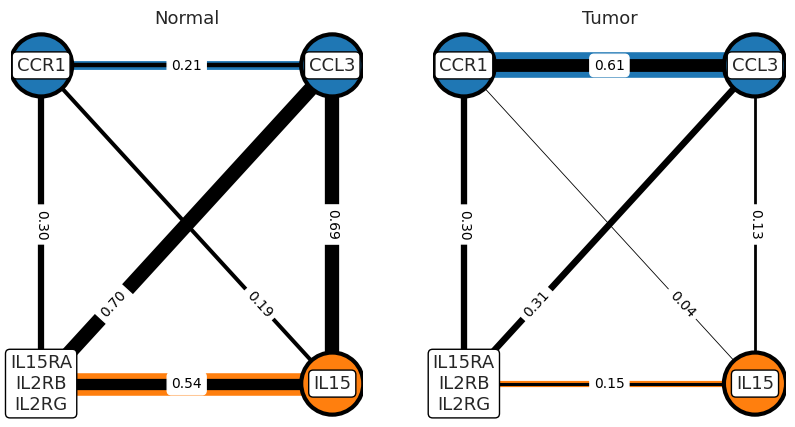

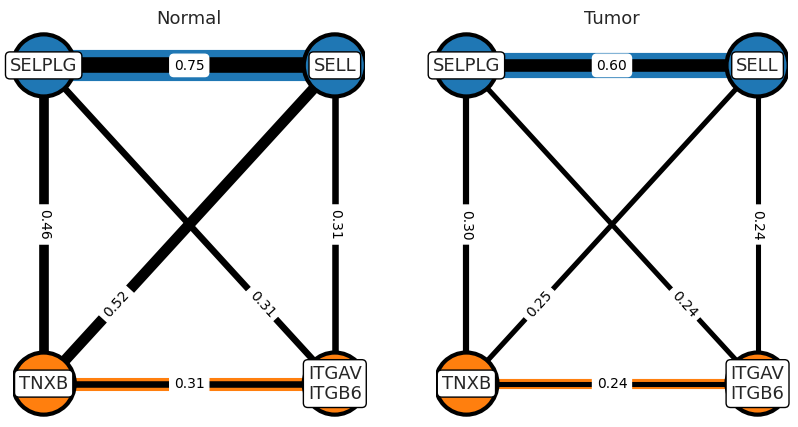

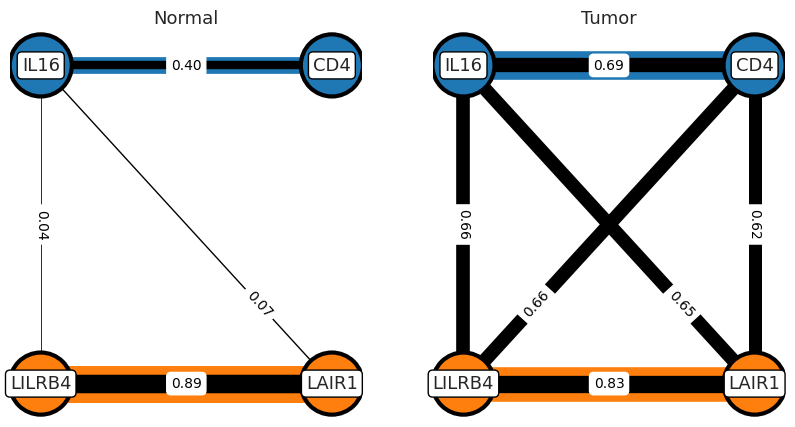


lung
Normal
Tumor
CD4+IL16&SELL+SELPLG


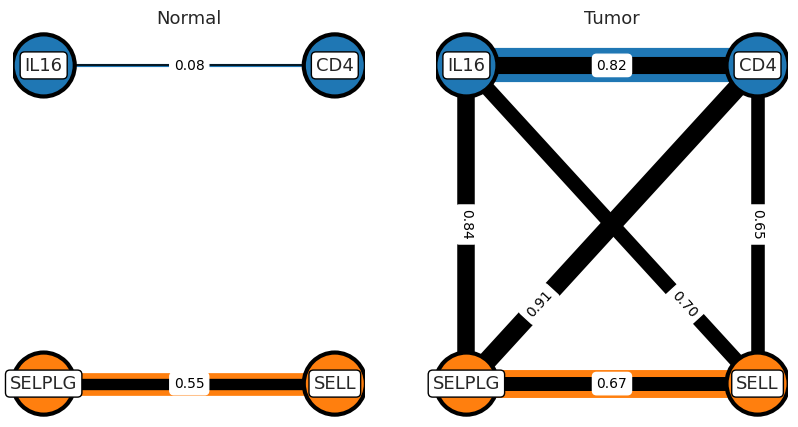

CD4+IL16&CD226+ITGB2


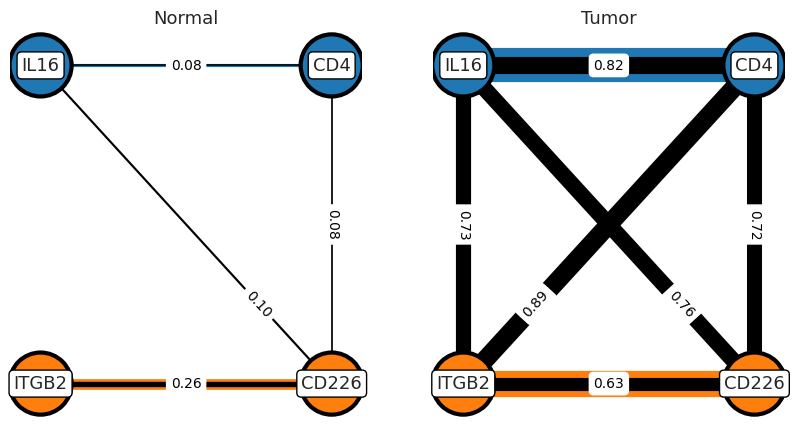

CD4+IL16&HLA-E+VSIR


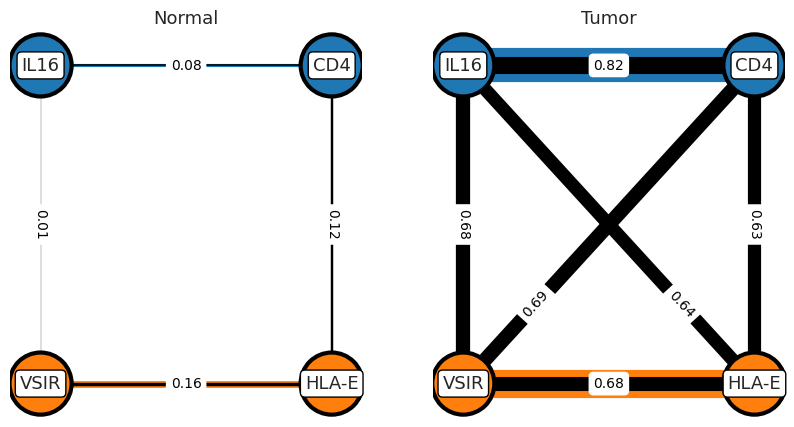

SELL+SELPLG&CD4+HLA-DMB


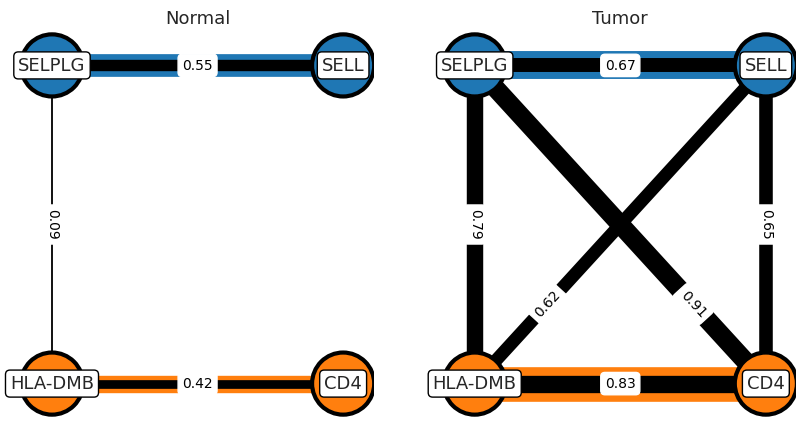

CCL3+CCR1&CD4+HLA-DMB


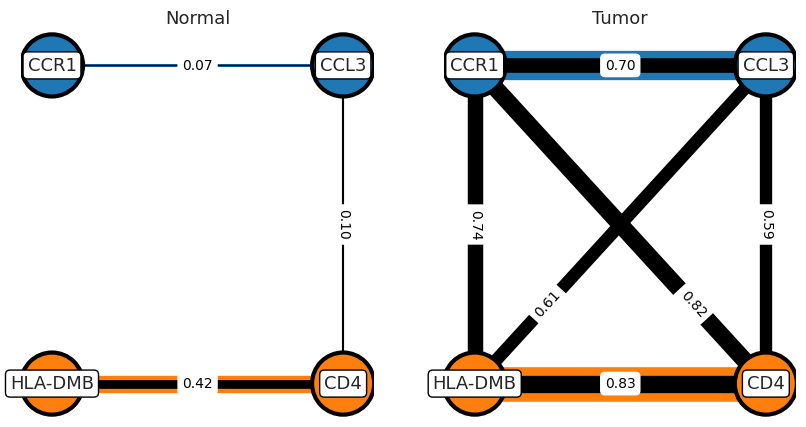

CD4+HLA-DMA&SELL+SELPLG


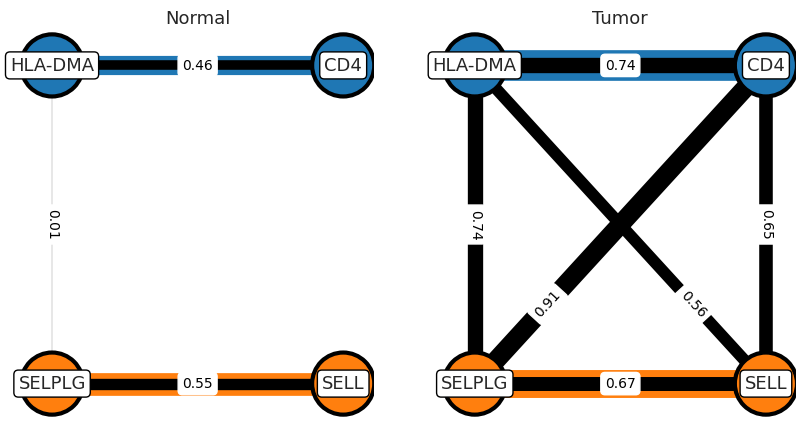

HLA-E+VSIR&CD4+HLA-DMB


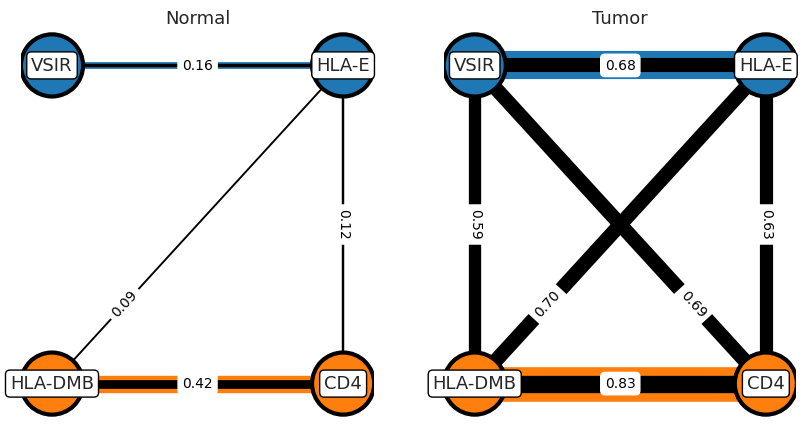

CD4+HLA-DOA&SELL+SELPLG


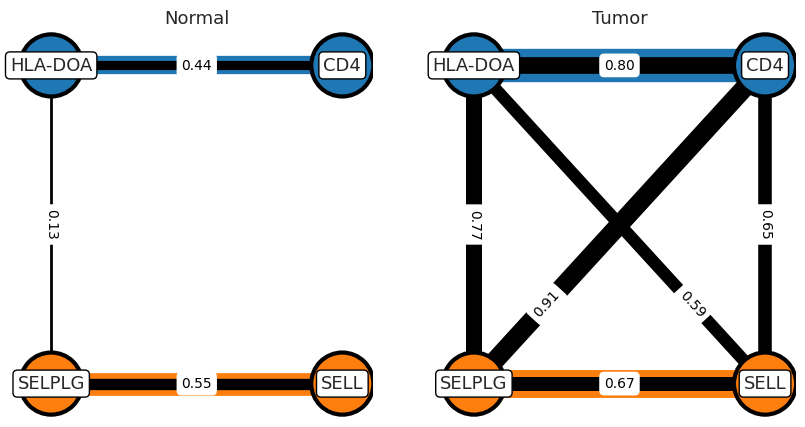

CCL3+CCR1&CD4+HLA-DRA


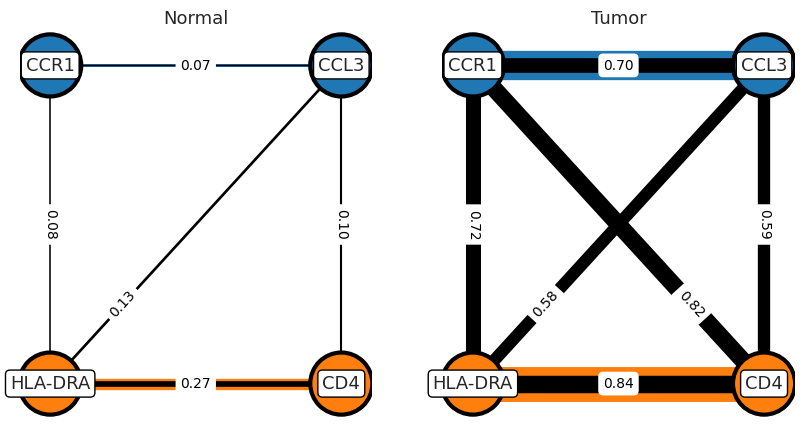

CD4+HLA-DQA1&SELL+SELPLG


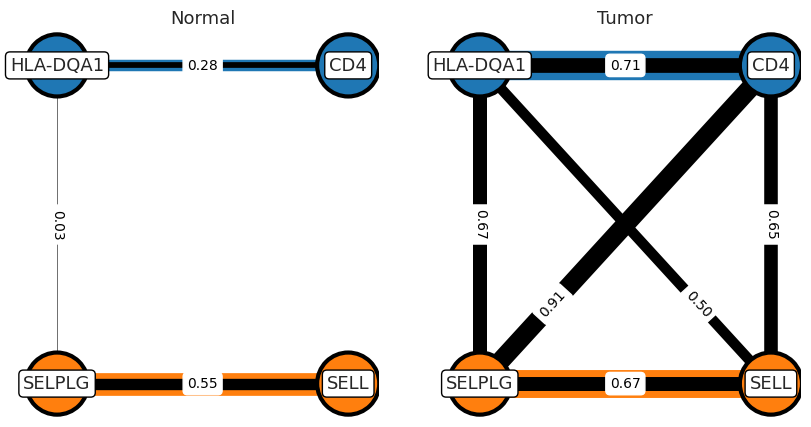

CCL3+CCR1&CD4+HLA-DPB1


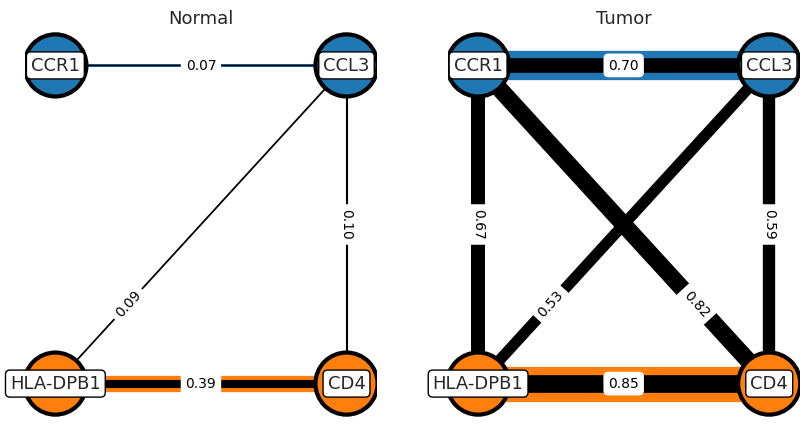

CCL3+CCR1&CD4+HLA-DQA1


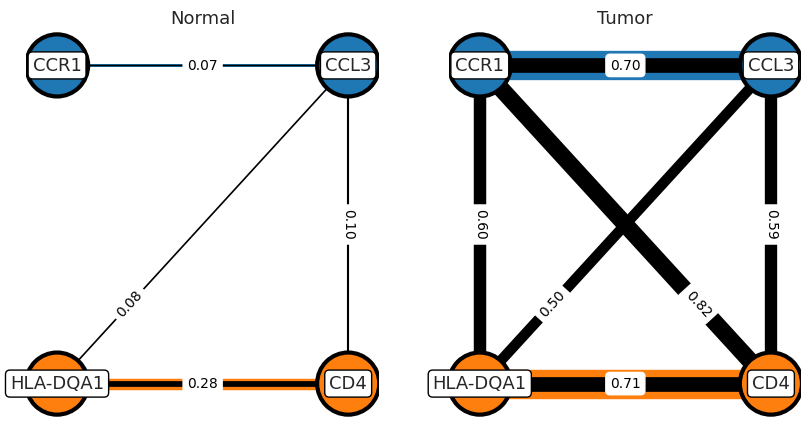

SELL+SELPLG&CD69+KLRB1


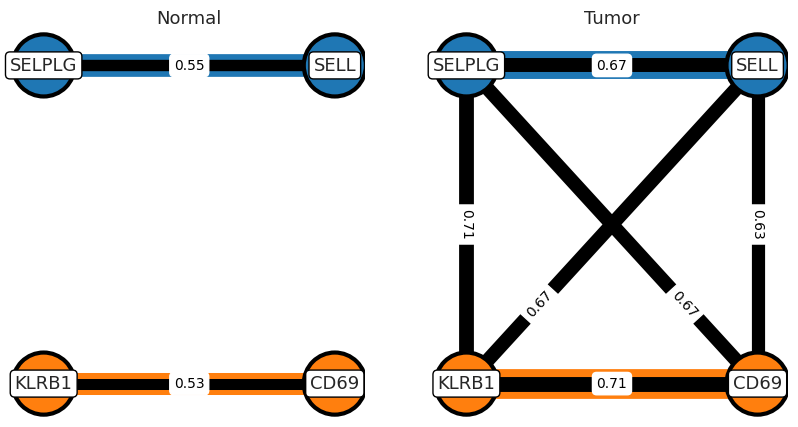

LAIR1+LILRB4&CD69+KLRB1


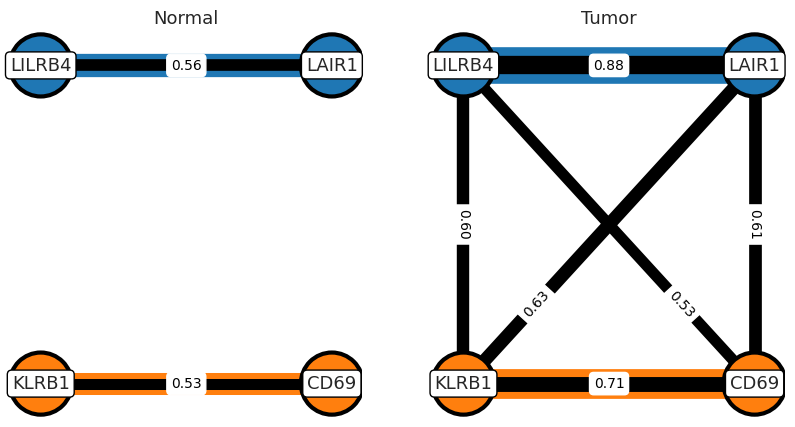

SELL+SELPLG&CD28+CD80


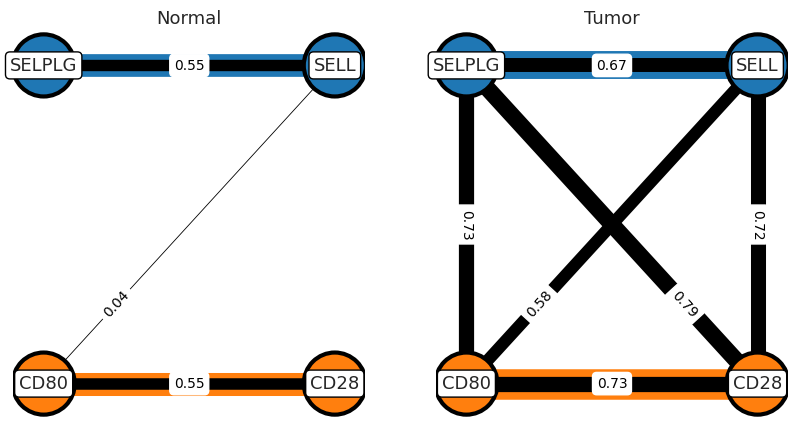

SELL+SELPLG&CD4+HLA-DOB


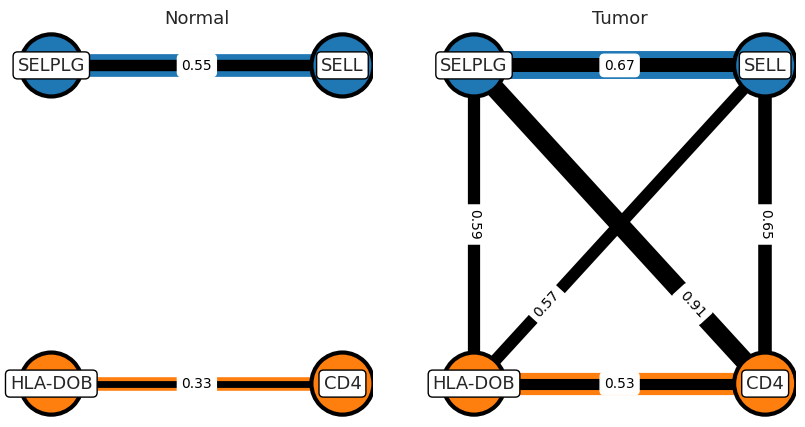

LAIR1+LILRB4&HLA-E+KLRK1


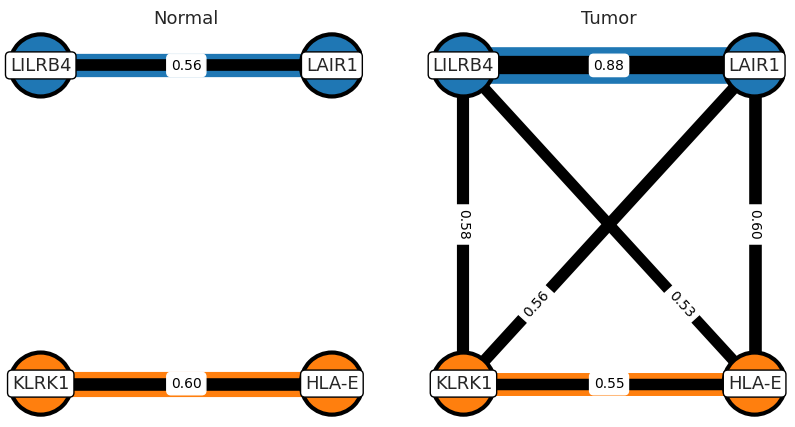

CD8A+HLA-E&LAIR1+LILRB4


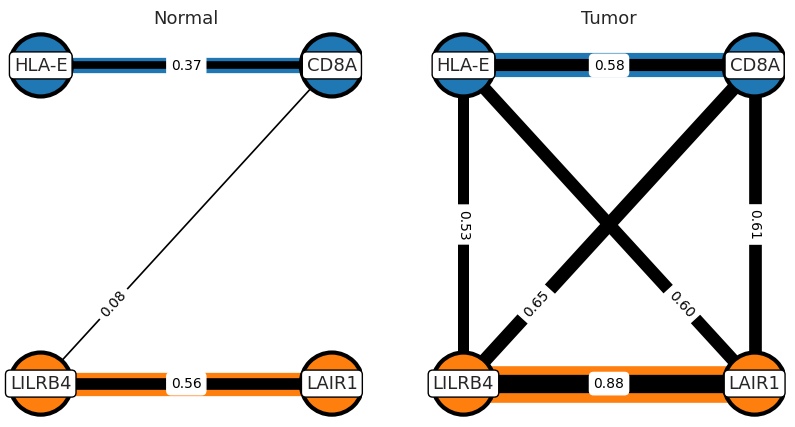

SELL+SELPLG&CD80+CTLA4


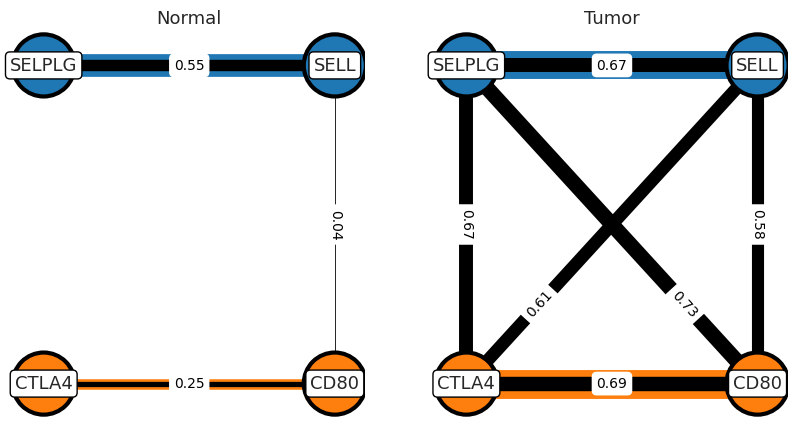

SELL+SELPLG&CCL5+CCR4


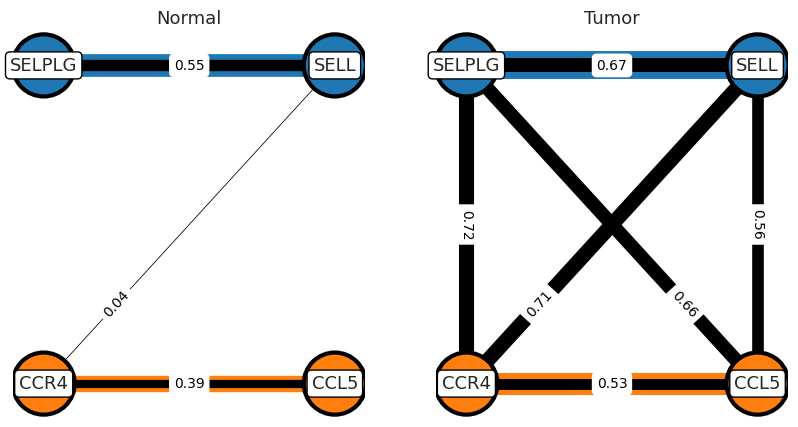

CD8A+HLA-E&SELL+SELPLG


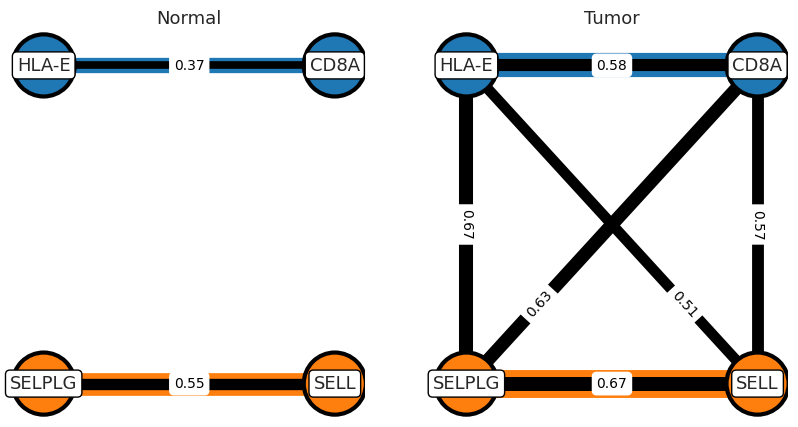

SELL+SELPLG&HLA-E+KLRK1


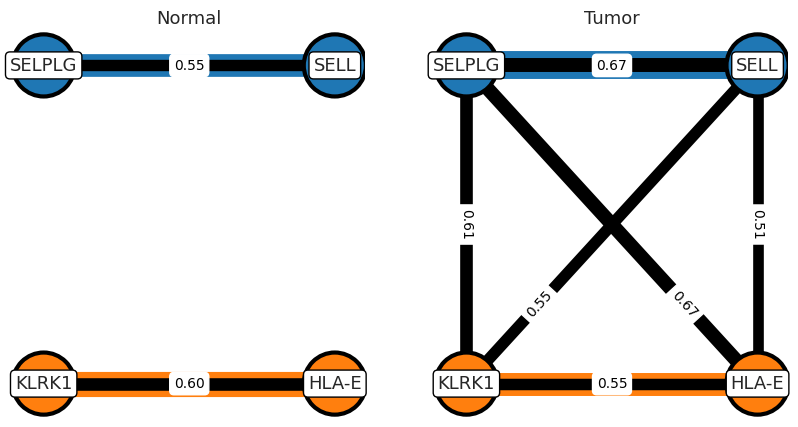

CD28+CD80&CYSLTR1+DPEP2


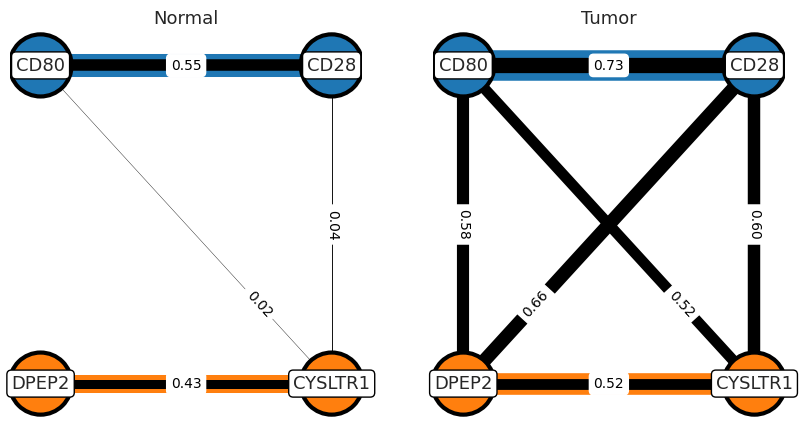

SELL+SELPLG&PDCD1+PDCD1LG2


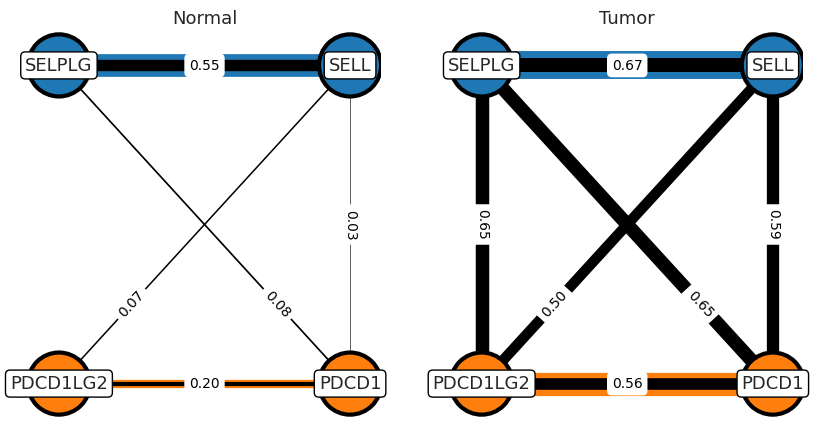


brain
Normal
GLS_SLC1A2+GRIA1&NLGN4X+NRXN1
Tumor
CD4+IL16&CCL5+CCR5


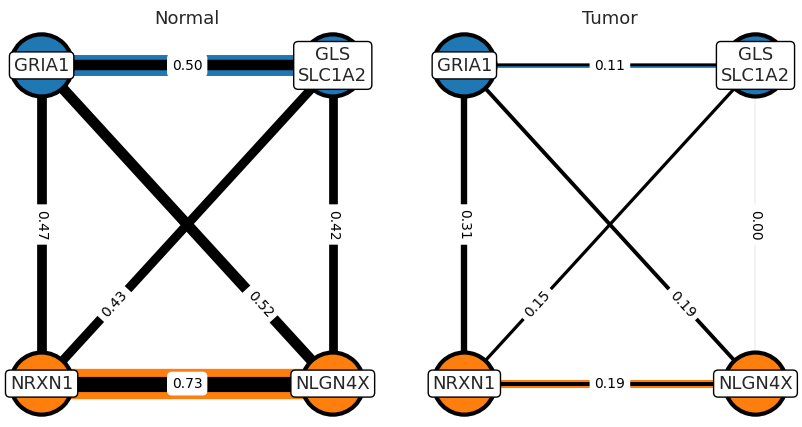

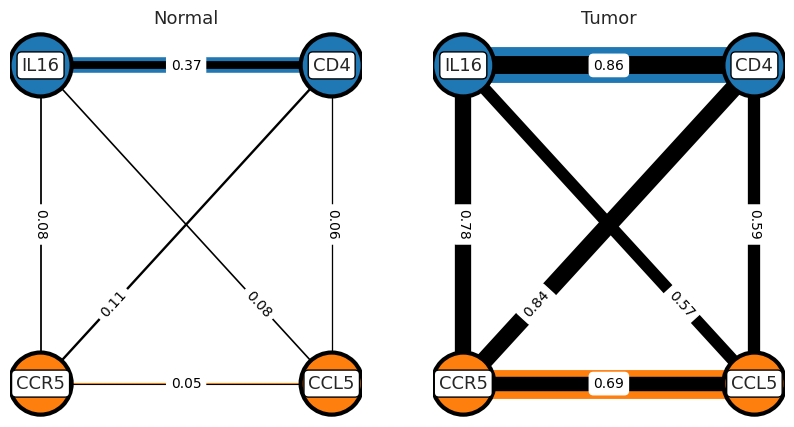

CCL5+CCR5&CD4+HLA-DOA


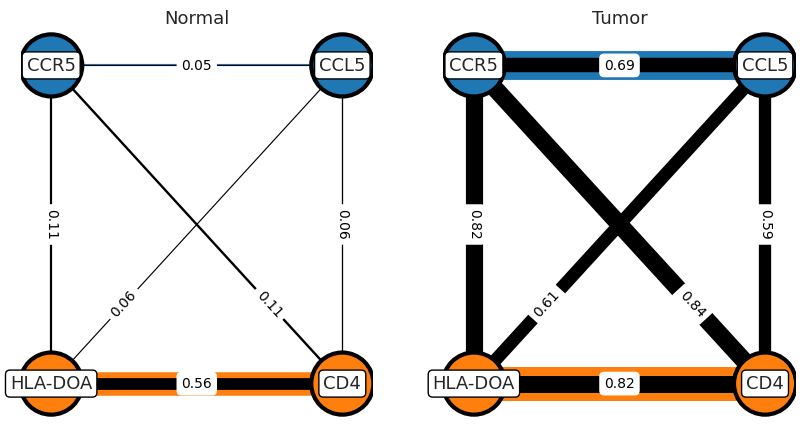

CCL5+CCR5&CD4+HLA-DMA


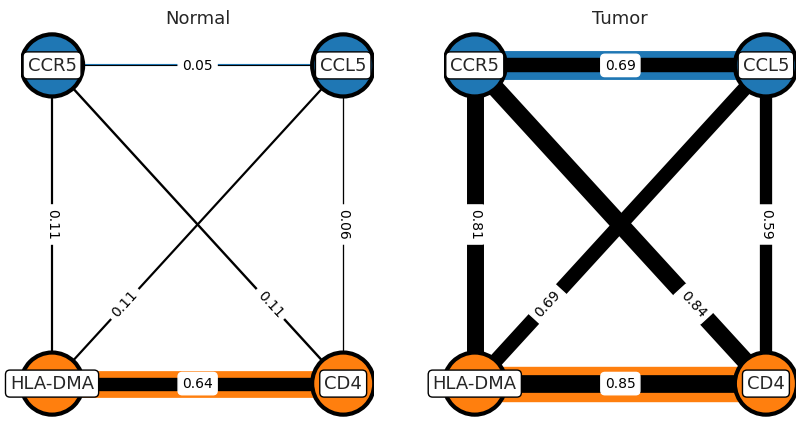

CCL5+CCR5&CD4+HLA-DRB1


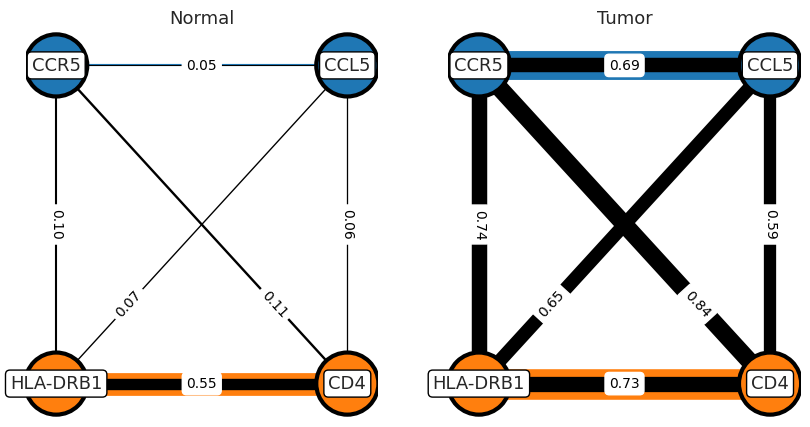

CD4+HLA-DQA1&CCL5+CCR5


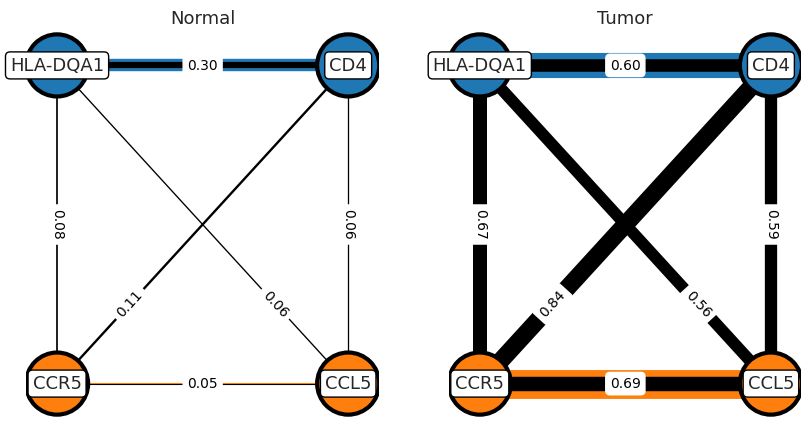

CCL5+CCR5&CD4+HLA-DMB


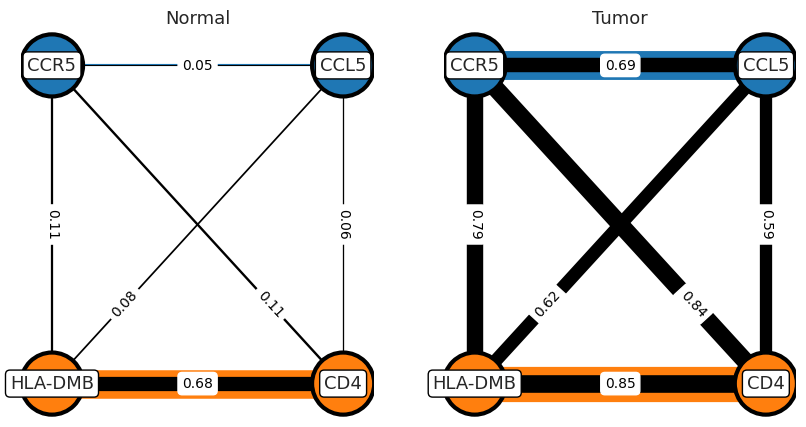

CCL5+CCR5&CD4+HLA-DPB1


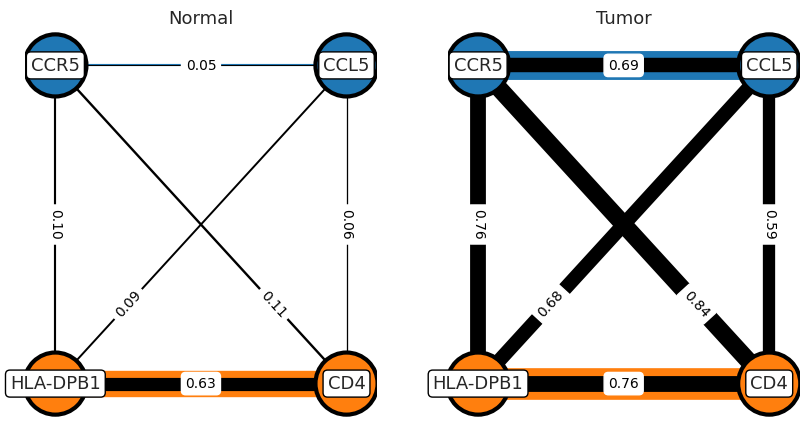

CCL5+CCR5&CD4+HLA-DRA


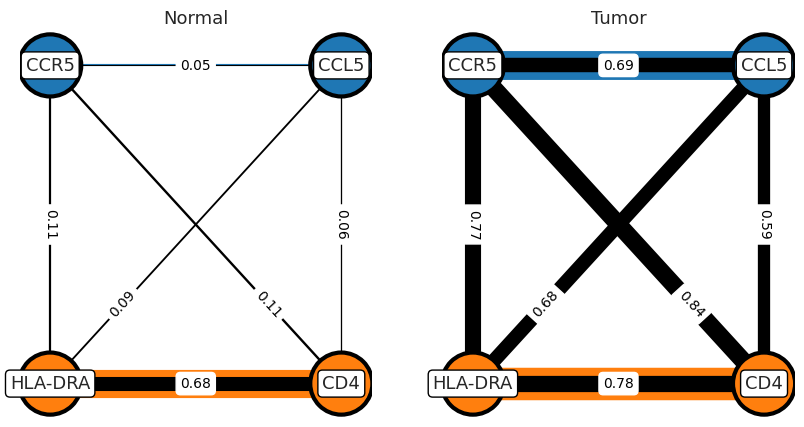

CCL5+CCR5&CD4+HLA-DPA1


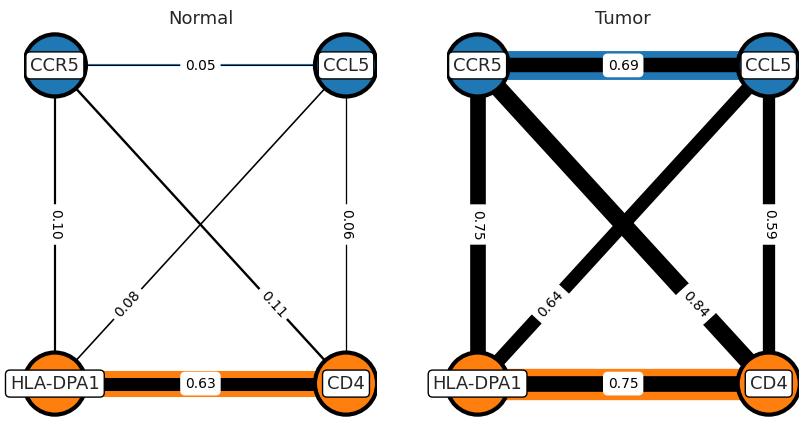


thyroid
Normal
Tumor

skin
Normal
Tumor

prostate
Normal
Tumor

adrenal_gland
Normal
Tumor

pancreas
Normal
Tumor



In [ ]:
from itertools import product

for tissue in pivot_df.tissue.unique():

    print(tissue)
    corr_path = '/home/lnemati/pathway_crosstalk/data/networks'
    save_path = '/home/lnemati/pathway_crosstalk/results/figures/crosstalk/cliques_correlations'
    
    ncorr = network_to_adj(os.path.join(corr_path, 'normal', tissue+'.csv.gz'))
    tcorr = network_to_adj(os.path.join(corr_path, 'tumor',  tissue+'.csv.gz'))

    N = 10000 # Number of top interactions to plot

    print('Normal')
    for interaction in pivot_df.query('tissue == @tissue and difference < 0.').head(N)['interaction'].unique():
        genes = re.split('[+&]', interaction)
        
        if not (ncorr.loc[genes, genes] > 0.15).sum().sum() == 12:
            # Only plot cliques
            continue
        
        if ((tcorr.loc[genes[0], genes[1]] <= 0) or (tcorr.loc[genes[2], genes[3]] <= 0)):
            # Only plot if CCIs are there
            continue
            
        if any(tcorr.loc[genes, genes].unstack().loc[list(product([genes[0], genes[1]], [genes[2], genes[3]]))] > 0.33):
            # Only plot those where one side has only low correlations 
            continue
            
        print(interaction)
        plot_gene_network(genes, savepath=os.path.join(save_path, tissue+'_normal_'+interaction))

    print('Tumor')
    for interaction in pivot_df.query('tissue == @tissue and difference > 0.').tail(N)[::-1]['interaction'].unique():
        genes = re.split('[+&]', interaction)
        
        if not (tcorr.loc[genes, genes] > 0.5).sum().sum() == 12:
            # Only plot cliques
            continue
        
        if ((ncorr.loc[genes[0], genes[1]] <= 0) or (ncorr.loc[genes[2], genes[3]] <= 0)):
            # Only plot if CCIs are there
            continue
        
        if any(ncorr.loc[genes, genes].unstack().loc[list(product([genes[0], genes[1]], [genes[2], genes[3]]))] > 0.15):
            # Only plot those where one side has only low correlations 
            continue
        
        print(interaction)
        plot_gene_network(genes, savepath=None)
        #plot_gene_network(genes, savepath=os.path.join(save_path, tissue+'_tumor_'+interaction))
        
    print()

In [ ]:
cliques = cliques.sort_values(by='result')

In [ ]:
cliques.to_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/cliques_directions.csv')

In [ ]:
dens = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor/motifs_densities.csv' , index_col='interaction').query('motif == "4_clique"')
#dens = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/normal/motifs_densities.csv', index_col='interaction').query('motif == "4_clique"')
#dens = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/both/motifs_densities.csv'  , index_col='interaction').query('motif == "4_clique"')

In [ ]:
tdens = dens[[col for col in dens.columns if col.startswith('tumor')]]
tumor_above_th = (tdens > 0.5).sum(1).sort_values()[::-1]
#normal_above_th = (tdens[[col for col in tdens.columns if col.startswith('normal')]] > 0.7).sum(1)

In [ ]:
sum(tumor_above_th >= 1) / 3818

0.8203247773703509

In [ ]:
tumor_above_th.head(5)

interaction
CSF1+CSF1R&LAIR1+LILRB4     27
ICAM1+ITGB2&LAIR1+LILRB4    27
CCL3+CCR1&LAIR1+LILRB4      26
SIGLEC1+SPN&CD4+HLA-DPB1    26
SIGLEC1+SPN&LAIR1+LILRB4    26
dtype: int64

In [ ]:
tdens.loc['CSF1+CSF1R&LAIR1+LILRB4']

tumor_adrenal_gland.csv              0.869810
tumor_bile_duct.csv                  0.796124
tumor_bladder.csv                    0.840630
tumor_brain.csv                      0.750743
tumor_breast.csv                     0.700949
tumor_cervix.csv                     0.741654
tumor_colon.csv                      0.878221
tumor_endometrium.csv                0.729350
tumor_esophagus.csv                  0.779617
tumor_eye.csv                        0.795957
tumor_head_and_neck_region.csv       0.824472
tumor_kidney.csv                     0.760416
tumor_lining_of_body_cavities.csv    0.636611
tumor_liver.csv                      0.728079
tumor_lung.csv                       0.737658
tumor_lymphatic_tissue.csv           0.634058
tumor_ovary.csv                      0.777127
tumor_pancreas.csv                   0.797513
tumor_paraganglia.csv                0.697360
tumor_prostate.csv                   0.750250
tumor_rectum.csv                     0.887626
tumor_skin.csv                    

In [ ]:
high_th = 0.5
low_th = -0.05

subset = tdens.loc[(tdens < low_th).sum(1) > 1]
subset = subset.loc[(subset > high_th).sum(1) >= 1]
subset

tumor_adrenal_gland.csv  tumor_bile_duct.csv  \
interaction                                                              
ADGRE2+THY1&CLEC2B+KLRB1                 0.127397             0.372636   
CCL8+CCR5&CD47+SIRPA                    -0.017546            -0.079648   
CD80+CTLA4&CD47+SIRPA                   -0.017546            -0.060556   

                          tumor_bladder.csv  tumor_brain.csv  \
interaction                                                    
ADGRE2+THY1&CLEC2B+KLRB1           0.126774         0.080549   
CCL8+CCR5&CD47+SIRPA               0.501454         0.163324   
CD80+CTLA4&CD47+SIRPA              0.224603         0.035828   

                          tumor_breast.csv  tumor_cervix.csv  tumor_colon.csv  \
interaction                                                                     
ADGRE2+THY1&CLEC2B+KLRB1          0.376108          0.128952         0.515789   
CCL8+CCR5&CD47+SIRPA              0.409858          0.288857         0.102925   
CD80+CTLA4&CD47+SIRPA             0.413382          0.374360         0.090977   

                          tumor_endometrium.csv  tumor_esophagus.csv  \
interaction                                                            
ADGRE2+THY1&CLEC2B+KLRB1               0.372636             0.169930   
CCL8+CCR5&CD47+SIRPA                   0.201191             0.256847   
CD80+CTLA4&CD47+SIRPA                  0.029810             0.330764   

                          tumor_eye.csv  ...  tumor_paraganglia.csv  \
interaction                              ...                          
ADGRE2+THY1&CLEC2B+KLRB1      -0.088723  ...               0.224229   
CCL8+CCR5&CD47+SIRPA          -0.076114  ...               0.169657   
CD80+CTLA4&CD47+SIRPA         -0.076114  ...               0.033764   

                          tumor_prostate.csv  tumor_rectum.csv  \
interaction                                                      
ADGRE2+THY1&CLEC2B+KLRB1            0.485590          0.480866   
CCL8+CCR5&CD47+SIRPA                0.194000          0.087871   
CD80+CTLA4&CD47+SIRPA               0.126735          0.219956   

                          tumor_skin.csv  tumor_soft_tissue_bone.csv  \
interaction                                                            
ADGRE2+THY1&CLEC2B+KLRB1       -0.052734                    0.366820   
CCL8+CCR5&CD47+SIRPA            0.111721                    0.324829   
CD80+CTLA4&CD47+SIRPA          -0.002572                   -0.006894   

                          tumor_stomach.csv  tumor_testis.csv  \
interaction                                                     
ADGRE2+THY1&CLEC2B+KLRB1           0.387167          0.386445   
CCL8+CCR5&CD47+SIRPA               0.204301          0.356910   
CD80+CTLA4&CD47+SIRPA              0.212778          0.514257   

                          tumor_thymus.csv  tumor_thyroid.csv  \
interaction                                                     
ADGRE2+THY1&CLEC2B+KLRB1          0.082535           0.249355   
CCL8+CCR5&CD47+SIRPA              0.334287           0.382732   
CD80+CTLA4&CD47+SIRPA             0.079504           0.049491   

                          tumor_uterus.csv  
interaction                                 
ADGRE2+THY1&CLEC2B+KLRB1          0.086833  
CCL8+CCR5&CD47+SIRPA              0.289763  
CD80+CTLA4&CD47+SIRPA            -0.002069  

[3 rows x 28 columns]

In [ ]:
subset.max(1)

interaction
ADGRE2+THY1&CLEC2B+KLRB1    0.515789
CCL8+CCR5&CD47+SIRPA        0.501454
CD80+CTLA4&CD47+SIRPA       0.514257
dtype: float64

In [ ]:
subset.min(1)

interaction
ADGRE2+THY1&CLEC2B+KLRB1   -0.088723
CCL8+CCR5&CD47+SIRPA       -0.079648
CD80+CTLA4&CD47+SIRPA      -0.076114
dtype: float64

In [ ]:
tdens.loc['ADGRE2+THY1&CLEC2B+KLRB1'].sort_values()

tumor_eye.csv                       -0.088723
tumor_skin.csv                      -0.052734
tumor_brain.csv                      0.080549
tumor_thymus.csv                     0.082535
tumor_uterus.csv                     0.086833
tumor_head_and_neck_region.csv       0.114530
tumor_ovary.csv                      0.118360
tumor_lymphatic_tissue.csv           0.121280
tumor_bladder.csv                    0.126774
tumor_adrenal_gland.csv              0.127397
tumor_cervix.csv                     0.128952
tumor_esophagus.csv                  0.169930
tumor_lining_of_body_cavities.csv    0.217700
tumor_paraganglia.csv                0.224229
tumor_thyroid.csv                    0.249355
tumor_lung.csv                       0.290916
tumor_soft_tissue_bone.csv           0.366820
tumor_kidney.csv                     0.369635
tumor_bile_duct.csv                  0.372636
tumor_endometrium.csv                0.372636
tumor_breast.csv                     0.376108
tumor_testis.csv                  

In [ ]:
tdens.loc['NRP2_PLXNA1+SEMA3G&ITGAV_ITGB6+TNXB'].sort_values()

tumor_adrenal_gland.csv             -0.138462
tumor_lining_of_body_cavities.csv    0.028536
tumor_soft_tissue_bone.csv           0.088538
tumor_paraganglia.csv                0.101430
tumor_thymus.csv                     0.112337
tumor_brain.csv                      0.119748
tumor_skin.csv                       0.140638
tumor_liver.csv                      0.176330
tumor_lymphatic_tissue.csv           0.181171
tumor_eye.csv                        0.194103
tumor_uterus.csv                     0.210249
tumor_prostate.csv                   0.242396
tumor_rectum.csv                     0.278255
tumor_testis.csv                     0.286987
tumor_stomach.csv                    0.294026
tumor_cervix.csv                     0.306020
tumor_kidney.csv                     0.306311
tumor_bladder.csv                    0.312694
tumor_colon.csv                      0.313123
tumor_endometrium.csv                0.338494
tumor_ovary.csv                      0.353431
tumor_head_and_neck_region.csv    

In [ ]:
(tdens > high_th).sum(1)

interaction
CD4+HLA-DPB1&LAIR1+LILRB4                 28
CD4+HLA-DPA1&LAIR1+LILRB4                 28
CD4+HLA-DRA&LAIR1+LILRB4                  28
CD4+HLA-DOA&LAIR1+LILRB4                  28
CD4+IL16&LAIR1+LILRB4                     28
                                          ..
CXCL11+DPP4&TNF+TNFRSF1A                  25
TNFRSF9+TNFSF9&COL27A1+ITGA10_ITGB1       25
TNFRSF9+TNFSF9&EGFR+HBEGF                 24
COL10A1+ITGA10_ITGB1&TNFRSF11B+TNFSF11    23
COL10A1+ITGA10_ITGB1&F2RL2+GZMA           21
Length: 3818, dtype: int64

In [ ]:
(tdens < low_th).sum(1)

interaction
CD4+HLA-DPB1&LAIR1+LILRB4                 0
CD4+HLA-DPA1&LAIR1+LILRB4                 0
CD4+HLA-DRA&LAIR1+LILRB4                  0
CD4+HLA-DOA&LAIR1+LILRB4                  0
CD4+IL16&LAIR1+LILRB4                     0
                                         ..
CXCL11+DPP4&TNF+TNFRSF1A                  3
TNFRSF9+TNFSF9&COL27A1+ITGA10_ITGB1       3
TNFRSF9+TNFSF9&EGFR+HBEGF                 4
COL10A1+ITGA10_ITGB1&TNFRSF11B+TNFSF11    2
COL10A1+ITGA10_ITGB1&F2RL2+GZMA           5
Length: 3818, dtype: int64

In [ ]:
tdens.loc['TNFRSF8+TNFSF8&CD80+CTLA4']

tumor_adrenal_gland.csv              0.000000
tumor_bile_duct.csv                  0.000000
tumor_bladder.csv                    0.000000
tumor_brain.csv                      0.000000
tumor_breast.csv                     0.602898
tumor_cervix.csv                     0.622273
tumor_colon.csv                      0.365903
tumor_endometrium.csv                0.057993
tumor_esophagus.csv                  0.606615
tumor_eye.csv                        0.000000
tumor_head_and_neck_region.csv       0.505520
tumor_kidney.csv                     0.173461
tumor_lining_of_body_cavities.csv    0.336581
tumor_liver.csv                      0.000000
tumor_lung.csv                       0.573915
tumor_lymphatic_tissue.csv           0.152224
tumor_ovary.csv                      0.045118
tumor_pancreas.csv                   0.671233
tumor_paraganglia.csv                0.000000
tumor_prostate.csv                   0.103612
tumor_rectum.csv                     0.605252
tumor_skin.csv                    

In [ ]:
tdens

tumor_adrenal_gland.csv  \
interaction                                                       
CD4+HLA-DPB1&LAIR1+LILRB4                              0.856384   
CD4+HLA-DPA1&LAIR1+LILRB4                              0.835337   
CD4+HLA-DRA&LAIR1+LILRB4                               0.858357   
CD4+HLA-DOA&LAIR1+LILRB4                               0.855780   
CD4+IL16&LAIR1+LILRB4                                  0.916638   
...                                                         ...   
CXCL11+DPP4&TNF+TNFRSF1A                               0.006225   
TNFRSF9+TNFSF9&COL27A1+ITGA10_ITGB1                    0.036995   
TNFRSF9+TNFSF9&EGFR+HBEGF                              0.028472   
COL10A1+ITGA10_ITGB1&TNFRSF11B+TNFSF11                 0.000000   
COL10A1+ITGA10_ITGB1&F2RL2+GZMA                        0.000000   

                                        tumor_bile_duct.csv  \
interaction                                                   
CD4+HLA-DPB1&LAIR1+LILRB4                          0.873181   
CD4+HLA-DPA1&LAIR1+LILRB4                          0.893797   
CD4+HLA-DRA&LAIR1+LILRB4                           0.891464   
CD4+HLA-DOA&LAIR1+LILRB4                           0.864781   
CD4+IL16&LAIR1+LILRB4                              0.834015   
...                                                     ...   
CXCL11+DPP4&TNF+TNFRSF1A                          -0.038737   
TNFRSF9+TNFSF9&COL27A1+ITGA10_ITGB1               -0.124953   
TNFRSF9+TNFSF9&EGFR+HBEGF                         -0.013156   
COL10A1+ITGA10_ITGB1&TNFRSF11B+TNFSF11             0.176451   
COL10A1+ITGA10_ITGB1&F2RL2+GZMA                    0.296262   

                                        tumor_bladder.csv  tumor_brain.csv  \
interaction                                                                  
CD4+HLA-DPB1&LAIR1+LILRB4                        0.846987         0.819367   
CD4+HLA-DPA1&LAIR1+LILRB4                        0.832763         0.814105   
CD4+HLA-DRA&LAIR1+LILRB4                         0.831040         0.831807   
CD4+HLA-DOA&LAIR1+LILRB4                         0.773864         0.850591   
CD4+IL16&LAIR1+LILRB4                            0.835884         0.877080   
...                                                   ...              ...   
CXCL11+DPP4&TNF+TNFRSF1A                         0.124214         0.099893   
TNFRSF9+TNFSF9&COL27A1+ITGA10_ITGB1              0.141789         0.084099   
TNFRSF9+TNFSF9&EGFR+HBEGF                        0.236455        -0.044551   
COL10A1+ITGA10_ITGB1&TNFRSF11B+TNFSF11           0.041869         0.067976   
COL10A1+ITGA10_ITGB1&F2RL2+GZMA                  0.202090         0.060191   

                                        tumor_breast.csv  tumor_cervix.csv  \
interaction                                                                  
CD4+HLA-DPB1&LAIR1+LILRB4                       0.831045          0.792056   
CD4+HLA-DPA1&LAIR1+LILRB4                       0.841750          0.775144   
CD4+HLA-DRA&LAIR1+LILRB4                        0.861002          0.767485   
CD4+HLA-DOA&LAIR1+LILRB4                        0.830735          0.744988   
CD4+IL16&LAIR1+LILRB4                           0.785464          0.839127   
...                                                  ...               ...   
CXCL11+DPP4&TNF+TNFRSF1A                        0.193374          0.123843   
TNFRSF9+TNFSF9&COL27A1+ITGA10_ITGB1             0.191887          0.099896   
TNFRSF9+TNFSF9&EGFR+HBEGF                       0.304950          0.247285   
COL10A1+ITGA10_ITGB1&TNFRSF11B+TNFSF11          0.128588          0.022317   
COL10A1+ITGA10_ITGB1&F2RL2+GZMA                 0.098677          0.011704   

                                        tumor_colon.csv  \
interaction                                               
CD4+HLA-DPB1&LAIR1+LILRB4                      0.889303   
CD4+HLA-DPA1&LAIR1+LILRB4                      0.871790   
CD4+HLA-DRA&LAIR1+LILRB4                       0.849586   
CD4+HLA-DOA&LAIR1+LILRB

In [ ]:
dens = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/normal/motifs_densities.csv', index_col='interaction').query('motif == "4_clique"')

In [ ]:
ndens = dens[[col for col in dens.columns if col.startswith('normal')]]
normal_above_th = (ndens > 0.5).sum(1).sort_values()[::-1]
#normal_above_th = (tdens[[col for col in tdens.columns if col.startswith('normal')]] > 0.7).sum(1)

In [ ]:
sum(normal_above_th >= 1)

69

In [ ]:
1

1

In [ ]:
69 / 155

0.44516129032258067

In [ ]:
69 / 155

In [ ]:
tumor_above_th.value_counts(normalize=True)

0     0.179675
1     0.081456
2     0.059455
3     0.050550
10    0.044788
4     0.041907
5     0.039026
14    0.036406
17    0.036406
8     0.035359
9     0.033525
7     0.032478
12    0.030120
11    0.028811
6     0.026716
15    0.025668
13    0.025406
18    0.024620
16    0.024620
22    0.022787
23    0.021739
19    0.020168
20    0.019644
21    0.016763
26    0.015977
24    0.012834
25    0.012572
27    0.000524
Name: proportion, dtype: float64

In [ ]:
normal_above_th.value_counts(normalize=True)

0    0.554839
1    0.174194
2    0.148387
3    0.064516
4    0.051613
6    0.006452
Name: proportion, dtype: float64

In [ ]:
normal_above_th.head(30)

interaction
ALOX5_ALOX5AP_LTC4S+GPR17&NTF3+NTRK3    6
L1CAM+NCAM2&SFRP5+WNT6                  4
FZD7_LRP6+WNT6&ADCYAP1R1+VIP            4
SFRP5+WNT6&NLGN4X+NRXN1                 4
NTF3+NTRK3&FZD7_LRP6+WNT6               4
ALOX5_ALOX5AP_LTC4S+GPR17&VIP+VIPR2     4
FZD7_LRP6+WNT6&VIP+VIPR2                4
FZD3_LRP6+WNT6&VIP+VIPR2                4
ADCYAP1R1+VIP&NLGN1+NRXN1               4
ADCYAP1R1+VIP&NTRK3+PTPRS               3
CHL1+L1CAM&VIP+VIPR2                    3
FZD1_LRP6+WNT6&ADCYAP1R1+VIP            3
ADGRL3+TENM1&GLS_SLC1A7+GRIK3_GRIK5     3
ADCYAP1R1+VIP&CLSTN2+NRXN1              3
ADGRL2+TENM1&VIP+VIPR2                  3
NTRK3+PTPRS&SFRP5+WNT6                  3
SFRP4+WNT6&NLGN1+NRXN1                  3
SFRP5+WNT6&PTPRS+SLITRK2                3
CHL1+L1CAM&SFRP5+WNT6                   3
ADCYAP1R1+VIP&FZD7_LRP5+WNT6            2
ADCYAP1R1+VIP&PTPRS+SLITRK2             2
ADCYAP1R1+VIP&THRB+TPO                  2
SFRP2+WNT6&NLGN1+NRXN1                  2
FZD6_LRP6+WNT6&VIP+VIP

In [ ]:
ndens.loc['ALOX5_ALOX5AP_LTC4S+GPR17&NTF3+NTRK3'] > 0.5

normal_adipose_tissue.csv      True
normal_adrenal_gland.csv      False
normal_blood.csv              False
normal_blood_vessel.csv       False
normal_brain.csv              False
normal_breast.csv             False
normal_colon.csv              False
normal_esophagus.csv          False
normal_heart.csv              False
normal_kidney.csv              True
normal_liver.csv              False
normal_lung.csv               False
normal_muscle.csv             False
normal_nerve.csv              False
normal_ovary.csv               True
normal_pancreas.csv           False
normal_pituitary.csv          False
normal_prostate.csv           False
normal_salivary_gland.csv      True
normal_skin.csv               False
normal_small_intestine.csv    False
normal_spleen.csv             False
normal_stomach.csv             True
normal_thyroid.csv            False
normal_uterus.csv             False
normal_vagina.csv              True
Name: ALOX5_ALOX5AP_LTC4S+GPR17&NTF3+NTRK3, dtype: bool

In [ ]:
high_th = 0.5
low_th = -0.0

subset = ndens.loc[(ndens < low_th).sum(1) > 1]
subset = subset.loc[(subset > high_th).sum(1) >= 1]
subset

normal_adipose_tissue.csv  \
interaction                                                       
NTF3+NTRK3&FZD7_LRP6+WNT6                              0.416962   
FZD1_LRP6+WNT6&NTF3+NTRK3                              0.420610   
L1CAM+NCAM2&SFRP5+WNT6                                 0.121652   
FZD7_LRP6+WNT6&VIP+VIPR2                               0.341140   
NTRK3+PTPRS&SFRP5+WNT6                                 0.000990   
FZD1_LRP6+WNT6&NLGN1+NRXN1                             0.341981   
NTF3+NTRK3&FZD4_LRP5+WNT6                              0.451451   
FZD1_LRP6+WNT6&VIP+VIPR2                               0.344788   
ADCYAP1R1+VIP&NTRK3+PTPRS                              0.074515   
CHL1+L1CAM&VIP+VIPR2                                   0.148853   
SFRP5+WNT6&NLGN4X+NRXN1                                0.049259   
FZD6_LRP6+WNT6&VIP+VIPR2                               0.365420   
GLS_SLC1A1+GRIA1&NLGN3+NRXN1                           0.296372   
GLS_SLC1A3+GRIA1&NLGN3+NRXN1                           0.296372   
VIP+VIPR2&FZD4_LRP5+WNT6                               0.375629   
ADCYAP1R1+VIP&CLSTN2+NRXN1                             0.099563   
NLGN3+NRXN1&GLS_SLC1A7+GRIA1                           0.296372   
ADCYAP1R1+VIP&NLGN1+NRXN1                              0.157014   
ADCYAP1R1+VIP&PTPRS+SLITRK2                            0.034767   
ADGRL3+TENM1&ADCYAP1R1+VIP                             0.142166   
ADCYAP1R1+VIP&FZD4_LRP6+WNT6                          -0.005292   
VIP+VIPR2&FZD7_LRP5+WNT6                               0.062552   
NTF3+NTRK3&ADCYAP1R1+VIP                               0.282389   
SFRP5+WNT6&PTPRS+SLITRK2                               0.000081   
NTF3+NTRK3&FZD2_LRP6+WNT6                              0.303759   
L1CAM+NCAM2&ALDH1A1+CRABP2_RARG_RXRG                   0.243165   
ADCYAP1R1+VIP&FZD2_LRP5+WNT6                           0.051906   
FZD8_LRP6+WNT6&VIP+VIPR2                               0.171487   
ADCYAP1R1+VIP&FZD2_LRP6+WNT6                           0.139369   
ADCYAP1R1+VIP&FZD5_LRP5+WNT6                           0.181661   
NLGN1+NRXN1&THRB+TPO                                   0.099250   
NLGN3+NRXN1&ENPP3+GPR17                                0.196002   
SFRP5+WNT6&DAG1+NRXN1                                  0.053925   
ADGRL2+TENM1&VIP+VIPR2                                 0.055972   
ADCYAP1R1+VIP&THRB+TPO                                 0.098494   
ADCYAP1R1+VIP&COL4A3+ITGA11_ITGB1                      0.019440   
ENPP3+GPR17&NLGN1+NRXN1                                0.118779   
FRZB+WNT6&ENPP3+GPR17                                  0.172014   
VIP+VIPR2&THRB+TPO                                     0.035155   
ADCYAP1R1+VIP&ENPP3+GPR17                              0.136724   
ENPP3+GPR17&SFRP5+WNT6                                 0.024652   
ACVR1_ACVR2B+BMP8B&SFRP5+WNT6                          0.005206   
VIP+VIPR2&ENPP3+GPR17                                  0.067351   

                                      normal_adrenal_gland.csv  \
interaction                                                      
NTF3+NTRK3&FZD7_LRP6+WNT6                             0.057878   
FZD1_LRP6+WNT6&NTF3+NTRK3                             0.036494   
L1CAM+NCAM2&SFRP5+WNT6                                0.248558   
FZD7_LRP6+WNT6&VIP+VIPR2                              0.057878   
NTRK3+PTPRS&SFRP5+WNT6                                0.264613   
FZD1_LRP6+WNT6&NLGN1+NRXN1                            0.000000   
NTF3+NTRK3&FZD4_LRP5+WNT6                            -0.005237   
FZD1_LRP6+WNT6&VIP+VIPR2                              0.036494   
ADCYAP1R1+VIP&NTRK3+PTPRS                             0.077597   
CHL1+L1CAM&VIP+VIPR2                                  0.198711   
SFRP5+WNT6&NLGN4X+NRXN1                               0.000000   
FZD6_LRP6+WNT6&VIP+VIPR2                              0.052663   
GLS_SLC1A1+GRIA1&NLGN3+NRXN1                          0.099818   
GLS_SLC1A3+GRIA1&NLGN3+NRXN1    

In [ ]:
subset.max(1)

interaction
NTF3+NTRK3&FZD7_LRP6+WNT6               0.544746
FZD1_LRP6+WNT6&NTF3+NTRK3               0.534062
L1CAM+NCAM2&SFRP5+WNT6                  0.733386
FZD7_LRP6+WNT6&VIP+VIPR2                0.682288
NTRK3+PTPRS&SFRP5+WNT6                  0.624199
FZD1_LRP6+WNT6&NLGN1+NRXN1              0.741888
NTF3+NTRK3&FZD4_LRP5+WNT6               0.529476
FZD1_LRP6+WNT6&VIP+VIPR2                0.664236
ADCYAP1R1+VIP&NTRK3+PTPRS               0.635118
CHL1+L1CAM&VIP+VIPR2                    0.832265
SFRP5+WNT6&NLGN4X+NRXN1                 0.723519
FZD6_LRP6+WNT6&VIP+VIPR2                0.708987
GLS_SLC1A1+GRIA1&NLGN3+NRXN1            0.543086
GLS_SLC1A3+GRIA1&NLGN3+NRXN1            0.543086
VIP+VIPR2&FZD4_LRP5+WNT6                0.555870
ADCYAP1R1+VIP&CLSTN2+NRXN1              0.770764
NLGN3+NRXN1&GLS_SLC1A7+GRIA1            0.543086
ADCYAP1R1+VIP&NLGN1+NRXN1               0.824623
ADCYAP1R1+VIP&PTPRS+SLITRK2             0.700030
ADGRL3+TENM1&ADCYAP1R1+VIP              0.584784
ADCYAP1R

In [ ]:
subset.min(1)

interaction
NTF3+NTRK3&FZD7_LRP6+WNT6              -0.027207
FZD1_LRP6+WNT6&NTF3+NTRK3              -0.033280
L1CAM+NCAM2&SFRP5+WNT6                 -0.029225
FZD7_LRP6+WNT6&VIP+VIPR2               -0.042537
NTRK3+PTPRS&SFRP5+WNT6                 -0.049447
FZD1_LRP6+WNT6&NLGN1+NRXN1             -0.057929
NTF3+NTRK3&FZD4_LRP5+WNT6              -0.037498
FZD1_LRP6+WNT6&VIP+VIPR2               -0.033280
ADCYAP1R1+VIP&NTRK3+PTPRS              -0.059978
CHL1+L1CAM&VIP+VIPR2                   -0.086496
SFRP5+WNT6&NLGN4X+NRXN1                -0.030018
FZD6_LRP6+WNT6&VIP+VIPR2               -0.119025
GLS_SLC1A1+GRIA1&NLGN3+NRXN1           -0.032851
GLS_SLC1A3+GRIA1&NLGN3+NRXN1           -0.052772
VIP+VIPR2&FZD4_LRP5+WNT6               -0.023220
ADCYAP1R1+VIP&CLSTN2+NRXN1             -0.083750
NLGN3+NRXN1&GLS_SLC1A7+GRIA1           -0.032851
ADCYAP1R1+VIP&NLGN1+NRXN1              -0.092422
ADCYAP1R1+VIP&PTPRS+SLITRK2            -0.039102
ADGRL3+TENM1&ADCYAP1R1+VIP             -0.072049
ADCYAP1R

In [ ]:
ndens.loc['FZD6_LRP6+WNT6&VIP+VIPR2']

normal_adipose_tissue.csv     0.365420
normal_adrenal_gland.csv      0.052663
normal_blood.csv              0.000000
normal_blood_vessel.csv       0.060079
normal_brain.csv              0.162803
normal_breast.csv             0.168182
normal_colon.csv              0.403332
normal_esophagus.csv          0.108955
normal_heart.csv              0.267604
normal_kidney.csv             0.437885
normal_liver.csv              0.000000
normal_lung.csv               0.085691
normal_muscle.csv             0.020535
normal_nerve.csv              0.187116
normal_ovary.csv              0.095123
normal_pancreas.csv           0.049813
normal_pituitary.csv          0.229630
normal_prostate.csv           0.131179
normal_salivary_gland.csv    -0.055997
normal_skin.csv               0.172201
normal_small_intestine.csv    0.708987
normal_spleen.csv             0.293836
normal_stomach.csv            0.555336
normal_thyroid.csv            0.226082
normal_uterus.csv             0.223819
normal_vagina.csv        

In [ ]:
(tdens < 0).sum(1).sort_values()

interaction
SELL+SELPLG&F2RL2+GZMA             0
PDCD1+PDCD1LG2&CD28+CD80           0
PLA2G7+PTAFR&CXCL13+CXCR3          0
CD8A+HLA-E&CD28+CD80               0
PLA2G7+PTAFR&CCL8+CCR2             0
                                  ..
CXCL10+DPP4&TNF+TNFRSF1A           4
COL10A1+ITGA10_ITGB1&F2RL2+GZMA    5
CD47+SIRPG&TNF+TNFRSF1A            5
CCL22+CCR4&MCAM+WNT5A              6
CD80+CTLA4&CD47+SIRPA              6
Length: 3818, dtype: int64

In [ ]:
(ndens < 0).sum(1).sort_values()

interaction
ALOX5_ALOX5AP_LTC4S+GPR17&NTF3+NTRK3     0
COL4A6+ITGA11_ITGB1&GLS_SLC1A7+GRIA1     0
GLS_SLC1A2+GRIA1&NTF3+NTRK2              0
PTGDR+PTGS2&GLS_SLC1A7+GRIA1             0
ADGRL3+TENM1&GLS_SLC1A7+GRIK3_GRIK5      0
                                        ..
ADCYAP1R1+VIP&ADGRG6+COL4A3              9
SFRP4+WNT6&ENPP3+GPR17                   9
GLS_SLC17A7+GRIA1&ENPP3+GPR17            9
VIP+VIPR2&ACVR1_ACVR2B+BMP8B            10
ACVR1_ACVR2B+BMP5&ENPP3+GPR17           11
Length: 155, dtype: int64

In [ ]:
ndens.loc['VIP+VIPR2&ACVR1_ACVR2B+BMP8B'][ndens.loc['VIP+VIPR2&ACVR1_ACVR2B+BMP8B'] < 0]

normal_blood_vessel.csv      -0.056965
normal_colon.csv             -0.019666
normal_lung.csv              -0.090289
normal_muscle.csv            -0.031319
normal_nerve.csv             -0.219422
normal_ovary.csv             -0.021998
normal_pancreas.csv          -0.014663
normal_small_intestine.csv   -0.028655
normal_thyroid.csv           -0.049584
normal_uterus.csv            -0.190157
Name: VIP+VIPR2&ACVR1_ACVR2B+BMP8B, dtype: float64

In [ ]:
normal_blood_vessel.csv        True

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import entropy

# Normalize each row to sum to 1
probs = (tdens.T / tdens.sum(axis=1)).T

# Replace any NaNs (from division by zero) with 0
probs = probs.fillna(0)

# Compute Shannon entropy (base 2) for each row
entropies = probs.apply(lambda row: entropy(row + 1e-12, base=2), axis=1)

# Filter out any remaining infinite values, just in case
entropies = entropies.replace([np.inf, -np.inf], np.nan).dropna()


In [ ]:
entropies.sort_values()

interaction
TNFRSF8+TNFSF8&CD80+CTLA4         3.916571
COL10A1+ITGA1_ITGB1&CCL22+CCR4    3.936906
CCL22+CCR4&SFRP4+WNT2             3.965588
CCL22+CCR4&SFRP2+WNT2             3.967219
CCL22+CCR4&CD274+CD80             3.972273
                                    ...   
CCL5+CCR1&HLA-E+VSIR              4.788339
CCL5+CCR1&HLA-F+LILRB2            4.789855
CSF1+CSF1R&HLA-F+LILRB2           4.791785
CSF1+CSF1R&CCL3+CCR1              4.791829
CSF1+CSF1R&CCL5+CCR1              4.794372
Length: 3084, dtype: float64

In [ ]:
tdens.loc['COL10A1+ITGA10_ITGB1&F2RL2+GZMA']

tumor_adrenal_gland.csv              0.000000
tumor_bile_duct.csv                  0.296262
tumor_bladder.csv                    0.202090
tumor_brain.csv                      0.060191
tumor_breast.csv                     0.098677
tumor_cervix.csv                     0.011704
tumor_colon.csv                      0.131177
tumor_endometrium.csv                0.057511
tumor_esophagus.csv                  0.107815
tumor_eye.csv                        0.000000
tumor_head_and_neck_region.csv       0.175355
tumor_kidney.csv                     0.002978
tumor_lining_of_body_cavities.csv   -0.002037
tumor_liver.csv                      0.005620
tumor_lung.csv                       0.011974
tumor_lymphatic_tissue.csv          -0.053850
tumor_ovary.csv                      0.047764
tumor_pancreas.csv                   0.123141
tumor_paraganglia.csv                0.003560
tumor_prostate.csv                   0.299196
tumor_rectum.csv                     0.154521
tumor_skin.csv                    

In [ ]:
tdens.loc['PLA2G7+PTAFR&HLA-F+LILRB2']

tumor_adrenal_gland.csv              0.584152
tumor_bile_duct.csv                  0.448016
tumor_bladder.csv                    0.559131
tumor_brain.csv                      0.415216
tumor_breast.csv                     0.585948
tumor_cervix.csv                     0.418124
tumor_colon.csv                      0.495252
tumor_endometrium.csv                0.382562
tumor_esophagus.csv                  0.450270
tumor_eye.csv                        0.384748
tumor_head_and_neck_region.csv       0.451095
tumor_kidney.csv                     0.433091
tumor_lining_of_body_cavities.csv    0.557450
tumor_liver.csv                      0.389741
tumor_lung.csv                       0.584209
tumor_lymphatic_tissue.csv           0.350732
tumor_ovary.csv                      0.410449
tumor_pancreas.csv                   0.462259
tumor_paraganglia.csv                0.394525
tumor_prostate.csv                   0.269371
tumor_rectum.csv                     0.489255
tumor_skin.csv                    

# CCC Crosstalk Network

In [ ]:
# USE THIS IF YOU WANT TO MOVE TO WILCOXON SIGNED-RANK

# Set tissues that don't have both conditions to other tissues and group them together
#common_tissues = nmean.columns.intersection(tmean.columns)
#nmean.columns = np.where(nmean.columns.isin(common_tissues), nmean.columns, 'other_tissues')
#tmean.columns = np.where(tmean.columns.isin(common_tissues), tmean.columns, 'other_tissues')
#
#nmean = ndf.T.groupby(lambda x: sub2tissue[x]).mean().T # group normal subtissues by major tissue
#tmean = tdf.T.groupby(lambda x: sub2tissue[x]).mean().T # group tumor subtissues by major tissue
#common_tissues = nmean.columns.intersection(tmean.columns)
#
#nmean = nmean.loc[:, common_tissues]
#tmean = tmean.loc[:, common_tissues]


# Get differences and subset to only those with enough variance
#diff = tdf - ndf

#min_std = 1e-4
#diff = diff[diff.std(axis=1) > min_std]

In [ ]:
network = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/network_unfiltered.csv.gz')

In [ ]:
(network['pval_adj'] < 0.05).value_counts()

pval_adj
False    1236311
True      101119
Name: count, dtype: int64

In [ ]:
from igraph import Graph

# Extract edges (node pairs) and weights
edges = list(zip(network['complex1'], network['complex2']))
weights = (2*network['auroc'] - 1).tolist()

# Create the undirected graph
G = Graph.TupleList(edges, directed=False, edge_attrs=['weight'])
G.es['weight'] = weights  # Set the 'auroc' values as edge weights

In [ ]:
matrix = pd.DataFrame(G.get_adjacency(attribute='weight'), index=G.vs['name'], columns=G.vs['name'])

In [ ]:
import leidenalg as la
import igraph as ig

#G = ig.Graph.Weighted_Adjacency(matrix, mode=ig.ADJ_UNDIRECTED)

G_pos = G.subgraph_edges(G.es.select(weight_gt = 0), delete_vertices=False);
G_neg = G.subgraph_edges(G.es.select(weight_lt = 0), delete_vertices=False);
G_neg.es['weight'] = [-w for w in G_neg.es['weight']];

partition = la.find_partition_multiplex(
    graphs = [G_pos, G_neg],
    partition_type = la.ModularityVertexPartition,
    layer_weights = [1, -1],
    #max_comm_size = 500,
    n_iterations=-1,
    weights='weight',
    seed=42,
)

clusters = pd.Series(partition[0], index=G.vs['name'])
clusters.value_counts()

0     436
1     396
2     351
3     333
78      1
     ... 
36      1
35      1
34      1
33      1
48      1
Length: 124, dtype: int64

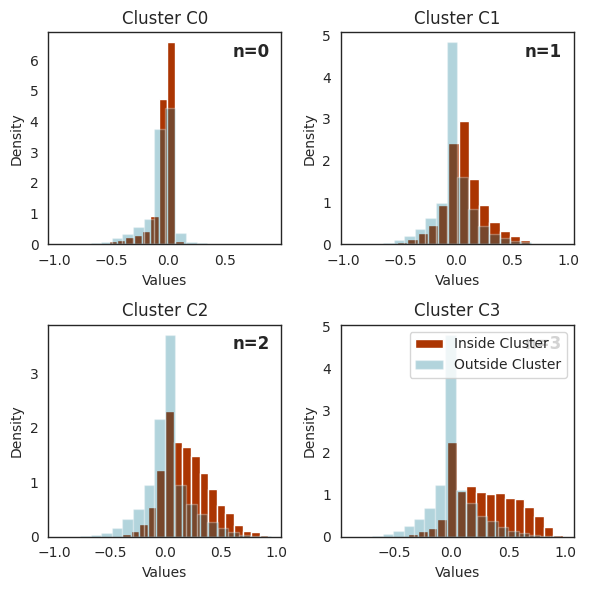

In [ ]:
# Set up a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
axes = axes.flatten()  # Flatten for easier indexing

for n in range(4):
    ax = axes[n]  # Select the subplot in the grid for the current 'n'
    clust = clusters[clusters == n].index
    others = matrix.columns[~matrix.columns.isin(clust)]
    
    # Plot histogram of values within 'clust'
    ax.hist(matrix.loc[clust, clust].values.flatten(), density=True, alpha=1, bins=20, color=tcolor, label='Inside Cluster')
    # Plot histogram of values between 'clust' and 'others'
    ax.hist(matrix.loc[clust, others].values.flatten(), density=True, alpha=0.3, bins=20, color=ncolor, label='Outside Cluster')
    
    # Add text displaying the value of 'n'
    ax.text(0.95, 0.95, f'n={n}', ha='right', va='top', transform=ax.transAxes, fontsize=12, fontweight='bold')
    
    # Optional: add labels or legends
    ax.set_title(f'Cluster C{n}')
    ax.set_xlabel('Values')
    ax.set_ylabel('Density')

plt.legend()
plt.tight_layout()
plt.show()

0.47410445833216425

In [ ]:
for n in range(4):
    clust = clusters[clusters == n].index
    print(np.median(((1 + matrix.loc[clust, clust].values) / 2).flatten()))

0.4821428571428571
0.5231481481481481
0.5806878306878307
0.6283068783068783


In [ ]:
set(pd.Series(clusters[clusters == 1].index.str.split('_')).sum()).intersection(pd.Series(clusters[clusters == 2].index.str.split('_')).sum())

{'ACVR1',
 'ACVR2A',
 'BMPR2',
 'CNTN1',
 'CXCR2',
 'DDC',
 'EGFR',
 'FGFR1',
 'FPR2',
 'GPER1',
 'IGF1R',
 'IL1RAP',
 'IL2RB',
 'IL2RG',
 'INHBB',
 'ITGB1',
 'ITGB3',
 'LRP5',
 'LRP6',
 'PLXNA3',
 'PTCH1',
 'PTCH2',
 'TGFBR1',
 'TGFBR2'}

In [ ]:
import ast
ccc = pd.read_csv('/home/lnemati/pathway_crosstalk/data/interactions/ccc.csv')

# convert: string -> list -> set
ccc['all_genes'] = ccc['all_genes'].apply(lambda x: ast.literal_eval(x)).apply(set)
ccc_gene_sets = set(tuple(sorted(gene_set)) for gene_set in ccc['all_genes'])

In [ ]:
from igraph import Graph
import igraph as ig 

network = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/network_filtered.csv')

# Extract edges (node pairs) and weights
edges = list(zip(network.query('pval_adj < 0.05')['complex1'], network.query('pval_adj < 0.05')['complex2']))

# Create the undirected graph
G = Graph.TupleList(edges, directed=False)